# Evaluación MAA 2025 - Comandos R usados - Pablo Pandolfo
---

# Ejercicio 1
---

### Librerias necesarias

In [138]:
library(MASS)
library(leaps)
library(caret)
library(ggplot2)
library(dplyr) 
library(car)
library(GGally)

## 1.a) y 1.b)

### Lectura de datos

In [139]:
setwd("/Users/ppando/Materias/data/materias/aprendizaje-automatico/exa")

In [140]:
datos <- read.csv('Restaurantes.csv')

### Exploración de la relación de las variables

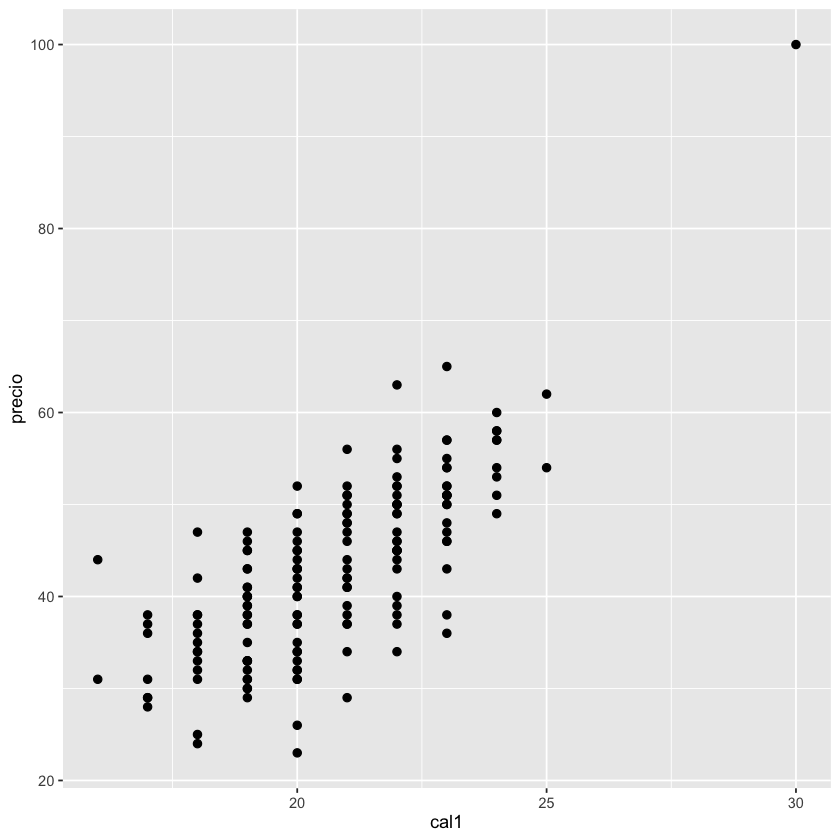

In [141]:
ggplot(data = datos, aes(x = cal1, y = precio)) + geom_point(size = 2)

* Se presume linealidad

### Coeficiente de Correlación Lineal

In [142]:
cor.test(datos$cal1, datos$precio)


	Pearson's product-moment correlation

data:  datos$cal1 and datos$precio
t = 14.362, df = 161, p-value < 2.2e-16
alternative hypothesis: true correlation is not equal to 0
95 percent confidence interval:
 0.6732465 0.8098370
sample estimates:
      cor 
0.7494093 


* La correlación lineal es fuerte y positiva
* Hay suficiente evidencia estadística para rechazar H0

### Modelo

In [143]:
modelo <- lm(precio ~ cal1, data = datos)
summary(modelo)


Call:
lm(formula = precio ~ cal1, data = datos)

Residuals:
     Min       1Q   Median       3Q      Max 
-17.6993  -4.1449   0.2736   3.8551  24.4366 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept) -29.0290     5.0432  -5.756 4.24e-08 ***
cal1          3.4864     0.2428  14.362  < 2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 6.496 on 161 degrees of freedom
Multiple R-squared:  0.5616,	Adjusted R-squared:  0.5589 
F-statistic: 206.3 on 1 and 161 DF,  p-value: < 2.2e-16


* Pvalue chicos => los estimados son significativas
* Los coeficientes estimados son distintos de 0
* $R^2$ representa la explicabilidad del modelo, este modelo explica el 56% de los casos
* p-value del F-statistic es chico, representa que el modelo es globalmente significativo 

### Modelo propuesto

$$\hat{precio} = -29.0290 + 3.4864 * cal1$$

* $\beta_0$ = -29.0290 es el punto donde la línea de regresión cruza el eje Y. También se puede interpretar que es el valor estimado de "precio" cuando "cal1" es igual a 0, pero en este caso ese valor no tiene una interpretación práctica directa, pero si sirve para definir la ordenada al origen de la recta. 
* $\beta_1$ = 3.4864 es el cambio estimado en "precio" por cada aumento de una unidad en "cal1". Indica que, en promedio, por cada unidad que aumenta cal1, el precio aumenta en 3.4864 unidades.

### Validación de los supuestos

#### Residuos vs. valores ajustados

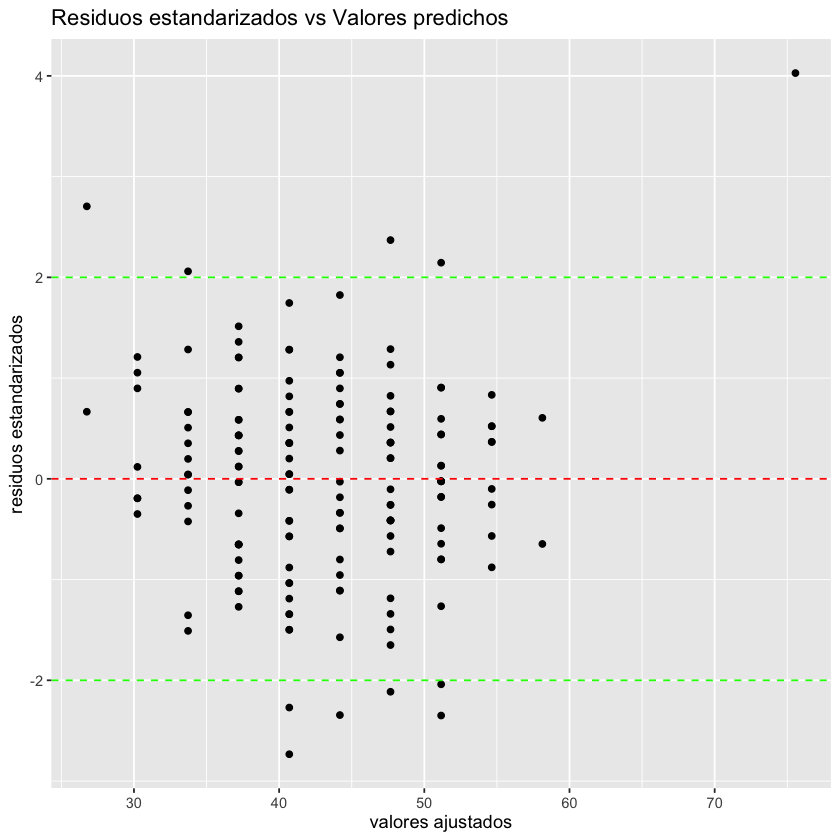

In [144]:
ggplot(data = datos, aes(x = fitted(modelo), y = rstandard(modelo))) + 
    geom_point() + 
    geom_hline(yintercept = 0, linetype = "dashed", color = "red") + 
    geom_hline(yintercept = -2, linetype = "dashed", color = "green") +
    geom_hline(yintercept = 2, linetype = "dashed", color = "green") +
    labs(x = "valores ajustados", 
         y = "residuos estandarizados", 
         title = "Residuos estandarizados vs Valores predichos")

* Están distribuidos de una manera simétrica, pensando que el concepto de homogeneidad se cumple
* Se visualiza un outlier 

#### Residuos vs. variable regresora (cal1)

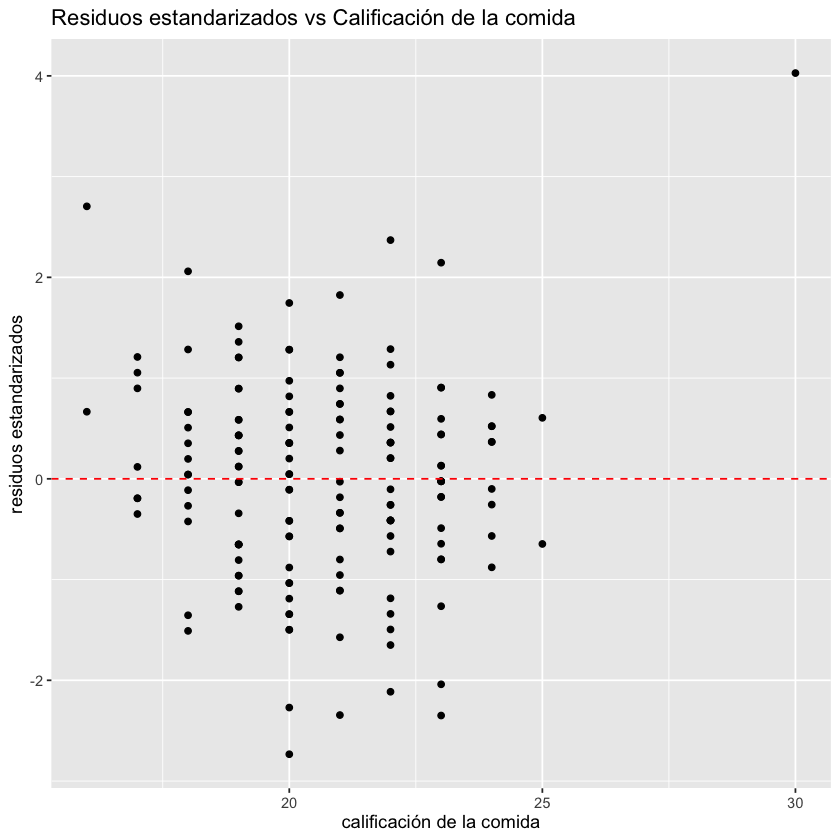

In [145]:
ggplot(data = datos, aes(x = cal1, y = rstandard(modelo))) + 
    geom_point() +
    geom_hline(yintercept = 0, linetype = "dashed", color = "red") +
    labs(x = "calificación de la comida", 
         y = "residuos estandarizados", 
         title = "Residuos estandarizados vs Calificación de la comida")

* En ambos gráficos no se ve una estructura clara; es decir, la distribución es aleatoria
* Se está validando el supuesto de homocedasticidad de los residuos

#### Normalidad de los residuos estandarizados

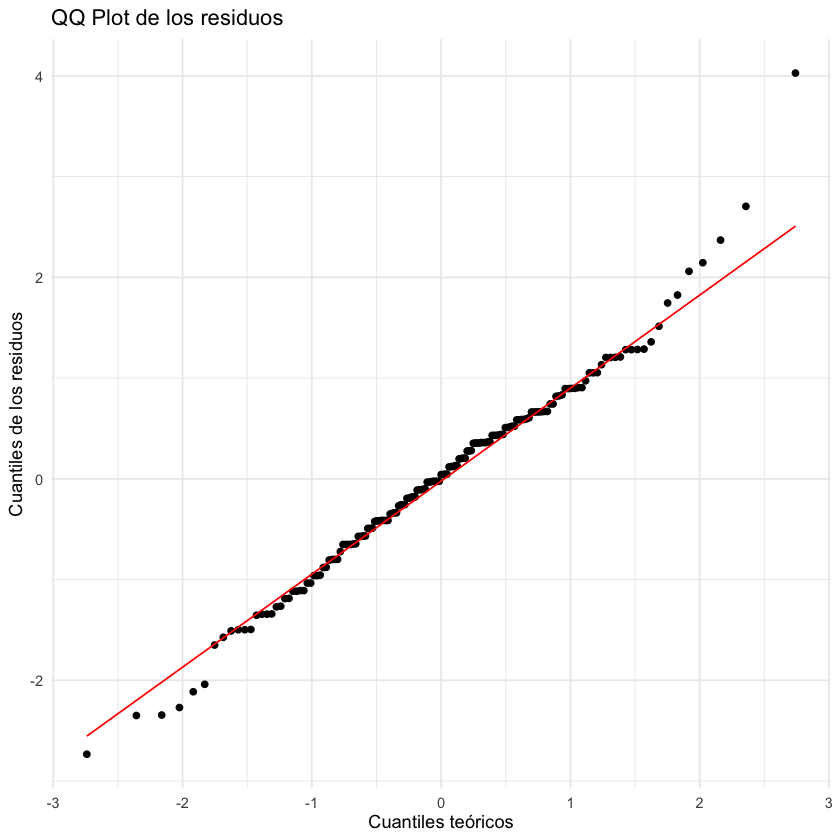

In [146]:
residuos_df = data.frame(rstandard(modelo))
ggplot(data = residuos_df, aes(sample = rstandard(modelo))) +
    stat_qq() +
    stat_qq_line(color = "red") +
    labs(title = "QQ Plot de los residuos", x = "Cuantiles teóricos", y = "Cuantiles de los residuos") +
    theme_minimal()

* Se valida el supuesto de normalidad; es decir, los errores se distribuyen normalmente

### Análisis de puntos influyentes

#### Detección de outliers

In [147]:
which(abs(rstandard(modelo)) > 2)


7  49  81  91 122 127 134 136 140 160 163 
  7  49  81  91 122 127 134 136 140 160 163

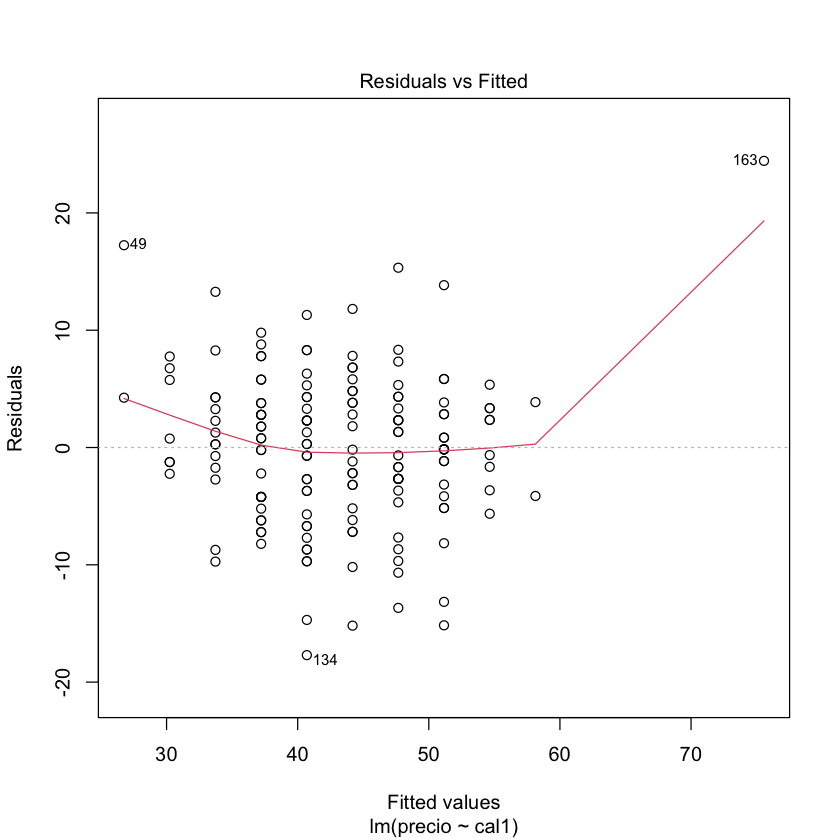

In [148]:
plot(modelo, which = 1) # Residuos vs Predichos

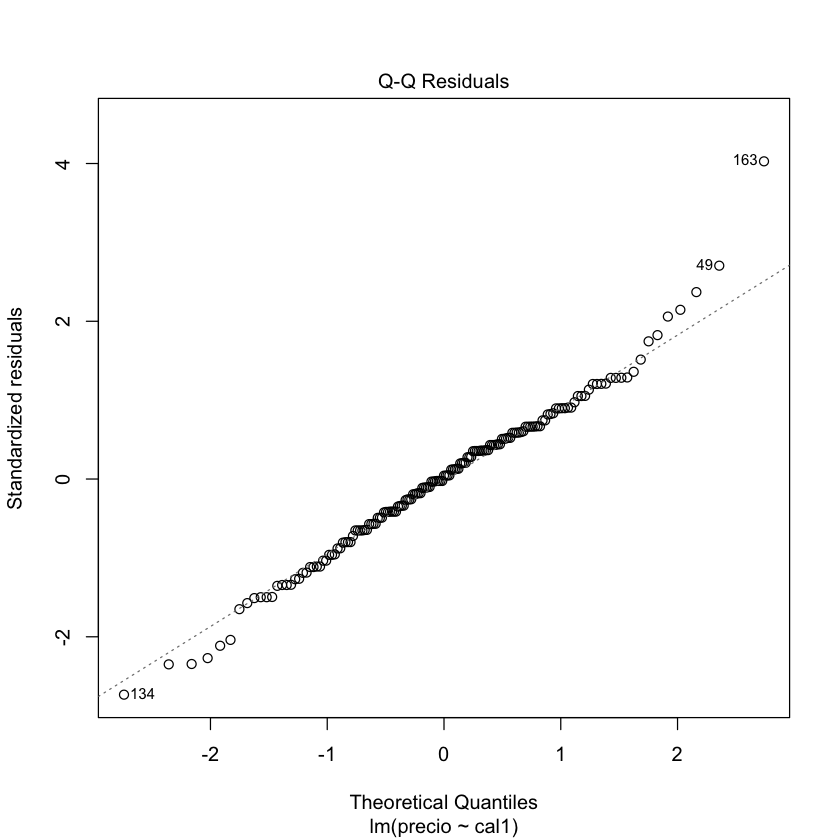

In [149]:
plot(modelo, which = 2) # qqplot

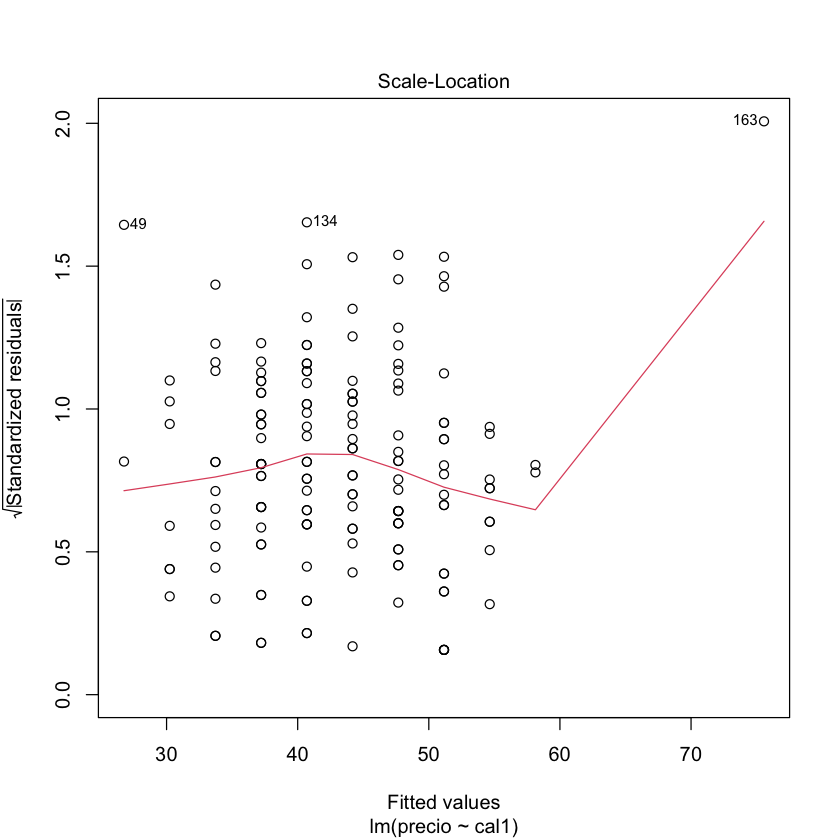

In [150]:
plot(modelo, which = 3) # raiz cuadrada de los residuos estandarizados vs predichos

#### Detección de puntos de alto leverage

In [151]:
leverage <- hatvalues(modelo)
p <- length(coef(modelo))
umbral_lev <- 2 * p / length(datos$cal1)
leverage[leverage > umbral_lev]

34         49         53         66         67         86        113 
0.03233213 0.03657283 0.02493018 0.02493018 0.02493018 0.03233213 0.02493018 
       119        150        154        159        163 
0.02493018 0.02493018 0.03657283 0.02493018 0.12772647

* Se visualiza que el valor de la observación 163 se destaca por sobre las otras observaciones

#### Distancia de Cook

In [152]:
cooks <- cooks.distance(modelo)
p <- length(coef(modelo))
n <- dim(datos)[1]
cooks_umbral <- qf(0.5, p, n-p)
cooks[cooks > cooks_umbral]

163 
1.187674

* La observación 163 es influyente porque es un outlier que tiene un alto leverage y una distancia de Cook grande
* Es **mala**: residuo ALTO (efecto palanca), cambia la recta y por lo tanto cambia la predicción
* Se concluye que hay que eliminar el punto

### Análisis de la regresión sin el outlier

#### Quitar la observación

In [153]:
datos_sin_o <- datos[-163,]
dim(datos_sin_o)

[1] 162   6

#### Modelo sin el outlier

In [154]:
modelo_sin_o <- lm(formula = precio ~ cal1, data = datos_sin_o)
summary(modelo_sin_o)


Call:
lm(formula = precio ~ cal1, data = datos_sin_o)

Residuals:
     Min       1Q   Median       3Q      Max 
-17.7715  -3.7715   0.2892   4.1071  15.9858 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept) -21.6558     5.1036  -4.243 3.72e-05 ***
cal1          3.1214     0.2465  12.663  < 2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 6.18 on 160 degrees of freedom
Multiple R-squared:  0.5006,	Adjusted R-squared:  0.4974 
F-statistic: 160.4 on 1 and 160 DF,  p-value: < 2.2e-16


* Pvalue chicos => los estimados son significativas
* Los coeficientes estimados son distintos de 0
* $R^2$ representa la explicabilidad del modelo, este modelo explica el 50% de los casos
* p-value del F-statistic es chico, representa que el modelo es globalmente significativo

### Validación de los supuestos

#### Residuos vs. valores ajustados

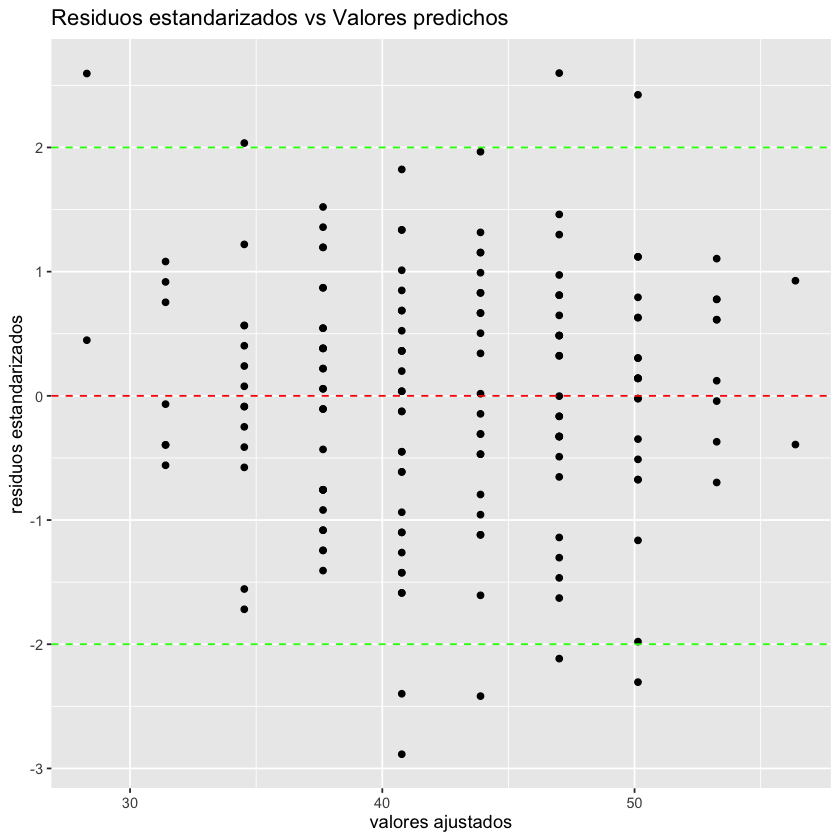

In [155]:
ggplot(data = datos_sin_o, aes(x = fitted(modelo_sin_o), y = rstandard(modelo_sin_o))) + 
    geom_point() + 
    geom_hline(yintercept = 0, linetype = "dashed", color = "red") + 
    geom_hline(yintercept = -2, linetype = "dashed", color = "green") +
    geom_hline(yintercept = 2, linetype = "dashed", color = "green") +
    labs(x = "valores ajustados", 
         y = "residuos estandarizados", 
         title = "Residuos estandarizados vs Valores predichos")

* Están distribuidos de una manera simétrica, pensando que el concepto de homogeneidad se cumple
* No se visualiza outlier 

#### Residuos vs. variable regresora (cal1)

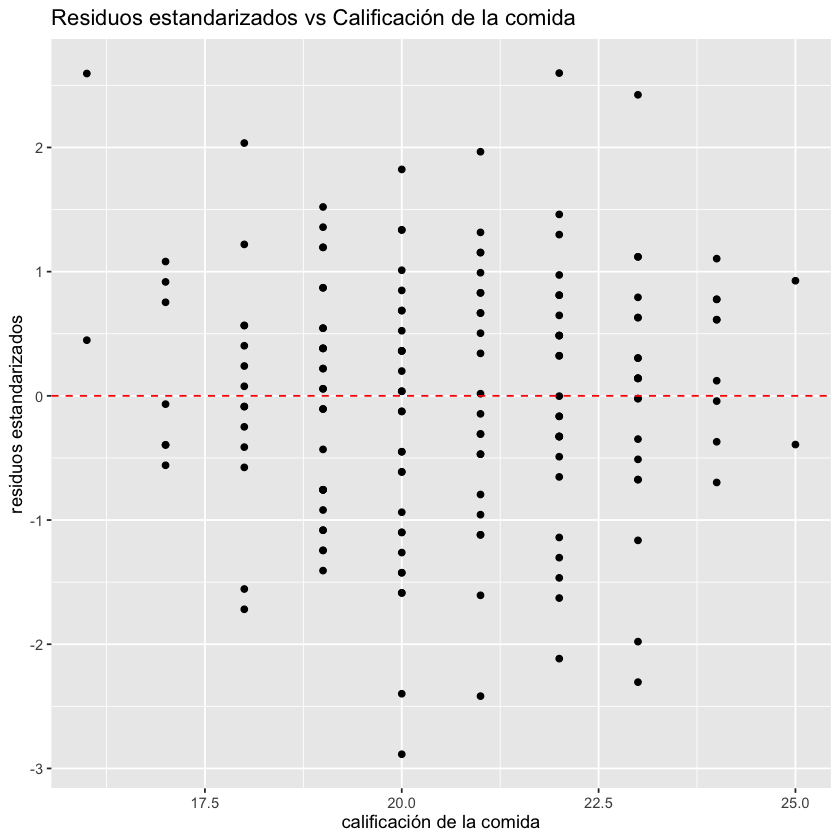

In [156]:
ggplot(data = datos_sin_o, aes(x = cal1, y = rstandard(modelo_sin_o))) + 
    geom_point() +
    geom_hline(yintercept = 0, linetype = "dashed", color = "red") +
    labs(x = "calificación de la comida", 
         y = "residuos estandarizados", 
         title = "Residuos estandarizados vs Calificación de la comida")

* En ambos gráficos no se ve una estructura clara; es decir, la distribución es aleatoria
* Se está validando el supuesto de homocedasticidad de los residuos

#### Normalidad de los residuos estandarizados

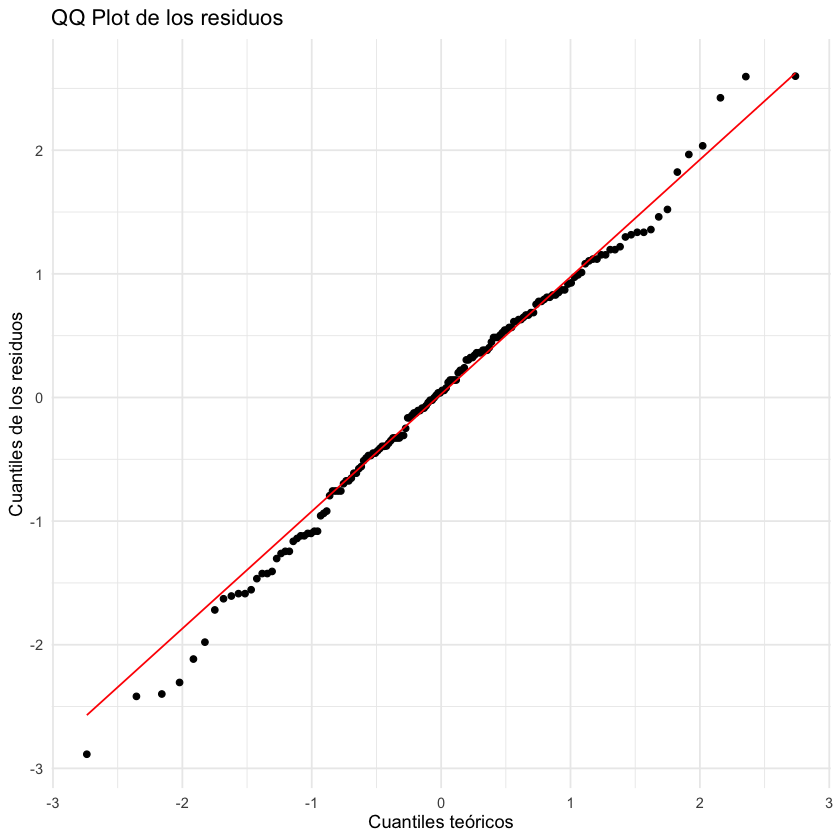

In [157]:
residuos_df_sin_o = data.frame(rstandard(modelo_sin_o))
ggplot(data = residuos_df_sin_o, aes(sample = rstandard(modelo_sin_o))) +
    stat_qq() +
    stat_qq_line(color = "red") +
    labs(title = "QQ Plot de los residuos", x = "Cuantiles teóricos", y = "Cuantiles de los residuos") +
    theme_minimal()

* Se valida el supuesto de normalidad; es decir, los errores se distribuyen normalmente

### Análisis de puntos influyentes

#### Detección de outliers

In [158]:
which(abs(rstandard(modelo_sin_o)) > 2)

7  49  91 122 127 134 136 140 160 
  7  49  91 122 127 134 136 140 160

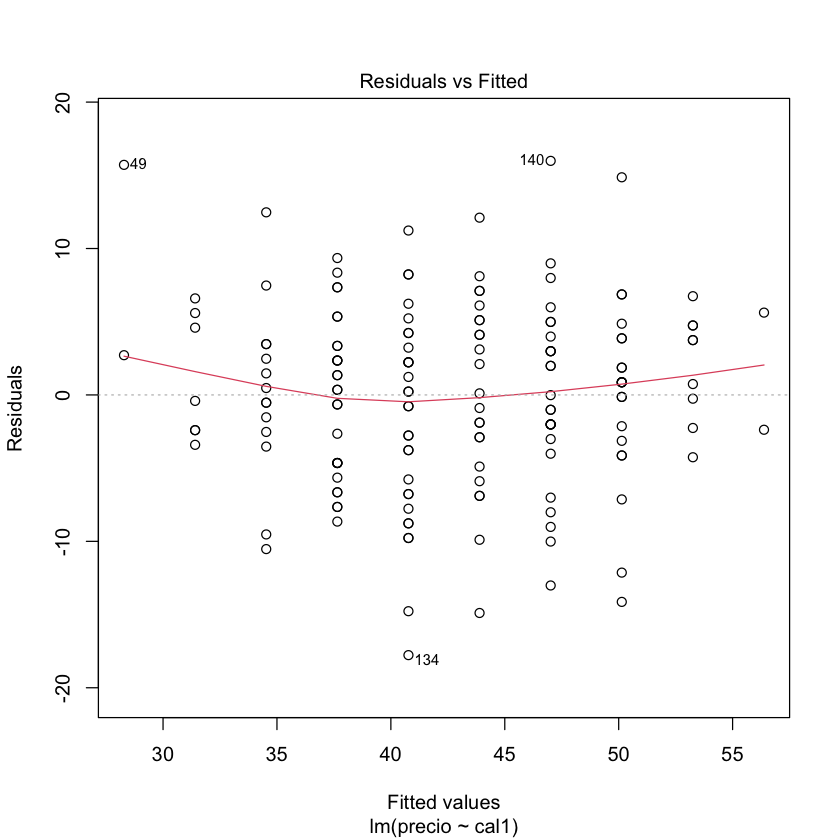

In [159]:
plot(modelo_sin_o, which = 1) # Residuos vs Predichos

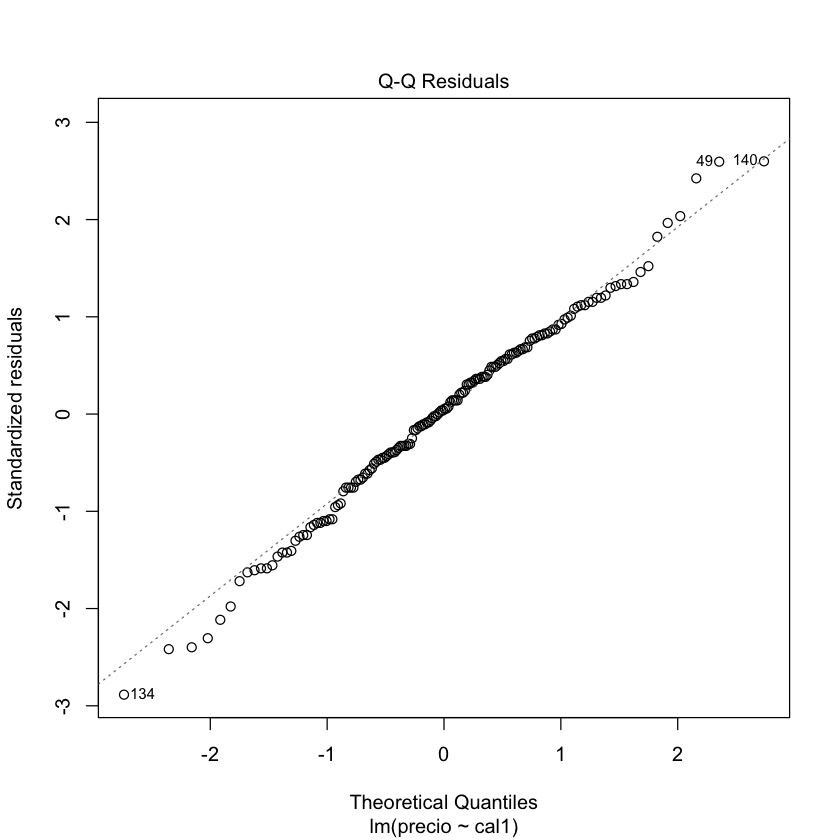

In [160]:
plot(modelo_sin_o, which = 2) # qqplot

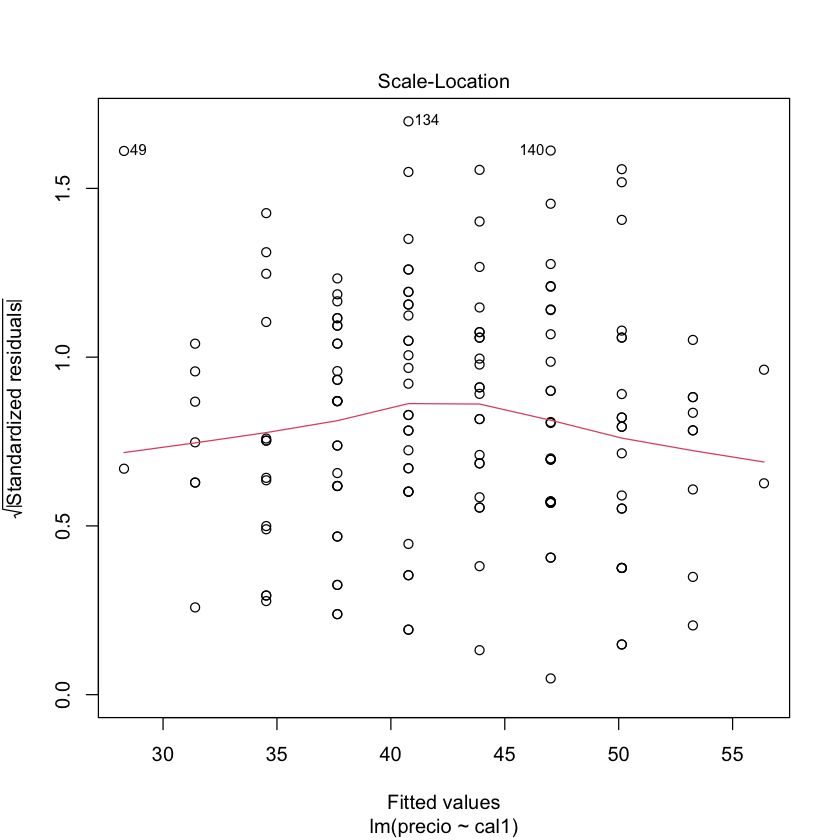

In [161]:
plot(modelo_sin_o, which = 3) # raiz cuadrada de los residuos estandarizados vs predichos

#### Detección de puntos de alto leverage

In [162]:
leverage <- hatvalues(modelo_sin_o)
p <- length(coef(modelo_sin_o))
umbral_lev <- 2 * p / length(datos_sin_o$cal1)
leverage[leverage > umbral_lev]

34         49         53         66         67         86        113 
0.03682096 0.04000314 0.02692085 0.02692085 0.02692085 0.03682096 0.02692085 
       119        150        154        159 
0.02692085 0.02692085 0.04000314 0.02692085

#### Distancia de Cook

In [163]:
cooks <- cooks.distance(modelo_sin_o)
p <- length(coef(modelo_sin_o))
n <- dim(datos_sin_o)[1]
cooks_umbral <- qf(0.5, p, n-p)
cooks[cooks > cooks_umbral]

named numeric(0)

* No hay observaciones con distancias de Cook que superen al umbral

## Conclusiones

In [164]:
summary(modelo)
summary(modelo_sin_o)


Call:
lm(formula = precio ~ cal1, data = datos)

Residuals:
     Min       1Q   Median       3Q      Max 
-17.6993  -4.1449   0.2736   3.8551  24.4366 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept) -29.0290     5.0432  -5.756 4.24e-08 ***
cal1          3.4864     0.2428  14.362  < 2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 6.496 on 161 degrees of freedom
Multiple R-squared:  0.5616,	Adjusted R-squared:  0.5589 
F-statistic: 206.3 on 1 and 161 DF,  p-value: < 2.2e-16



Call:
lm(formula = precio ~ cal1, data = datos_sin_o)

Residuals:
     Min       1Q   Median       3Q      Max 
-17.7715  -3.7715   0.2892   4.1071  15.9858 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept) -21.6558     5.1036  -4.243 3.72e-05 ***
cal1          3.1214     0.2465  12.663  < 2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 6.18 on 160 degrees of freedom
Multiple R-squared:  0.5006,	Adjusted R-squared:  0.4974 
F-statistic: 160.4 on 1 and 160 DF,  p-value: < 2.2e-16


* Variables significativas en ambos modelos
* En el caso sin outlier diminuye levemente el $R^2$
* El modelo sin outlier tiene un residual standard error levemente menor
* La observacion 163 al tener una distancia de cook que supera al umbral puede estar sobreajustando al modelo
* Me quedo con el modelo sin outlier

## 1.c) Scatter plot

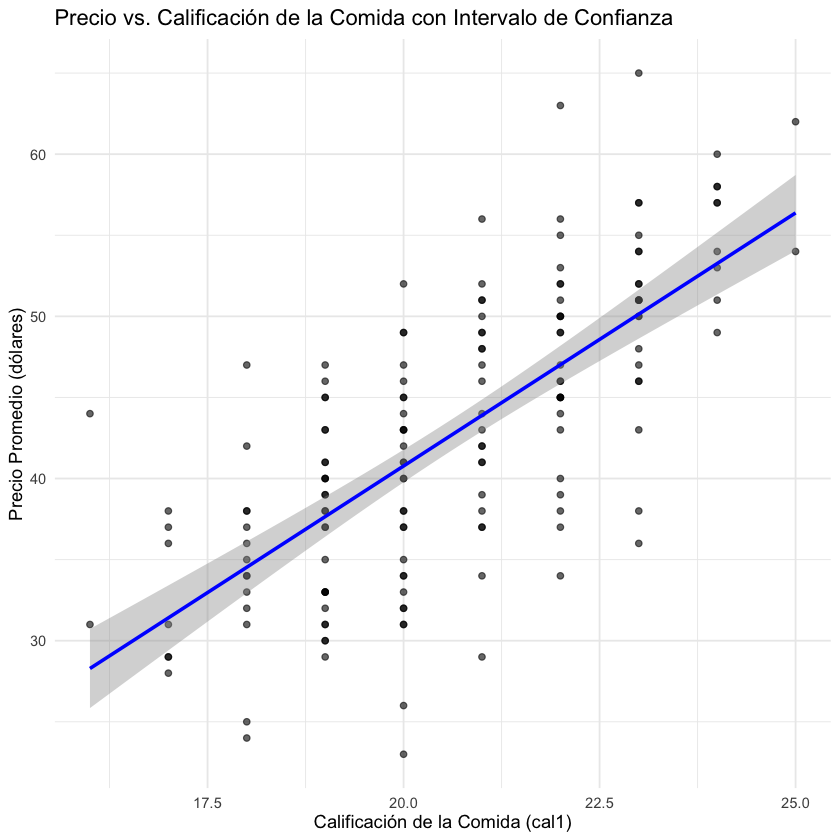

In [165]:
ggplot(data = datos_sin_o, aes(x = cal1, y = precio)) +
  geom_point(alpha = 0.6) + # Los puntos de los datos
  geom_smooth(method = "lm", formula=y~x, se = TRUE, level = 0.95, color = "blue") + # Recta de regresión y CI
  labs(title = "Precio vs. Calificación de la Comida con Intervalo de Confianza",
       x = "Calificación de la Comida (cal1)",
       y = "Precio Promedio (dólares)") +
  theme_minimal()

* Las bandas de confianza son estrechas, sugiere un buen ajuste del modelo
* El gráfico no solo valida la relación positiva y lineal entre ambas variables, sino que también cuantifica visualmente la confianza en las predicciones del precio medio, indicando que el modelo ajustado proporciona estimaciones más precisas en el rango central de las calificaciones de comida.

# Ejercicio 2
---

In [166]:
names(datos)

[1] "precio"   "cal1"     "decor"    "servicio" "lugar"    "cal2"

In [167]:
datos_sin_lugar <- datos[,-5]
datos_sin_lugar <- datos_sin_lugar[-163,]
names(datos_sin_lugar)

[1] "precio"   "cal1"     "decor"    "servicio" "cal2"

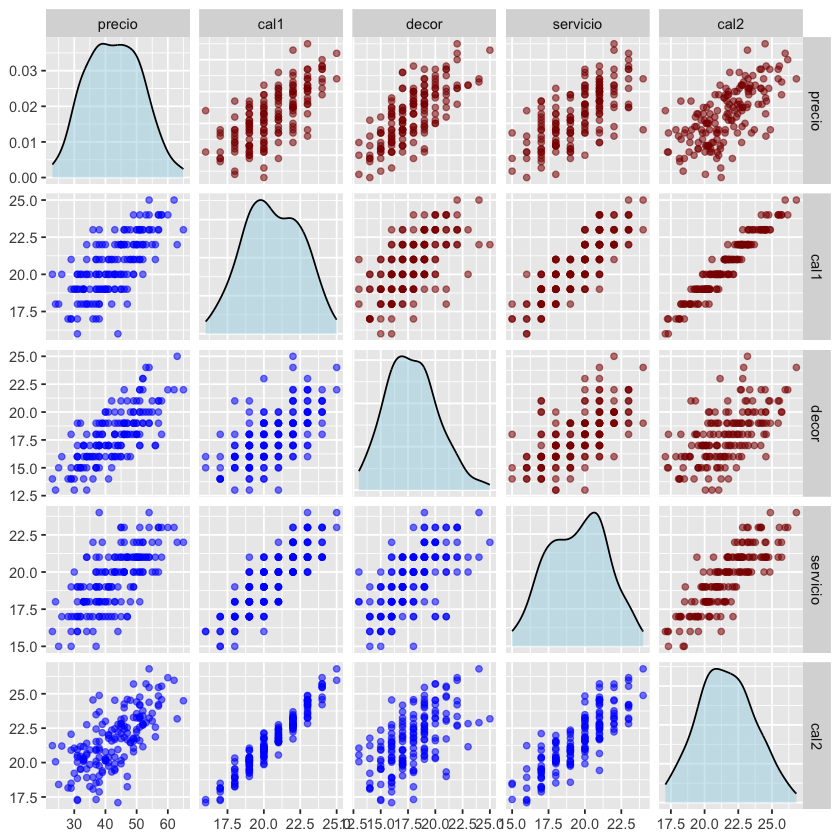

In [168]:
# Gráfico de dispersión entre las variables precio, cal1, decor, servicio, cal2
ggpairs(datos_sin_lugar,
        mapping = aes(alpha = 0.9),
        upper = list(continuous = wrap("points", color = "darkred")),
        lower = list(continuous = wrap("points", color = "blue")),
        diag = list(continuous = wrap("densityDiag", fill = "lightblue")))

* Estos gráficos nos permite investigar las diversas relaciones marginales entre la variable respuesta (precio) y los predictores. La variable precio parece estar estrechamente relacionada con todas las variables
* Además, se observa relaciones de linealidad entre algunas variables predictoras

* La siguiente matriz de correlación:

In [ ]:
round(cor(datos_sin_lugar), 2)

Se observa:
* una moderada/alta correlación entre precio y las variables predictoras

**La alta correlación entre algunos predictores sugiere que existe multicolinealidad basada en datos**
* Esto significa que una de las dos es redundante, porque una no aporta

### Modelo

In [169]:
modelo_sin_lugar <- lm(precio ~ ., data = datos_sin_lugar)
summary(modelo_sin_lugar)


Call:
lm(formula = precio ~ ., data = datos_sin_lugar)

Residuals:
    Min      1Q  Median      3Q     Max 
-14.092  -3.242  -0.017   3.907  13.854 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept) -26.0794     4.4366  -5.878 2.41e-08 ***
cal1          1.9870     0.8607   2.309   0.0223 *  
decor         1.6565     0.2310   7.172 2.74e-11 ***
servicio      0.5927     0.3979   1.489   0.1384    
cal2         -0.6180     0.7946  -0.778   0.4379    
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 5.262 on 157 degrees of freedom
Multiple R-squared:  0.6447,	Adjusted R-squared:  0.6356 
F-statistic: 71.21 on 4 and 157 DF,  p-value: < 2.2e-16


* Pvalue chicos => los estimados son significativas, excepto servicio y cal2 (pvalor > 0.05)
* $R^2$ representa la explicabilidad del modelo, este modelo explica el 64% de los casos y es similar al $R^2$ ajustado lo que representa un buen ajuste del modelo
* p-value del F-statistic es chico, representa que el modelo es globalmente significativo 

### Validación de los supuestos

#### Residuos vs. valores ajustados

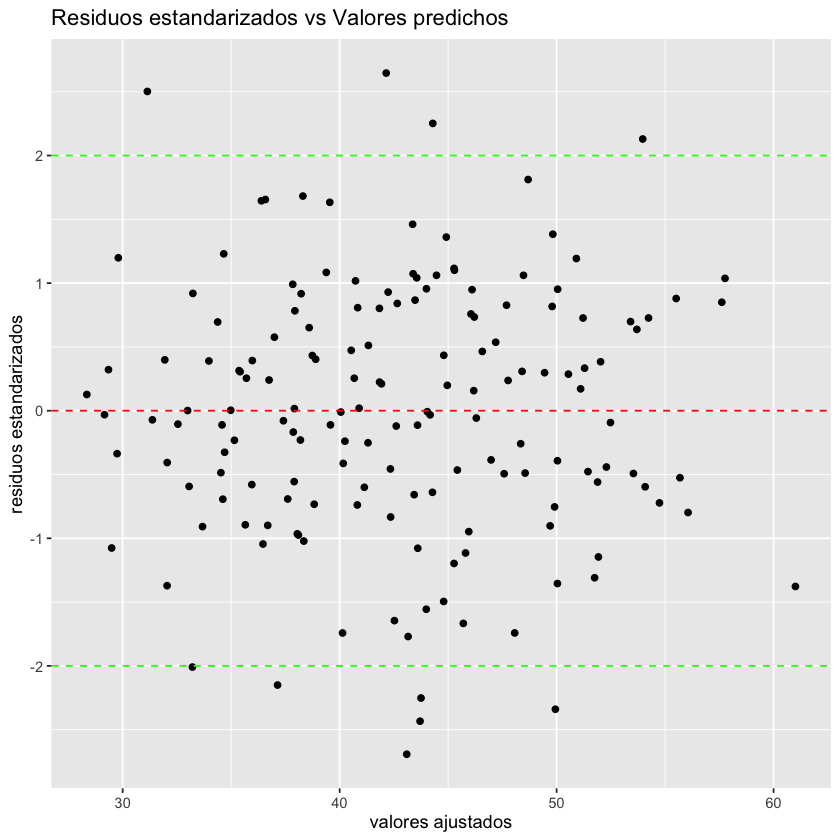

In [170]:
ggplot(data = datos_sin_lugar, aes(x = fitted(modelo_sin_lugar), y = rstandard(modelo_sin_lugar))) + 
    geom_point() + 
    geom_hline(yintercept = 0, linetype = "dashed", color = "red") + 
    geom_hline(yintercept = -2, linetype = "dashed", color = "green") +
    geom_hline(yintercept = 2, linetype = "dashed", color = "green") +
    labs(x = "valores ajustados", 
         y = "residuos estandarizados", 
         title = "Residuos estandarizados vs Valores predichos")

* Están distribuidos aleatoriamente de una manera simétrica en ralación 0, pensando que el concepto de homogeneidad se cumple

#### Residuos vs. variables regresoras

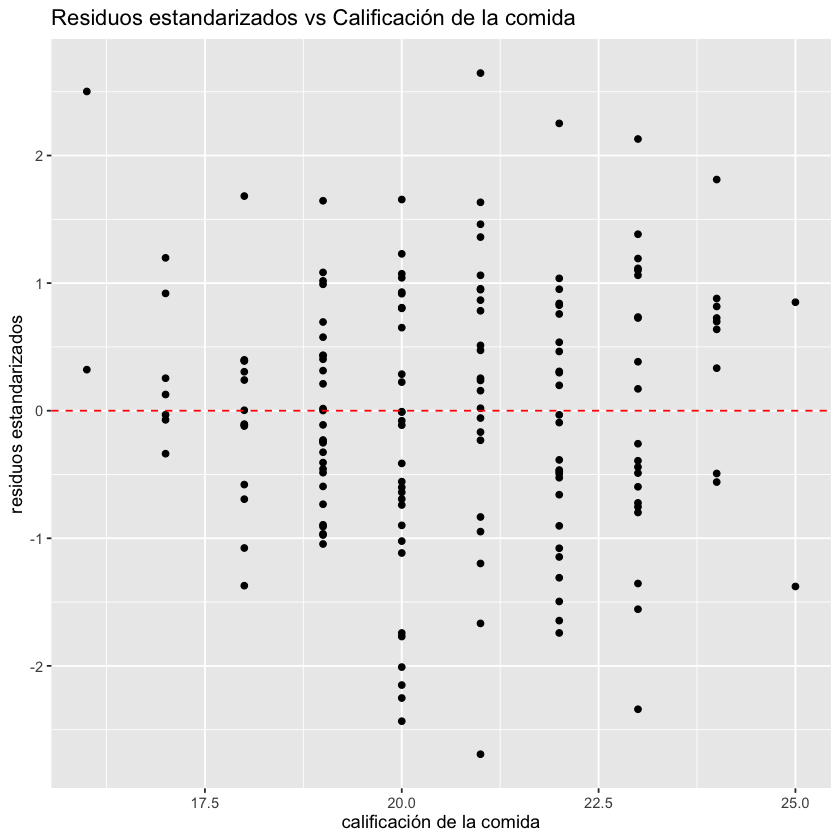

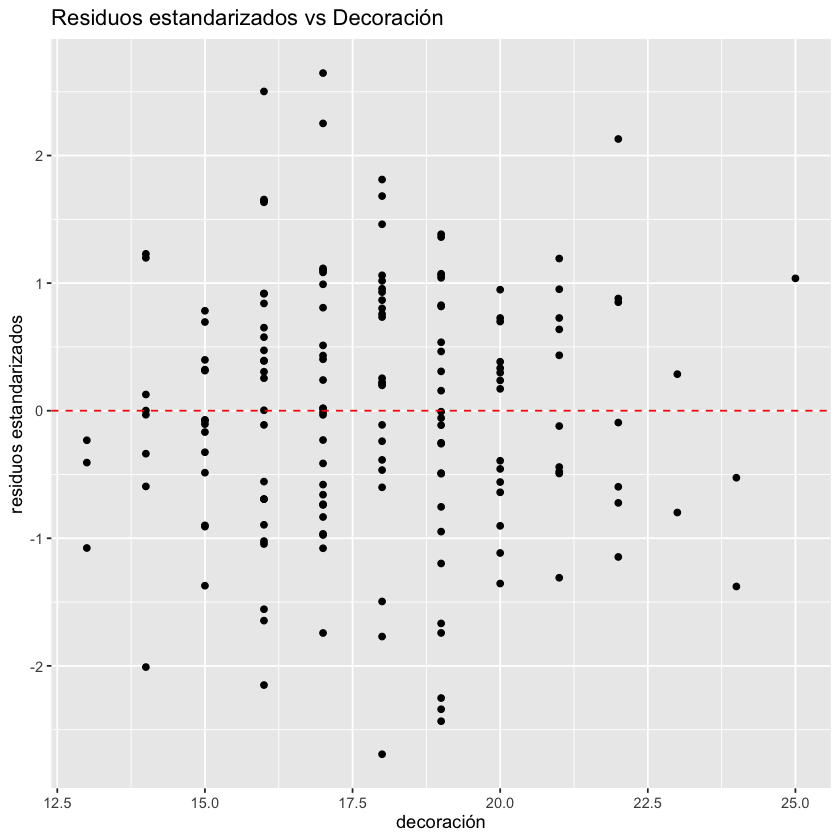

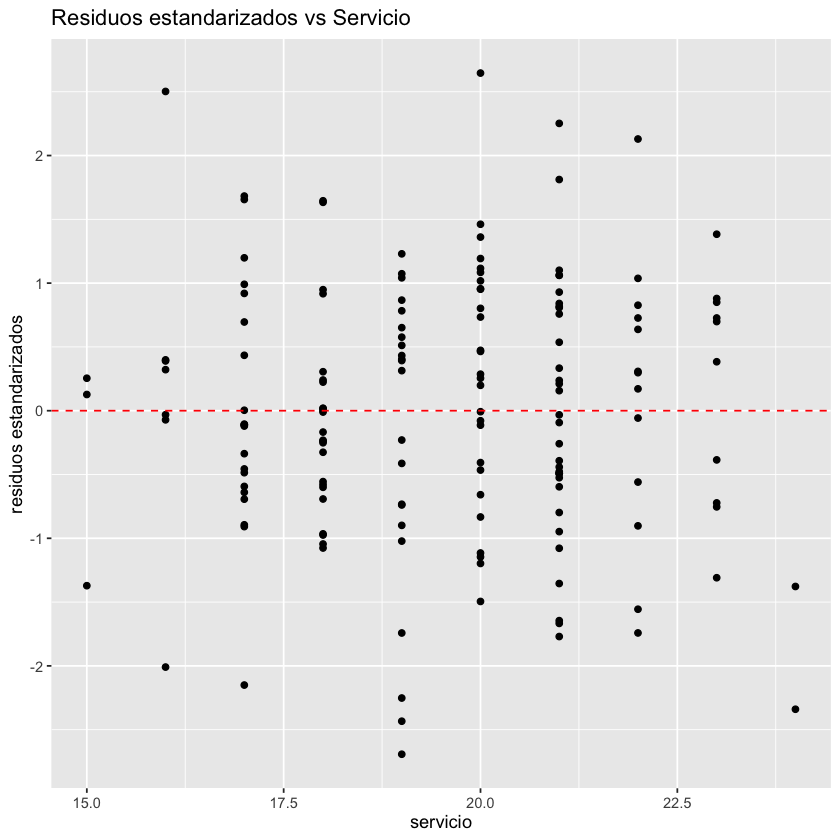

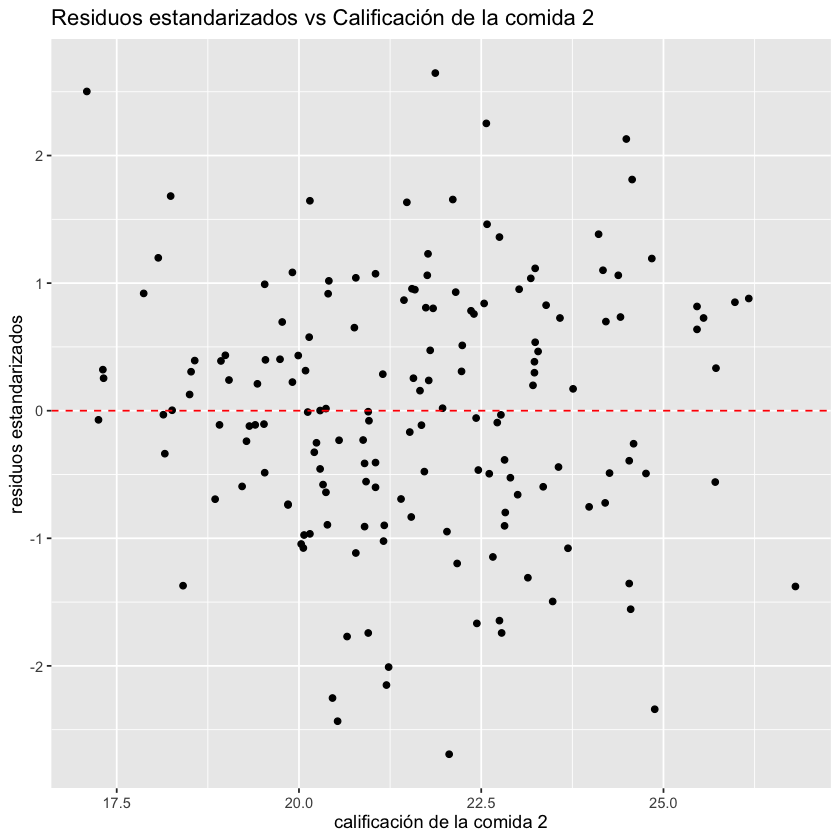

In [171]:
ggplot(data = datos_sin_lugar, aes(x = cal1, y = rstandard(modelo_sin_lugar))) + 
    geom_point() +
    geom_hline(yintercept = 0, linetype = "dashed", color = "red") +
    labs(x = "calificación de la comida", 
         y = "residuos estandarizados", 
         title = "Residuos estandarizados vs Calificación de la comida")

ggplot(data = datos_sin_lugar, aes(x = decor, y = rstandard(modelo_sin_lugar))) + 
    geom_point() +
    geom_hline(yintercept = 0, linetype = "dashed", color = "red") +
    labs(x = "decoración", 
         y = "residuos estandarizados", 
         title = "Residuos estandarizados vs Decoración")

ggplot(data = datos_sin_lugar, aes(x = servicio, y = rstandard(modelo_sin_lugar))) + 
    geom_point() +
    geom_hline(yintercept = 0, linetype = "dashed", color = "red") +
    labs(x = "servicio", 
         y = "residuos estandarizados", 
         title = "Residuos estandarizados vs Servicio")

ggplot(data = datos_sin_lugar, aes(x = cal2, y = rstandard(modelo_sin_lugar))) + 
    geom_point() +
    geom_hline(yintercept = 0, linetype = "dashed", color = "red") +
    labs(x = "calificación de la comida 2", 
         y = "residuos estandarizados", 
         title = "Residuos estandarizados vs Calificación de la comida 2")

* En los gráficos no se ve una estructura clara; es decir, la distribución es aleatoria
* Se está validando el supuesto de homocedasticidad de los residuos

#### Normalidad de los residuos estandarizados

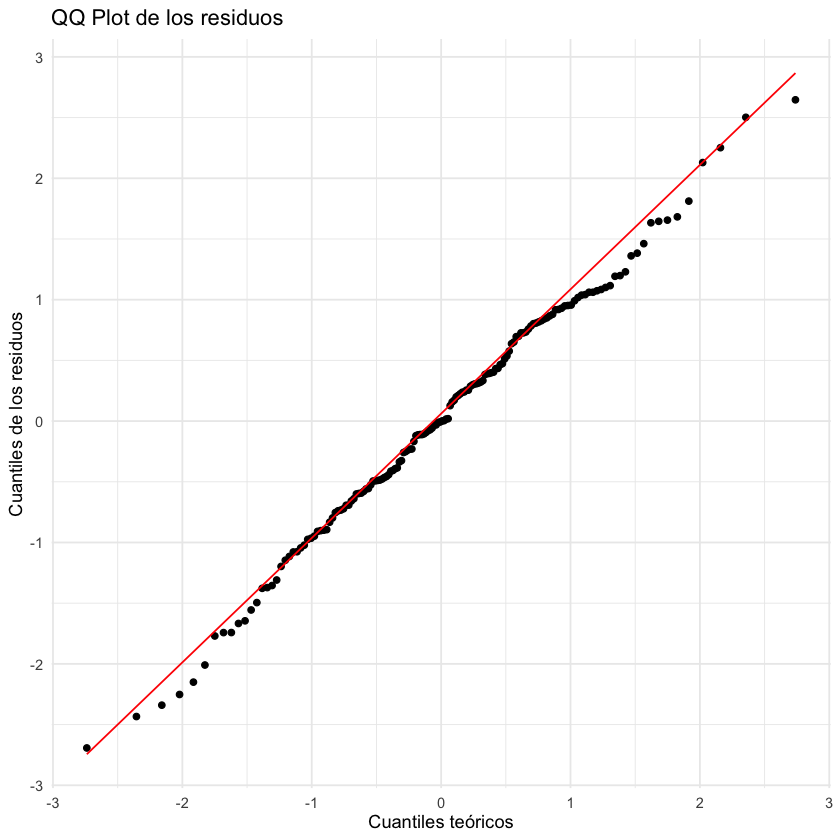

In [172]:
residuos_df_sin_lugar = data.frame(rstandard(modelo_sin_lugar))
ggplot(data = residuos_df_sin_lugar, aes(sample = rstandard(modelo_sin_lugar))) +
    stat_qq() +
    stat_qq_line(color = "red") +
    labs(title = "QQ Plot de los residuos", x = "Cuantiles teóricos", y = "Cuantiles de los residuos") +
    theme_minimal()

* Se valida el supuesto de normalidad; es decir, los errores se distribuyen normalmente

### Análisis de puntos influyentes

#### Detección de outliers

In [173]:
which(abs(rstandard(modelo_sin_lugar)) > 2)


2  44  47  49  81 107 127 134 136 160 
  2  44  47  49  81 107 127 134 136 160

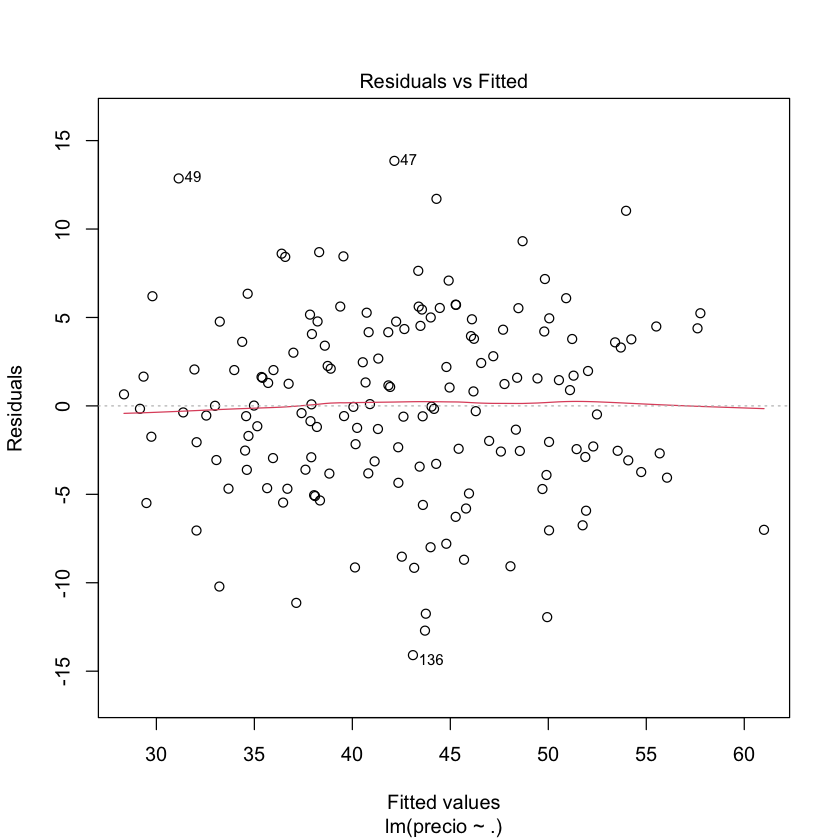

In [174]:
plot(modelo_sin_lugar, which = 1) # Residuos vs Predichos

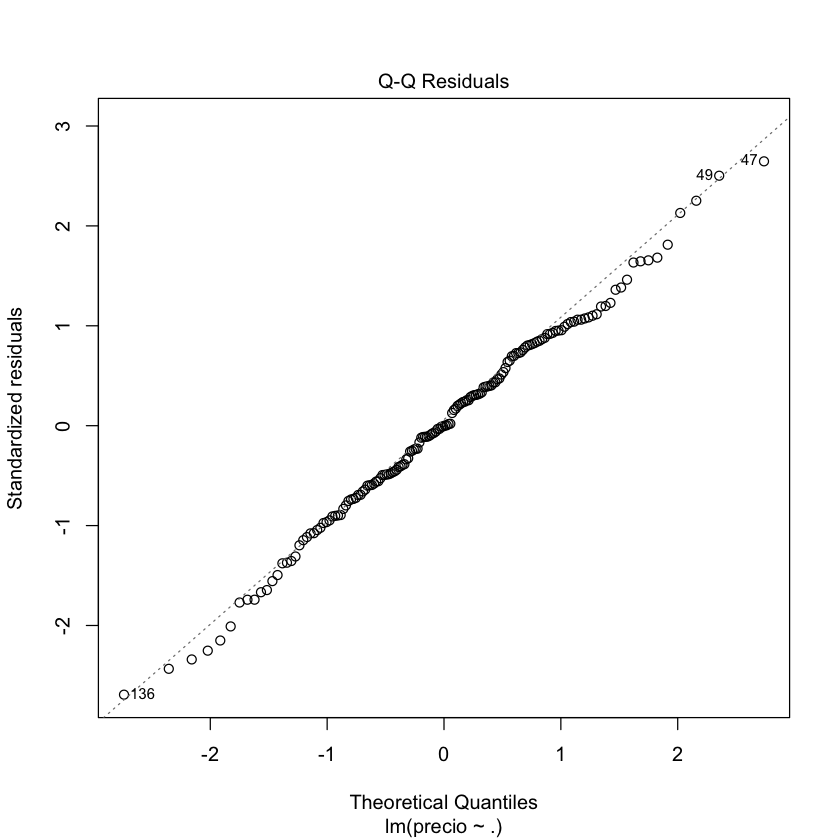

In [175]:
plot(modelo_sin_lugar, which = 2) # qqplot

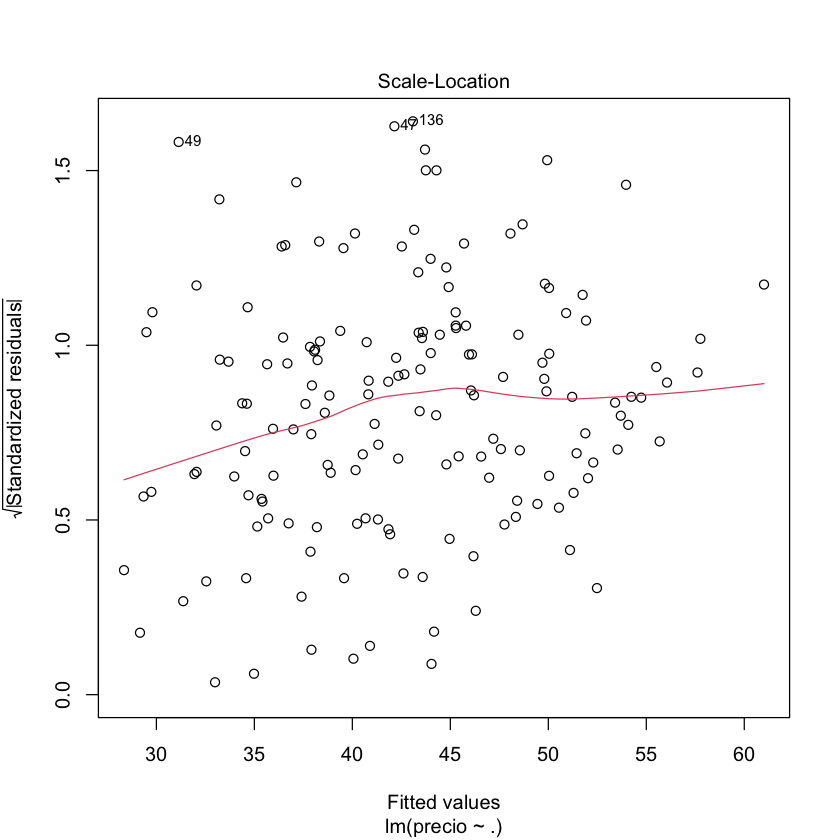

In [176]:
plot(modelo_sin_lugar, which = 3) # raiz cuadrada de los residuos estandarizados vs predichos

#### Detección de puntos de alto leverage

In [177]:
leverage <- hatvalues(modelo_sin_lugar)
p <- length(coef(modelo_sin_lugar))
umbral_lev <- 2 * p / length(datos_sin_lugar$cal1)
leverage[leverage > umbral_lev]

3         67         76         86         95         99        100 
0.10935869 0.06256094 0.06202625 0.06569434 0.07940036 0.06733034 0.06454086 
       120        126        134        135        140        141 
0.06507913 0.07274530 0.06679899 0.07573525 0.07869346 0.06563440

#### Distancia de Cook

In [178]:
cooks <- cooks.distance(modelo_sin_lugar)
p <- length(coef(modelo_sin_lugar))
n <- dim(datos_sin_lugar)[1]
cooks_umbral <- qf(0.5, p, n-p)
cooks[cooks > cooks_umbral]

named numeric(0)

* No se detecta ninguna observación que supere el umbral de Cook

### Factor de inflación de la varianza

In [179]:
vif(modelo_sin_lugar)

cal1     decor  servicio      cal2 
16.814148  1.755385  3.788559 15.780815

* Detectamos muticolinealidad entre las variables cal1 y cal2

In [180]:
modelo1 <- lm(precio ~ cal1 + decor + servicio, data = datos_sin_lugar)
summary(modelo1)


Call:
lm(formula = precio ~ cal1 + decor + servicio, data = datos_sin_lugar)

Residuals:
     Min       1Q   Median       3Q      Max 
-14.1752  -3.3003   0.0362   3.8184  13.9664 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept) -26.4651     4.4033  -6.010 1.23e-08 ***
cal1          1.3952     0.4018   3.472 0.000665 ***
decor         1.6765     0.2293   7.313 1.23e-11 ***
servicio      0.5349     0.3904   1.370 0.172635    
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 5.255 on 158 degrees of freedom
Multiple R-squared:  0.6433,	Adjusted R-squared:  0.6365 
F-statistic: 94.98 on 3 and 158 DF,  p-value: < 2.2e-16


In [181]:
modelo2 <- lm(precio ~ cal2 + decor + servicio, data = datos_sin_lugar)
summary(modelo2)


Call:
lm(formula = precio ~ cal2 + decor + servicio, data = datos_sin_lugar)

Residuals:
     Min       1Q   Median       3Q      Max 
-13.9884  -3.2339   0.3772   3.8004  14.2156 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept) -25.3153     4.4845  -5.645 7.47e-08 ***
cal2          1.0037     0.3765   2.666  0.00847 ** 
decor         1.7680     0.2290   7.722 1.23e-12 ***
servicio      0.7546     0.3970   1.901  0.05916 .  
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 5.334 on 158 degrees of freedom
Multiple R-squared:  0.6326,	Adjusted R-squared:  0.6256 
F-statistic: 90.68 on 3 and 158 DF,  p-value: < 2.2e-16


In [182]:
modelo3 <- lm(precio ~ cal1 + decor, data = datos_sin_lugar)
summary(modelo3)


Call:
lm(formula = precio ~ cal1 + decor, data = datos_sin_lugar)

Residuals:
     Min       1Q   Median       3Q      Max 
-14.6182  -3.4218   0.1376   3.8451  14.1300 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept) -25.7431     4.3837  -5.872 2.43e-08 ***
cal1          1.8045     0.2695   6.696 3.49e-10 ***
decor         1.7482     0.2238   7.811 7.24e-13 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 5.27 on 159 degrees of freedom
Multiple R-squared:  0.639,	Adjusted R-squared:  0.6345 
F-statistic: 140.8 on 2 and 159 DF,  p-value: < 2.2e-16


In [183]:
modelo4 <- lm(precio ~ cal2 + decor, data = datos_sin_lugar)
summary(modelo4)


Call:
lm(formula = precio ~ cal2 + decor, data = datos_sin_lugar)

Residuals:
     Min       1Q   Median       3Q      Max 
-14.6343  -3.2748   0.2009   3.5838  14.5523 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept) -24.3678     4.4931  -5.423 2.14e-07 ***
cal2          1.5366     0.2534   6.065 9.28e-09 ***
decor         1.8947     0.2208   8.581 8.06e-15 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 5.377 on 159 degrees of freedom
Multiple R-squared:  0.6242,	Adjusted R-squared:  0.6195 
F-statistic:   132 on 2 and 159 DF,  p-value: < 2.2e-16


In [184]:
modelo5 <- lm(precio ~ servicio + decor, data = datos_sin_lugar)
summary(modelo5)


Call:
lm(formula = precio ~ servicio + decor, data = datos_sin_lugar)

Residuals:
     Min       1Q   Median       3Q      Max 
-13.7218  -3.3039  -0.2302   3.6903  14.1811 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept) -20.7564     4.2245  -4.913 2.21e-06 ***
servicio      1.5428     0.2701   5.713 5.33e-08 ***
decor         1.8658     0.2303   8.102 1.34e-13 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 5.435 on 159 degrees of freedom
Multiple R-squared:  0.6161,	Adjusted R-squared:  0.6112 
F-statistic: 127.6 on 2 and 159 DF,  p-value: < 2.2e-16


In [185]:
vif(modelo1)
vif(modelo2)
vif(modelo3)
vif(modelo4)
vif(modelo5)

cal1    decor servicio 
3.673785 1.733579 3.656385

cal2    decor servicio 
3.448008 1.678712 3.670849

cal1    decor 
1.643329 1.643329

cal2    decor 
1.536259 1.536259

servicio    decor 
1.635546 1.635546

Se analizaron distintos modelos combinando las variables regresoras y se observa que los mejores indicadoras (R2 ajustado, siginificancias de las variables regresoras, el pvalor del estadistico F y el vif) están asociados a los siguiente modelos:
* modelo3
* modelo4
* modelo5

## Selección de variables y validación cruzada

In [186]:
cant.var = length(modelo_sin_lugar$coefficients) - 1
cant.var

[1] 4

In [187]:
# División 80/20
set.seed(12)
train_index <- createDataPartition(datos_sin_lugar$precio, p = 0.8, list = FALSE)
train_data <- datos_sin_lugar[train_index, ]
test_data <- datos_sin_lugar[-train_index, ]

In [188]:
# Elijo variables sobre el 80% de los datos
# Ajuste de modelos con regsubsets
# por default hace el metodo exhaustivo. Opciones: method="backward" o method="fordward")

# metodo exhaustivo
datos.regsub <- regsubsets(precio ~ ., data = train_data, nvmax = cant.var) # por default es exhaustivo
resumen <- summary(datos.regsub)

In [189]:
# Crear tabla resumen
tabla <- data.frame(
  Variables = 1:cant.var,
  R2_ajustado = resumen$adjr2,
  BIC = resumen$bic
)

knitr::kable(tabla, digits = 3)



| Variables| R2_ajustado|      BIC|
|---------:|-----------:|--------:|
|         1|       0.552|  -96.462|
|         2|       0.649| -124.380|
|         3|       0.658| -124.154|
|         4|       0.658| -120.213|

In [190]:
# Identificar el mejor modelo según cada criterio
mejor_R2 <- which.max(resumen$adjr2)
mejor_BIC <- which.min(resumen$bic)

cat("Mejor R2 ajustado →", mejor_R2, "variables\n")
cat("Mejor BIC         →", mejor_BIC, "variables\n")

Mejor R2 ajustado → 3 variables
Mejor BIC         → 2 variables


### Modelo BIC

In [191]:
# Control de validación cruzada 5-fold en el conjunto de entrenamiento
variables_bic <- names(coef(datos.regsub, mejor_BIC))[-1]  # quitamos intercept
variables_bic

formula_bic <- as.formula(paste("precio ~", paste(variables_bic, collapse = "+")))
formula_bic

control <- trainControl(method = "cv", number = 5)

# Entrenar modelo lineal con validación cruzada en train_data
cv.bic <- train(formula_bic, data = train_data, method = "lm", trControl = control)

# Resultados entrenamiento con CV
cv.bic

[1] "cal1"  "decor"

precio ~ cal1 + decor

Linear Regression 

131 samples
  2 predictor

No pre-processing
Resampling: Cross-Validated (5 fold) 
Summary of sample sizes: 104, 105, 105, 105, 105 
Resampling results:

  RMSE      Rsquared   MAE     
  5.322902  0.6812345  4.311216

Tuning parameter 'intercept' was held constant at a value of TRUE

### Modelo R2

In [192]:
variables_R2 <- names(coef(datos.regsub, mejor_R2))[-1]  # quitamos intercept
variables_R2

formula_R2 <- as.formula(paste("precio ~", paste(variables_R2, collapse = "+")))
formula_R2
control <- trainControl(method = "cv", number = 5)

# Entrenar modelo lineal con validación cruzada en train_data
cv.R2 <- train(formula_R2, data = train_data, method = "lm", trControl = control)

# Resultados entrenamiento con CV
cv.R2

[1] "cal1"     "decor"    "servicio"

precio ~ cal1 + decor + servicio

Linear Regression 

131 samples
  3 predictor

No pre-processing
Resampling: Cross-Validated (5 fold) 
Summary of sample sizes: 104, 106, 105, 106, 103 
Resampling results:

  RMSE      Rsquared   MAE     
  5.106422  0.6633805  4.109731

Tuning parameter 'intercept' was held constant at a value of TRUE

In [193]:
modelo_bic <- lm(precio ~ cal1 + decor, data = datos_sin_lugar)
modelo_r2 <- lm(precio ~ cal1 + decor + servicio, data = datos_sin_lugar)

summary(modelo_bic)
summary(modelo_r2)


Call:
lm(formula = precio ~ cal1 + decor, data = datos_sin_lugar)

Residuals:
     Min       1Q   Median       3Q      Max 
-14.6182  -3.4218   0.1376   3.8451  14.1300 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept) -25.7431     4.3837  -5.872 2.43e-08 ***
cal1          1.8045     0.2695   6.696 3.49e-10 ***
decor         1.7482     0.2238   7.811 7.24e-13 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 5.27 on 159 degrees of freedom
Multiple R-squared:  0.639,	Adjusted R-squared:  0.6345 
F-statistic: 140.8 on 2 and 159 DF,  p-value: < 2.2e-16



Call:
lm(formula = precio ~ cal1 + decor + servicio, data = datos_sin_lugar)

Residuals:
     Min       1Q   Median       3Q      Max 
-14.1752  -3.3003   0.0362   3.8184  13.9664 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept) -26.4651     4.4033  -6.010 1.23e-08 ***
cal1          1.3952     0.4018   3.472 0.000665 ***
decor         1.6765     0.2293   7.313 1.23e-11 ***
servicio      0.5349     0.3904   1.370 0.172635    
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 5.255 on 158 degrees of freedom
Multiple R-squared:  0.6433,	Adjusted R-squared:  0.6365 
F-statistic: 94.98 on 3 and 158 DF,  p-value: < 2.2e-16


* Se observa que en el modelo R2 la variable servicio no es significativa
* R^2 de ambos modelos son similares
* Se concluye, que como el modelo BIC es mas simple (menos variable = parsimonioso), se lo elije

### Validación de los supuestos

#### Residuos vs. valores ajustados

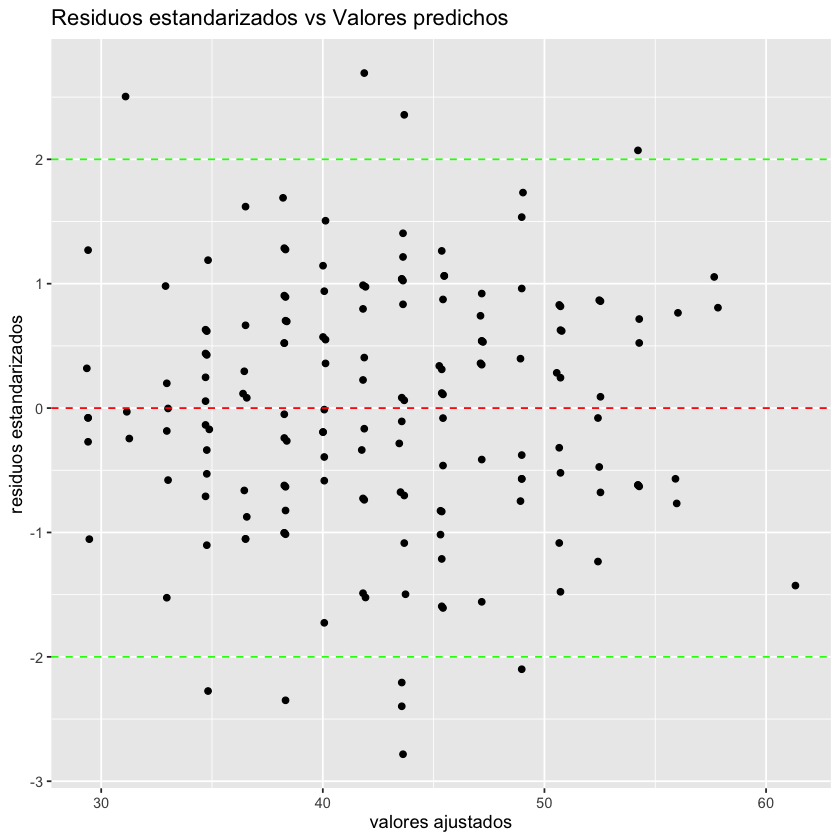

In [194]:
ggplot(data = datos_sin_lugar, aes(x = fitted(modelo_bic), y = rstandard(modelo_bic))) + 
    geom_point() + 
    geom_hline(yintercept = 0, linetype = "dashed", color = "red") + 
    geom_hline(yintercept = -2, linetype = "dashed", color = "green") +
    geom_hline(yintercept = 2, linetype = "dashed", color = "green") +
    labs(x = "valores ajustados", 
         y = "residuos estandarizados", 
         title = "Residuos estandarizados vs Valores predichos")

* Están distribuidos de una manera simétrica, pensando que el concepto de homogeneidad se cumple

#### Residuos vs. variable regresora

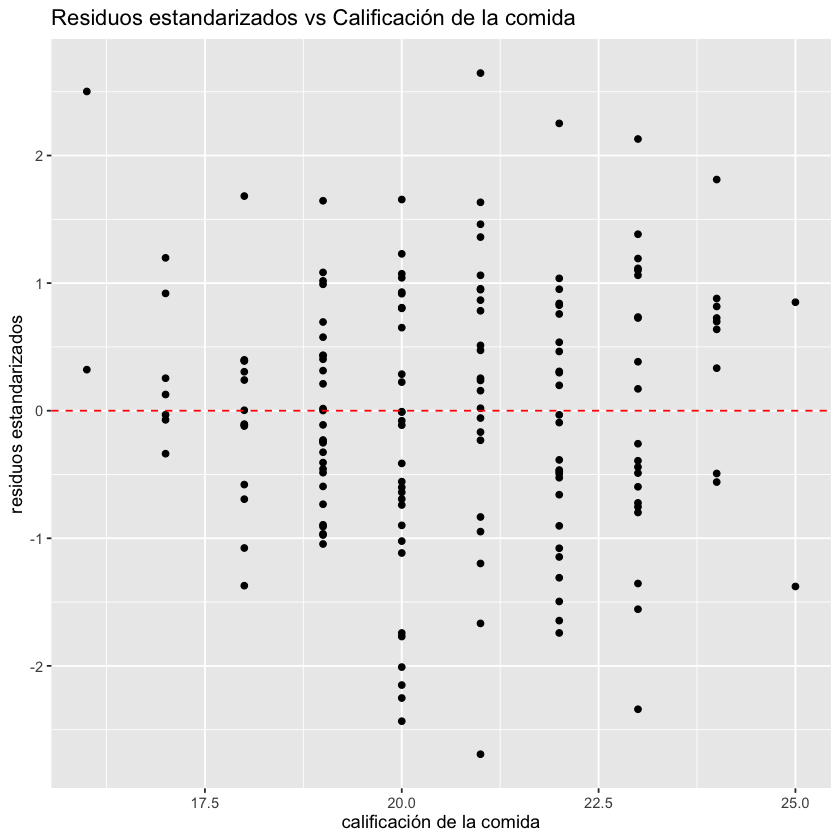

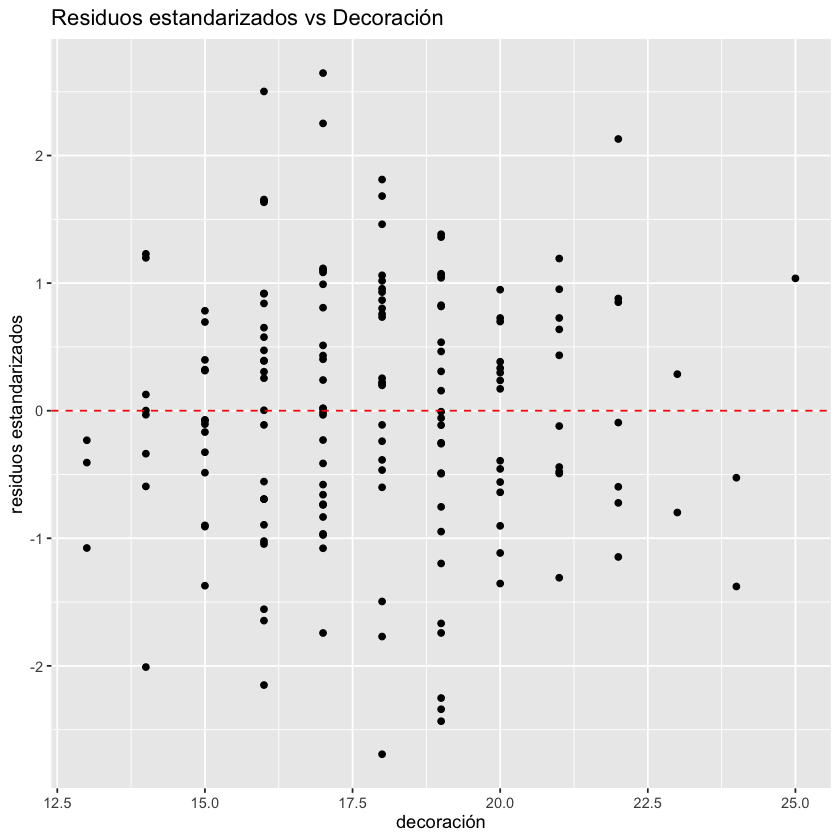

In [195]:
ggplot(data = datos_sin_lugar, aes(x = cal1, y = rstandard(modelo_sin_lugar))) + 
    geom_point() +
    geom_hline(yintercept = 0, linetype = "dashed", color = "red") +
    labs(x = "calificación de la comida", 
         y = "residuos estandarizados", 
         title = "Residuos estandarizados vs Calificación de la comida")

ggplot(data = datos_sin_lugar, aes(x = decor, y = rstandard(modelo_sin_lugar))) + 
    geom_point() +
    geom_hline(yintercept = 0, linetype = "dashed", color = "red") +
    labs(x = "decoración", 
         y = "residuos estandarizados", 
         title = "Residuos estandarizados vs Decoración")

* En ambos gráficos no se ve una estructura clara; es decir, la distribución es aleatoria
* Se está validando el supuesto de homocedasticidad de los residuos

#### Normalidad de los residuos estandarizados

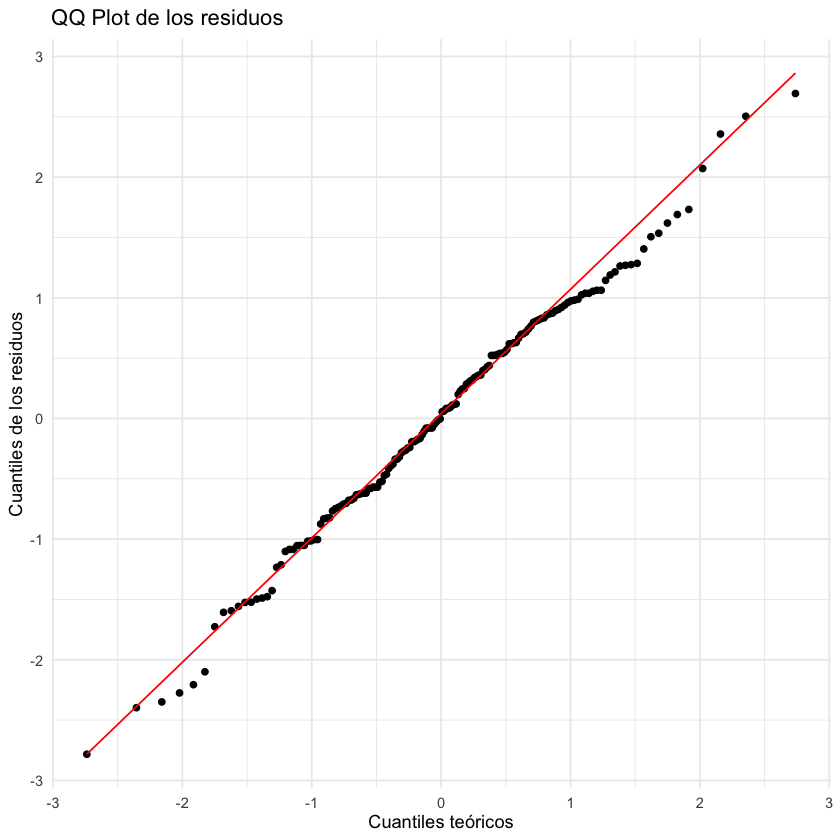

In [196]:
residuos_df_bic = data.frame(rstandard(modelo_bic))
ggplot(data = residuos_df_bic, aes(sample = rstandard(modelo_bic))) +
    stat_qq() +
    stat_qq_line(color = "red") +
    labs(title = "QQ Plot de los residuos", x = "Cuantiles teóricos", y = "Cuantiles de los residuos") +
    theme_minimal()

* Se valida el supuesto de normalidad; es decir, los errores se distribuyen normalmente

# Ejercicio 3
---

In [197]:
names(datos)

[1] "precio"   "cal1"     "decor"    "servicio" "lugar"    "cal2"

In [198]:
datos_con_lugar <- datos[,-c(3, 4, 6)]
datos_con_lugar <- datos_con_lugar[-163,]
names(datos_con_lugar)

[1] "precio" "cal1"   "lugar"

In [199]:
# Visualización de tipos de datos
str(datos_con_lugar)

'data.frame':	162 obs. of  3 variables:
 $ precio: int  43 32 34 41 54 52 34 34 39 44 ...
 $ cal1  : int  22 20 21 20 24 22 22 20 22 21 ...
 $ lugar : int  0 0 0 0 0 0 0 1 1 1 ...


* Observación: la variable predictora lugar es una variable categórica con dos niveles: 0 y 1. Ambas de tipo int. Es conveniente convertirla a variable tipo factor

In [200]:
datos_con_lugar$lugar = factor(datos_con_lugar$lugar)
str(datos_con_lugar)

'data.frame':	162 obs. of  3 variables:
 $ precio: int  43 32 34 41 54 52 34 34 39 44 ...
 $ cal1  : int  22 20 21 20 24 22 22 20 22 21 ...
 $ lugar : Factor w/ 2 levels "0","1": 1 1 1 1 1 1 1 2 2 2 ...


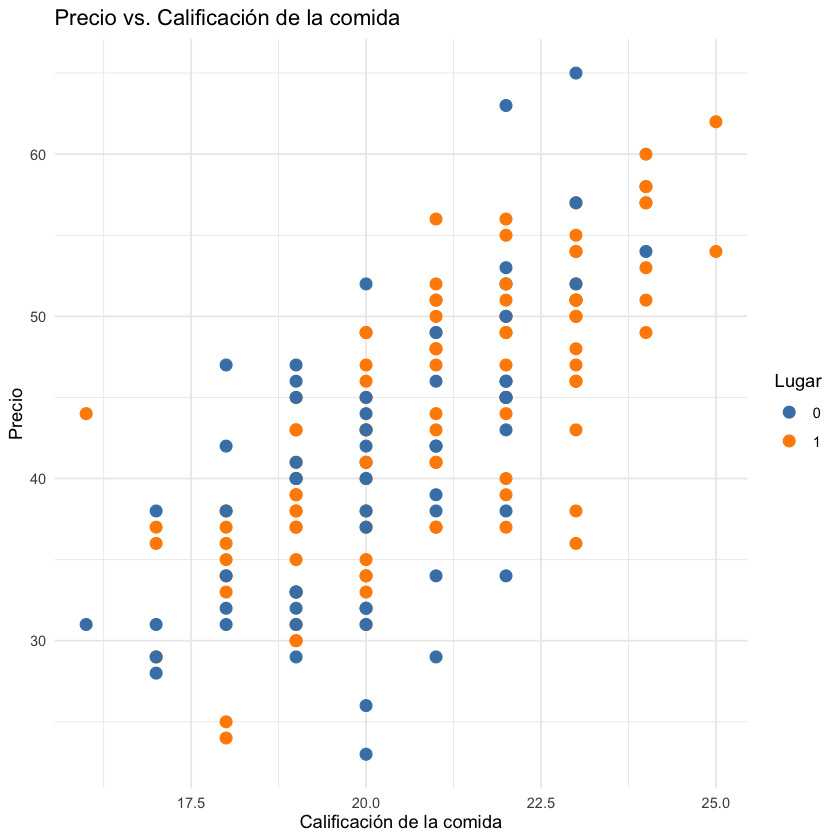

In [201]:
ggplot(datos_con_lugar, aes(x = cal1, y = precio, color = lugar)) +
  geom_point(size = 3) +
  labs(
    title = "Precio vs. Calificación de la comida",
    x = "Calificación de la comida",
    y = "Precio",
    color = "Lugar"
  ) +
  theme_minimal() +
  scale_color_manual(values = c("0" = "steelblue", "1" = "darkorange"))

* Dispersiones similares
* Se visualiza una relación lineal

## Ajuste del modelo de regresión sin interacción

In [202]:
modelo_con_lugar <- lm(precio ~ cal1 + lugar, data = datos_con_lugar)
summary(modelo_con_lugar)


Call:
lm(formula = precio ~ cal1 + lugar, data = datos_con_lugar)

Residuals:
     Min       1Q   Median       3Q      Max 
-17.2321  -3.3759  -0.0264   3.8678  16.6161 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept) -21.2852     5.1257  -4.153 5.35e-05 ***
cal1          3.0759     0.2522  12.194  < 2e-16 ***
lugar1        0.8921     1.0325   0.864    0.389    
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 6.184 on 159 degrees of freedom
Multiple R-squared:  0.5029,	Adjusted R-squared:  0.4966 
F-statistic: 80.42 on 2 and 159 DF,  p-value: < 2.2e-16


* Se observa que la variable lugar no es significativa, ya que su pvalue es mayor a 0.05
* Se observa que R2 explica el 50% de los casos. Es bueno que los dos valores de R2 y R2 ajustado sean similares

## Ajuste del modelo de regresión con interacción

$$ Y = -21.285 + 3.075cal1 + 0.892 lugar + \beta_3 cal1 lugar $$

In [203]:
modelo_con_interaccion <- lm(precio ~ cal1 * lugar, data = datos_con_lugar)
summary(modelo_con_interaccion)


Call:
lm(formula = precio ~ cal1 * lugar, data = datos_con_lugar)

Residuals:
    Min      1Q  Median      3Q     Max 
-17.232  -3.371  -0.031   3.868  16.624 

Coefficients:
              Estimate Std. Error t value Pr(>|t|)    
(Intercept) -21.203880   9.270711  -2.287   0.0235 *  
cal1          3.071815   0.460213   6.675 3.97e-10 ***
lugar1        0.774002  11.246987   0.069   0.9452    
cal1:lugar1   0.005808   0.550975   0.011   0.9916    
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 6.204 on 158 degrees of freedom
Multiple R-squared:  0.5029,	Adjusted R-squared:  0.4934 
F-statistic: 53.28 on 3 and 158 DF,  p-value: < 2.2e-16


* No cambia los coeficientes de intercept y cal1
* Cambia pvalue del intercept 
* Se mantienen los valores de R2 y el pvalor del estadístico F (sigue siendo bajo)
* **El término de la interacción no es significativo. Esto indica que no existe una interacción significativa entre las variables**

### Multicolinealidad debido a la interacción

In [204]:
vif(modelo_con_interaccion)

there are higher-order terms (interactions) in this model
consider setting type = 'predictor'; see ?vif



cal1      lugar cal1:lugar 
   3.45845  123.28355  132.82160

* Se observa multicolinealidad 

### Corrección centrando la variable numérica continua

In [205]:
media <- mean(datos_con_lugar$cal1)
datos_con_lugar$cal1_c <- datos_con_lugar$cal1 - media
modelo_centrado <- lm(precio ~ cal1_c * lugar, data = datos_con_lugar)
summary(modelo_centrado)


Call:
lm(formula = precio ~ cal1_c * lugar, data = datos_con_lugar)

Residuals:
    Min      1Q  Median      3Q     Max 
-17.232  -3.371  -0.031   3.868  16.624 

Coefficients:
               Estimate Std. Error t value Pr(>|t|)    
(Intercept)   42.109640   0.845508  49.804  < 2e-16 ***
cal1_c         3.071815   0.460213   6.675 3.97e-10 ***
lugar1         0.893711   1.047596   0.853    0.395    
cal1_c:lugar1  0.005808   0.550975   0.011    0.992    
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 6.204 on 158 degrees of freedom
Multiple R-squared:  0.5029,	Adjusted R-squared:  0.4934 
F-statistic: 53.28 on 3 and 158 DF,  p-value: < 2.2e-16


In [206]:
vif(modelo_centrado)

there are higher-order terms (interactions) in this model
consider setting type = 'predictor'; see ?vif



cal1_c        lugar cal1_c:lugar 
    3.458450     1.069597     3.336374

* Se observa una multicolinealidad leve. Es aceptada!

### Scatter plot con la recta ajustada en cada grupo

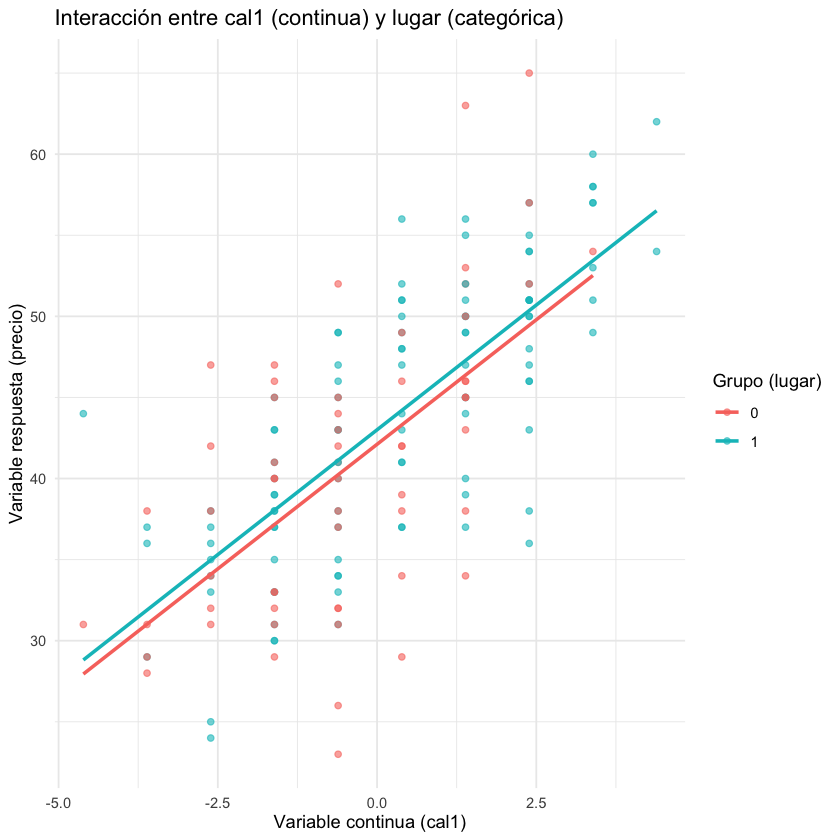

In [207]:
ggplot(datos_con_lugar, aes(x = cal1_c, y = precio, color = lugar)) +
  geom_point(alpha = 0.6) +
  geom_smooth(method = "lm", formula = 'y ~ x', se = FALSE) +
  labs(title = "Interacción entre cal1 (continua) y lugar (categórica)",
       x = "Variable continua (cal1)",
       y = "Variable respuesta (precio)",
       color = "Grupo (lugar)") +
  theme_minimal()

* Ambas rectas tienen la misma pendiente, lo que significa que la relación entre precio y cal1 no se ve afectada por lugar
* La relación entre cal1 y precio es positiva, lo que significa que a mayor calificación mayor precio 

### Validación de los supuestos

#### Residuos vs. valores ajustados

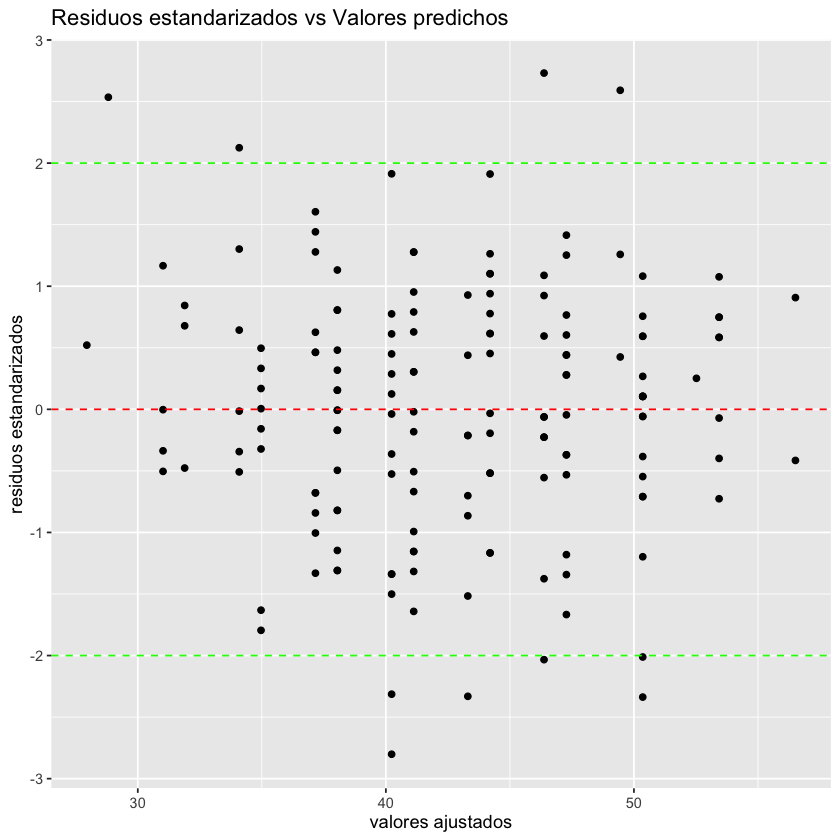

In [208]:
ggplot(data = datos_con_lugar, aes(x = fitted(modelo_centrado), y = rstandard(modelo_centrado))) + 
    geom_point() + 
    geom_hline(yintercept = 0, linetype = "dashed", color = "red") + 
    geom_hline(yintercept = -2, linetype = "dashed", color = "green") +
    geom_hline(yintercept = 2, linetype = "dashed", color = "green") +
    labs(x = "valores ajustados", 
         y = "residuos estandarizados", 
         title = "Residuos estandarizados vs Valores predichos")

* Están distribuidos de una manera simétrica, pensando que el concepto de homogeneidad se cumple

#### Residuos vs. variable regresora (cal1_c)

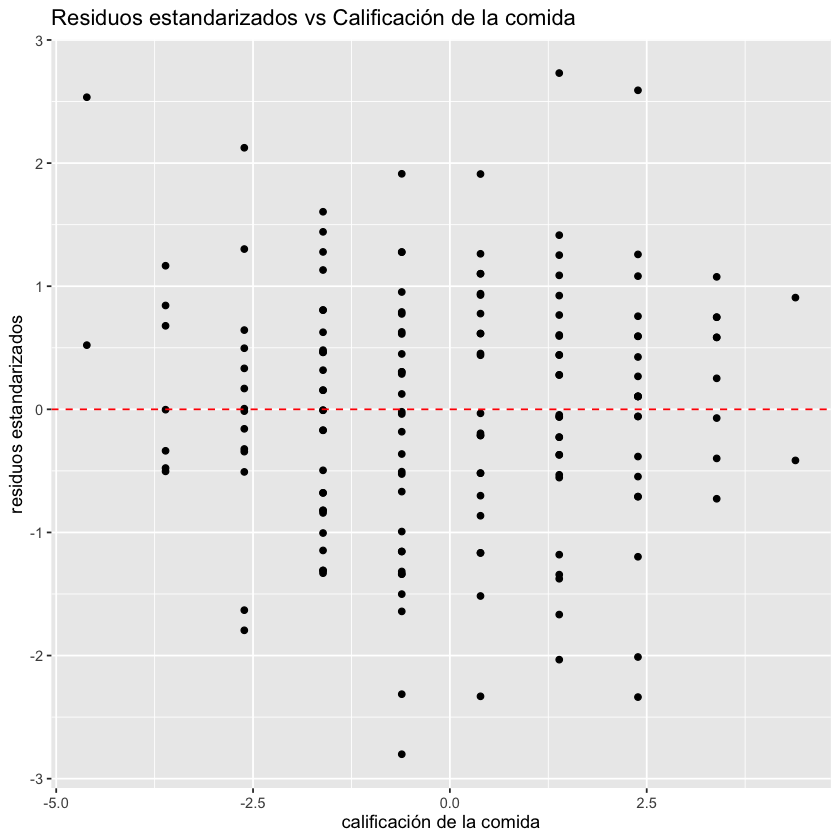

In [209]:
ggplot(data = datos_con_lugar, aes(x = cal1_c, y = rstandard(modelo_centrado))) + 
    geom_point() +
    geom_hline(yintercept = 0, linetype = "dashed", color = "red") +
    labs(x = "calificación de la comida", 
         y = "residuos estandarizados", 
         title = "Residuos estandarizados vs Calificación de la comida")

* En ambos gráficos no se ve una estructura clara; es decir, la distribución es aleatoria
* Se está validando el supuesto de homocedasticidad de los residuos

#### Normalidad de los residuos estandarizados

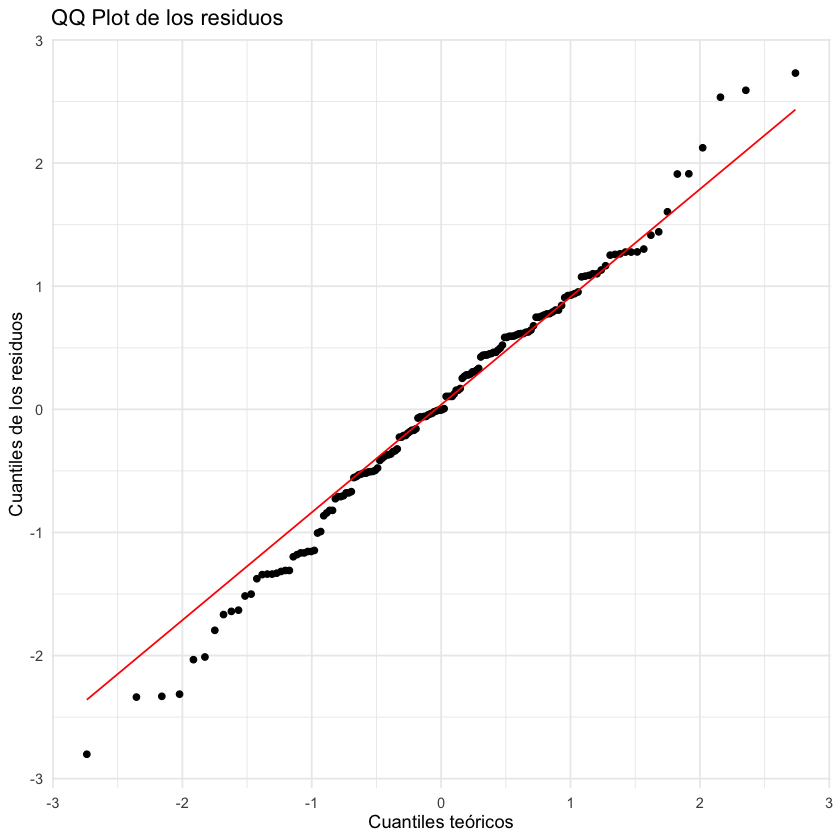

In [210]:
residuos_df = data.frame(rstandard(modelo_centrado))
ggplot(data = residuos_df, aes(sample = rstandard(modelo_centrado))) +
    stat_qq() +
    stat_qq_line(color = "red") +
    labs(title = "QQ Plot de los residuos", x = "Cuantiles teóricos", y = "Cuantiles de los residuos") +
    theme_minimal()

* Se valida el supuesto de normalidad; es decir, los errores se distribuyen normalmente

### Análisis de puntos influyentes

#### Detección de outliers

In [211]:
which(abs(rstandard(modelo_centrado)) > 2)


7  49  81  91 122 127 134 136 140 160 
  7  49  81  91 122 127 134 136 140 160

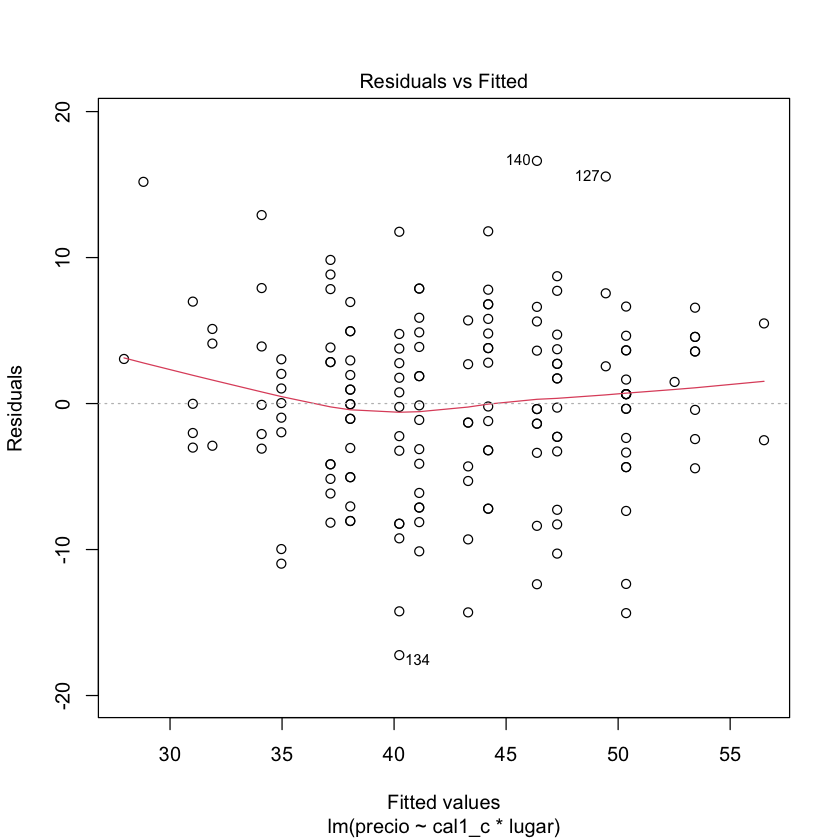

In [212]:
plot(modelo_centrado, which = 1) # Residuos vs Predichos

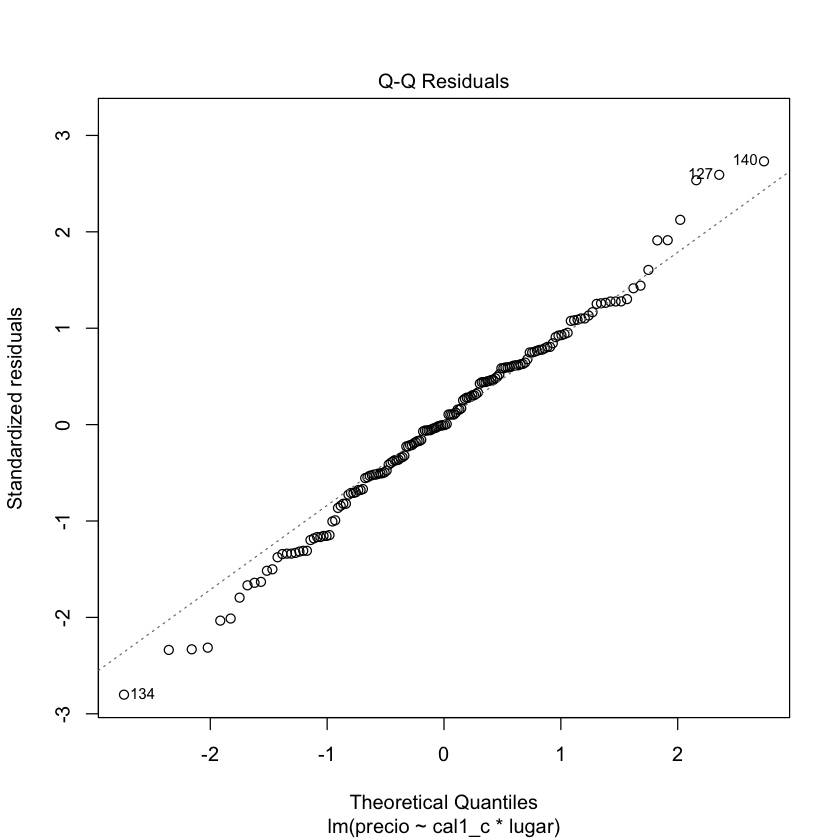

In [213]:
plot(modelo_centrado, which = 2) # qqplot

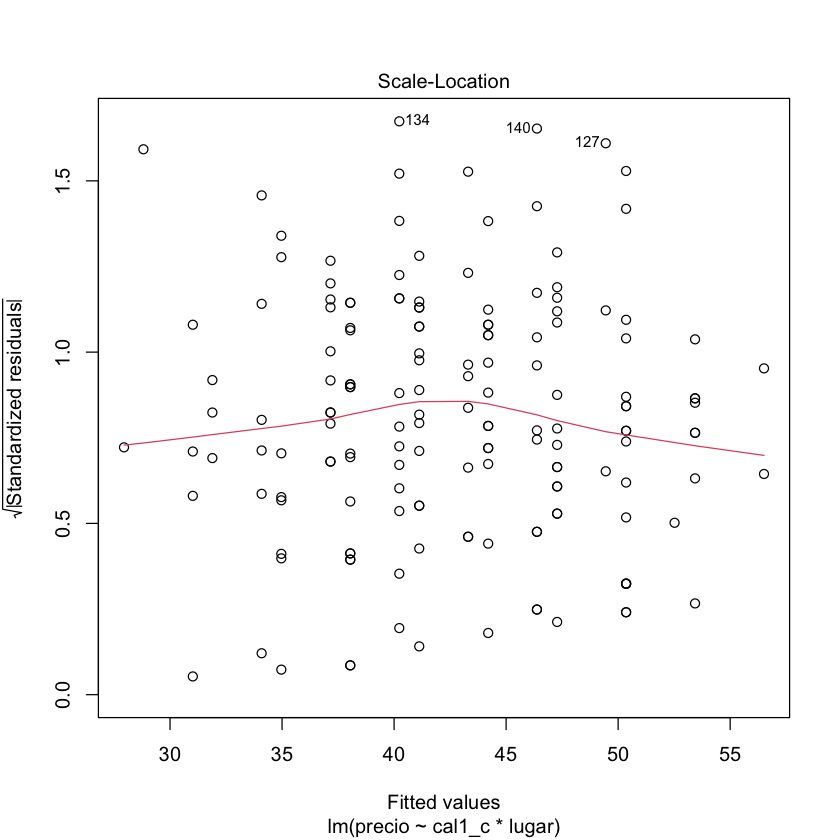

In [214]:
plot(modelo_centrado, which = 3) # raiz cuadrada de los residuos estandarizados vs predichos

#### Detección de puntos de alto leverage

In [215]:
leverage <- hatvalues(modelo_centrado)
p <- length(coef(modelo_centrado))
umbral_lev <- 2 * p / length(datos_con_lugar$cal1_c)
leverage[leverage > umbral_lev]

5         49        113        119        127        141        147 
0.10203320 0.06748310 0.06873718 0.06873718 0.06426040 0.06426040 0.06426040 
       150        154        159 
0.06873718 0.10800224 0.06873718

#### Distancia de Cook

In [216]:
cooks <- cooks.distance(modelo_centrado)
p <- length(coef(modelo_centrado))
n <- dim(datos_con_lugar)[1]
cooks_umbral <- qf(0.5, p, n-p)
cooks[cooks > cooks_umbral]

named numeric(0)

* No se observan puntos influyentes

### Interpretación de los parámetros del modelo obtenido

In [217]:
beta0 <- modelo_centrado$coefficients[1]
beta1 <- modelo_centrado$coefficients[2]
beta2 <- modelo_centrado$coefficients[3]
beta3 <- modelo_centrado$coefficients[4]
beta0

(Intercept) 
   42.10964

In [218]:
beta1

cal1_c 
3.071815

In [219]:
beta2

lugar1 
0.8937108

In [220]:
beta3

cal1_c:lugar1 
  0.005807968

$$𝑌 = 42.109 + 3.071 cal1_c + 0.893 lugar + 0.005 cal1_c * lugar$$

* $𝛽_0$: Ordenada al origen (intercept). Es el valor de Y cuando cal1 y lugar son 0
* $𝛽_1$: Indica el cambio de precio por cada unidad de cal1
* $𝛽_2$: Indica el cambio de precio dependiendo del lugar (0 o 1)
* $𝛽_3$: Representa la interacción entre cal1 y el lugar. Es el cambio adicional en al pendiente de cal1 cuando lugar es 1

* A modo de conclusión, el efecto de cal1 sobre precio es consistente en todos los "lugares"

# Ejercicio 4
---

## Lectura de datos

In [221]:
datos4 <- read.csv('DatosPSA_Prostata.csv')

In [222]:
head(datos4)

lcavol     lpeso    edad lhiper    iv lpc       gleason pgg45 lpsa      
1 -0.5798185 2.769459 50   -1.386294 0  -1.386294 6        0    -0.4307829
2 -0.9942523 3.319626 58   -1.386294 0  -1.386294 6        0    -0.1625189
3 -0.5108256 2.691243 74   -1.386294 0  -1.386294 7       20    -0.1625189
4 -1.2039728 3.282789 58   -1.386294 0  -1.386294 6        0    -0.1625189
5  0.7514161 3.432373 62   -1.386294 0  -1.386294 6        0     0.3715636
6 -1.0498221 3.228826 50   -1.386294 0  -1.386294 6        0     0.7654678

## Exploración de la relación de las variables

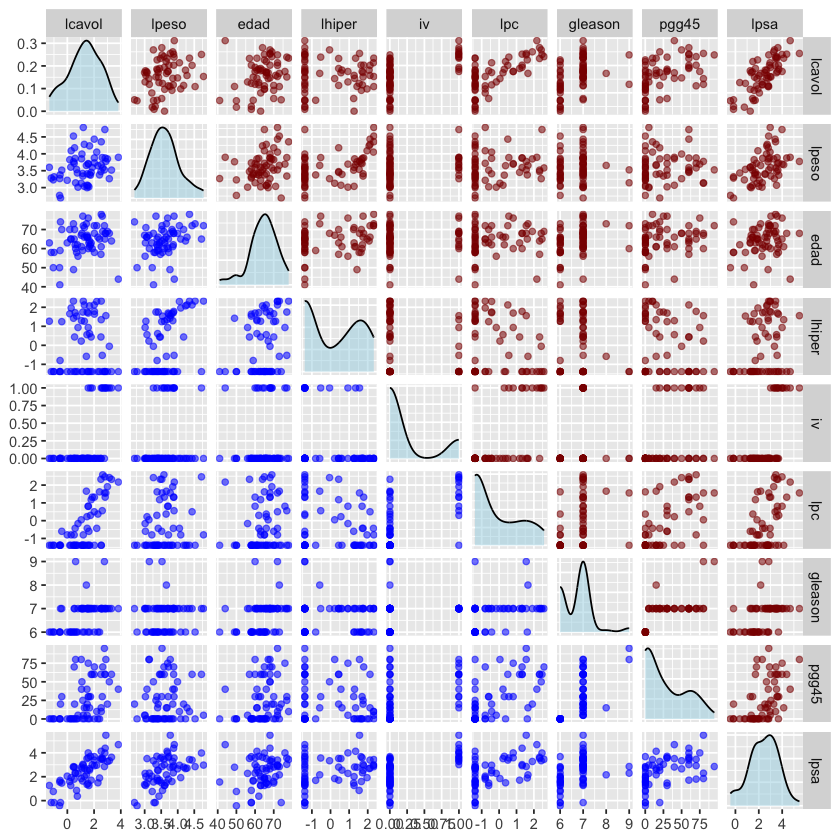

In [223]:
ggpairs(datos4,
        mapping = aes(alpha = 0.9),
        upper = list(continuous = wrap("points", color = "darkred")),
        lower = list(continuous = wrap("points", color = "blue")),
        diag = list(continuous = wrap("densityDiag", fill = "lightblue")))

* Se observa linealidad en la relación de la variable lpsa con las variables lcavol, lpeso, lpc

In [224]:
names(datos4)

[1] "lcavol"  "lpeso"   "edad"    "lhiper"  "iv"      "lpc"     "gleason"
[8] "pgg45"   "lpsa"

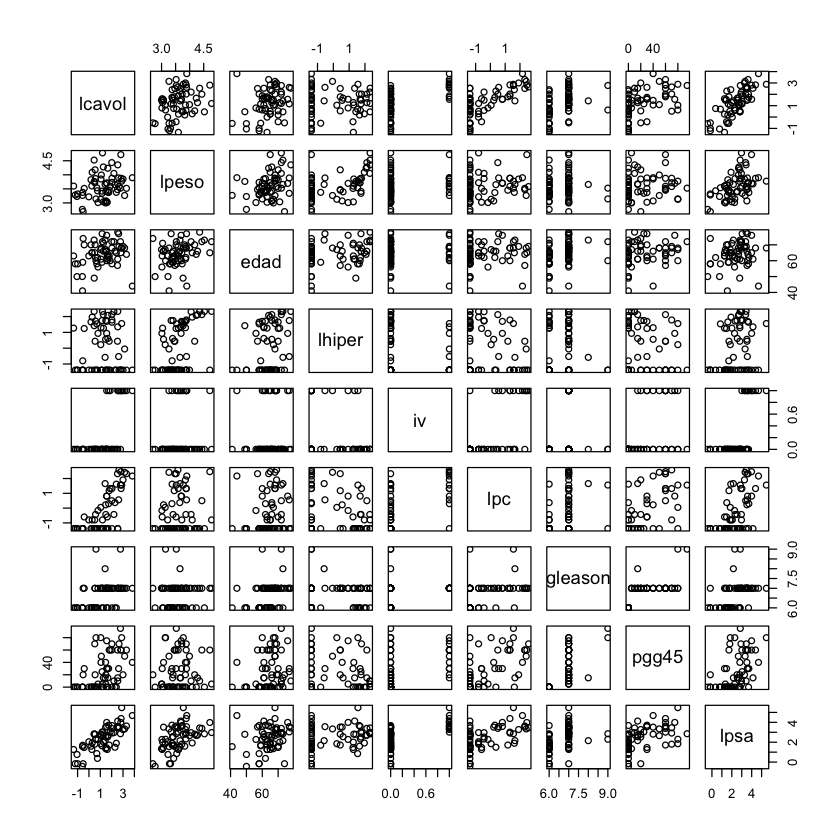

In [225]:
pairs(datos4, cex.labels = 1.4)

## Modelo

In [226]:
modelo4 <- lm(lpsa ~ ., data = datos4)
summary(modelo4)


Call:
lm(formula = lpsa ~ ., data = datos4)

Residuals:
     Min       1Q   Median       3Q      Max 
-1.36768 -0.31610 -0.06186  0.25187  1.34656 

Coefficients:
             Estimate Std. Error t value Pr(>|t|)    
(Intercept) -0.352212   1.279326  -0.275   0.7841    
lcavol       0.457406   0.095869   4.771 1.48e-05 ***
lpeso        0.499621   0.195477   2.556   0.0135 *  
edad        -0.023870   0.010782  -2.214   0.0312 *  
lhiper       0.299314   0.061952   4.831 1.20e-05 ***
iv           1.139018   0.245779   4.634 2.37e-05 ***
lpc         -0.074570   0.090851  -0.821   0.4154    
gleason      0.218317   0.167169   1.306   0.1972    
pgg45        0.006699   0.004312   1.554   0.1262    
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.5548 on 53 degrees of freedom
Multiple R-squared:  0.8252,	Adjusted R-squared:  0.7988 
F-statistic: 31.28 on 8 and 53 DF,  p-value: < 2.2e-16


* Las variables lpc, gleason y pgg45 no son significativas
* Las variables lcavol, lpeso, edad, lhiper, iv son significativas
* Tanto R2 como R2 ajustado son altos y similares, explican el 82% y 79% respectivamente

## Validación de los supuestos

### Residuos vs. valores ajustados

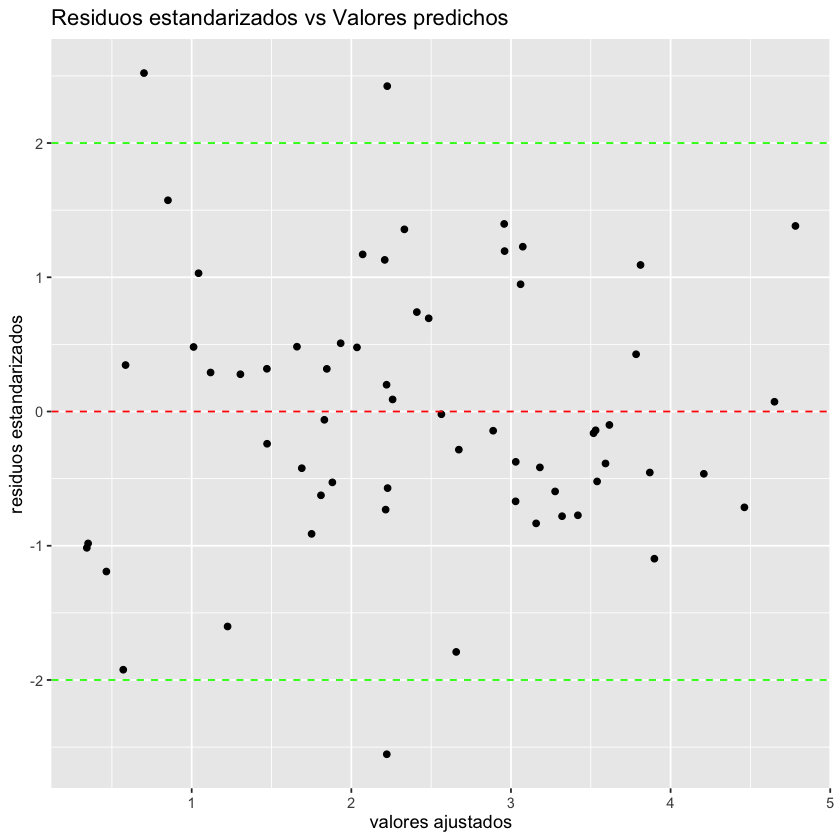

In [227]:
ggplot(data = datos4, aes(x = fitted(modelo4), y = rstandard(modelo4))) + 
    geom_point() + 
    geom_hline(yintercept = 0, linetype = "dashed", color = "red") + 
    geom_hline(yintercept = -2, linetype = "dashed", color = "green") +
    geom_hline(yintercept = 2, linetype = "dashed", color = "green") +
    labs(x = "valores ajustados", 
         y = "residuos estandarizados", 
         title = "Residuos estandarizados vs Valores predichos")

* Esto evidencia homocedasticidad
* No se ve estructura
* Se ve aleatoriedad en este gráfico

### Residuos vs. variables regresoras

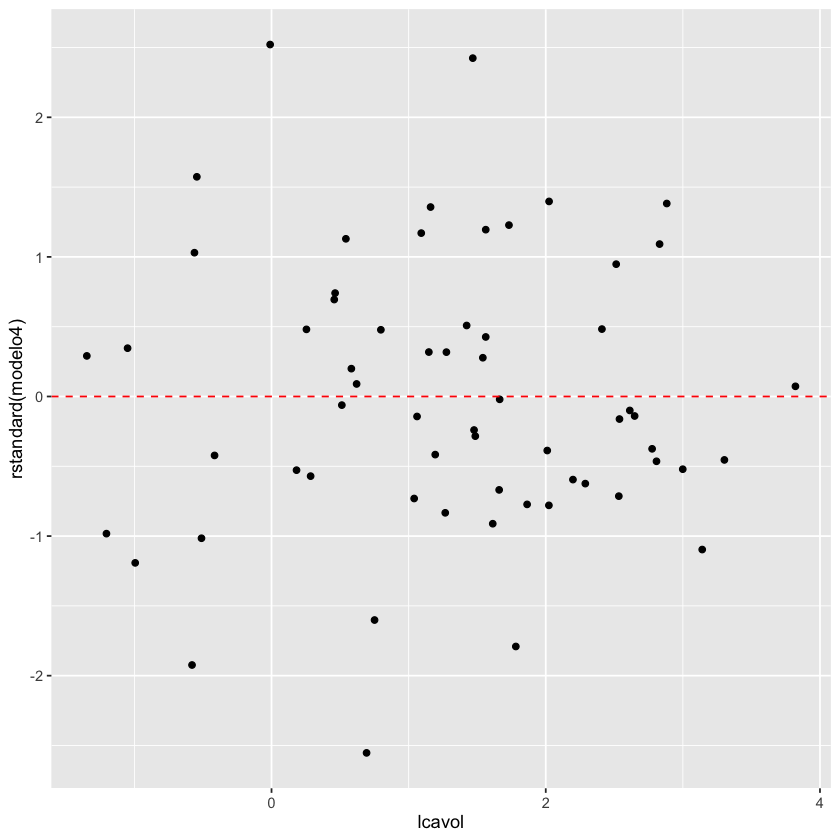

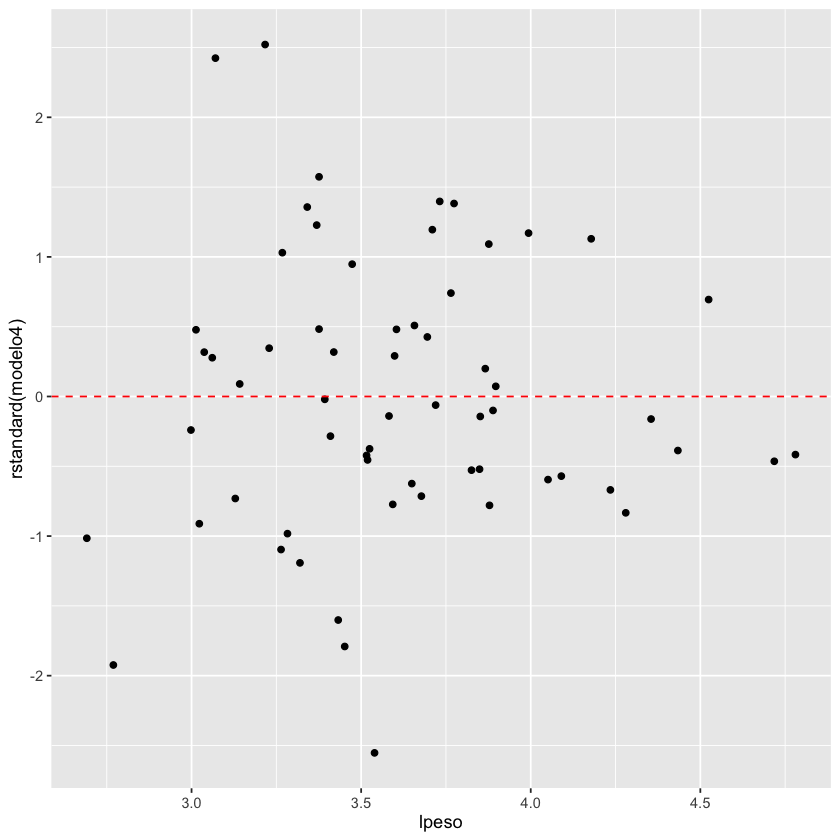

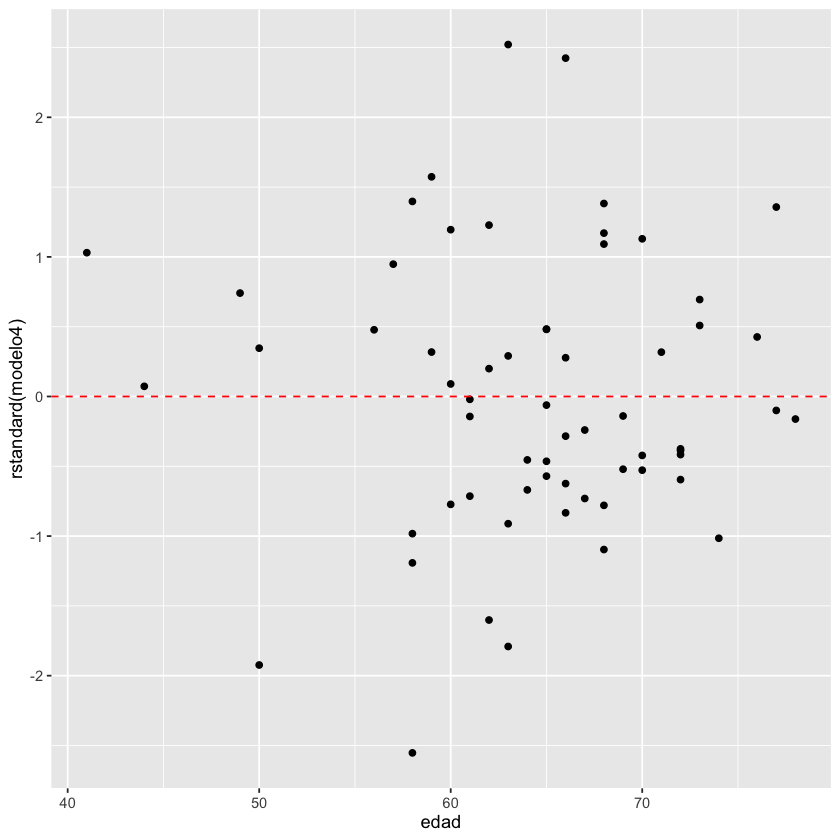

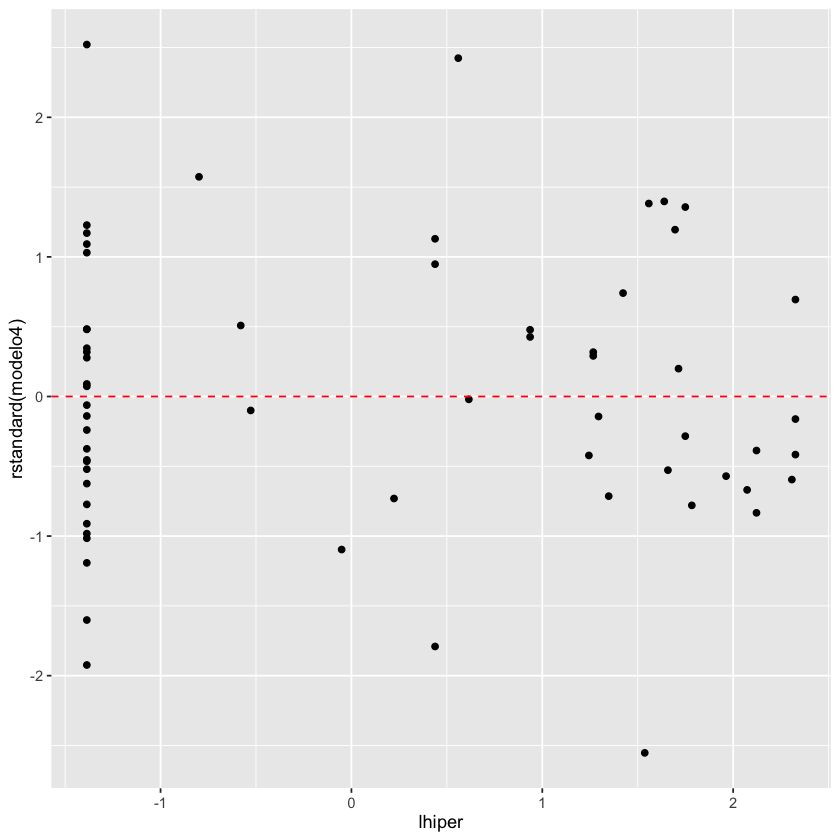

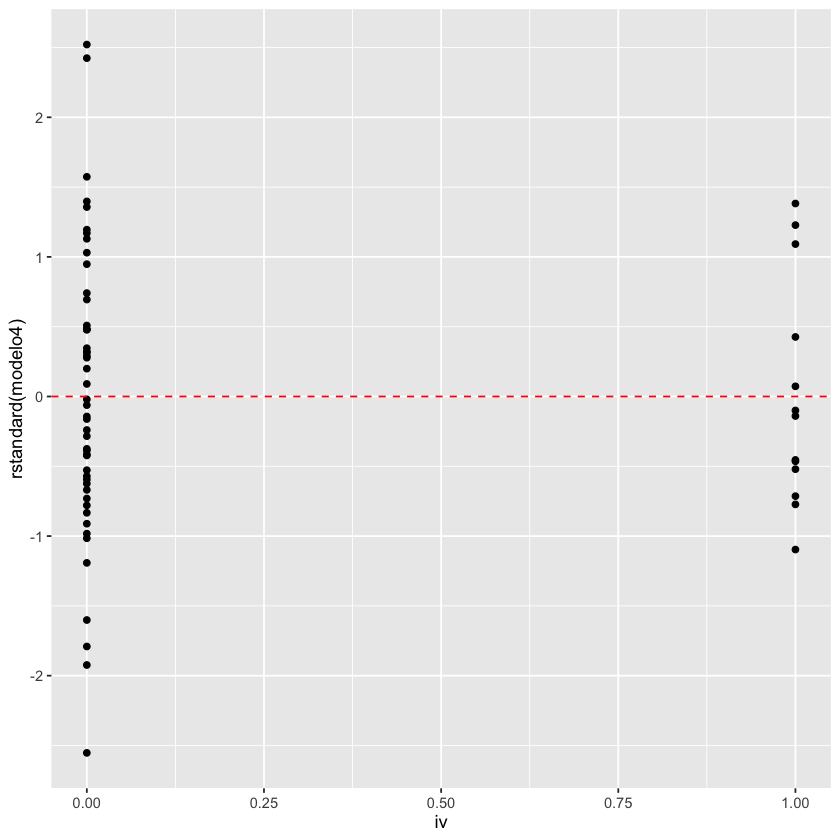

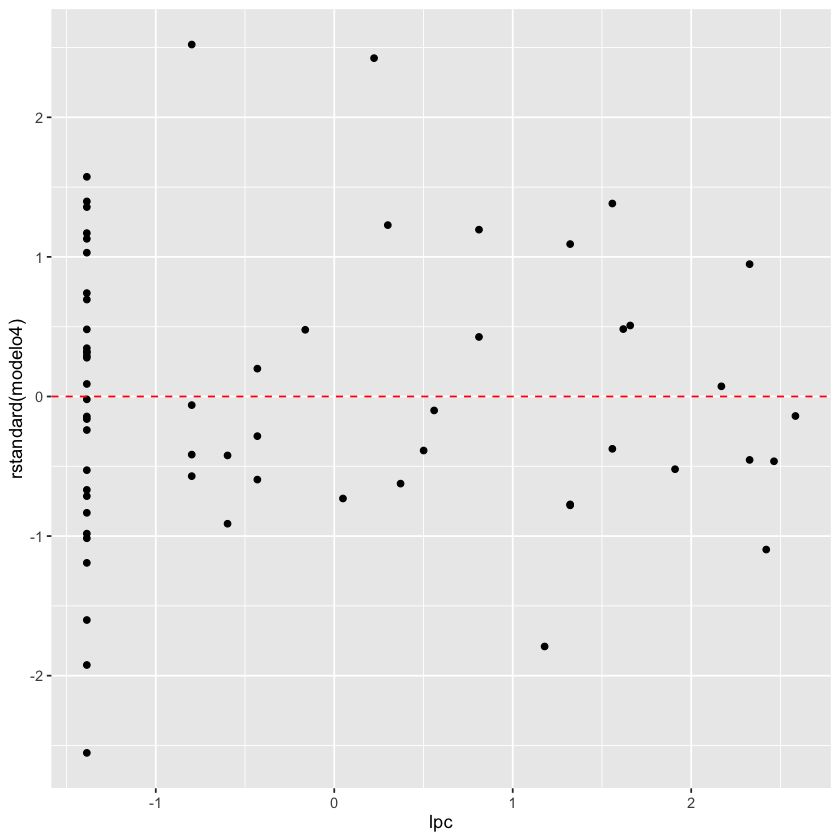

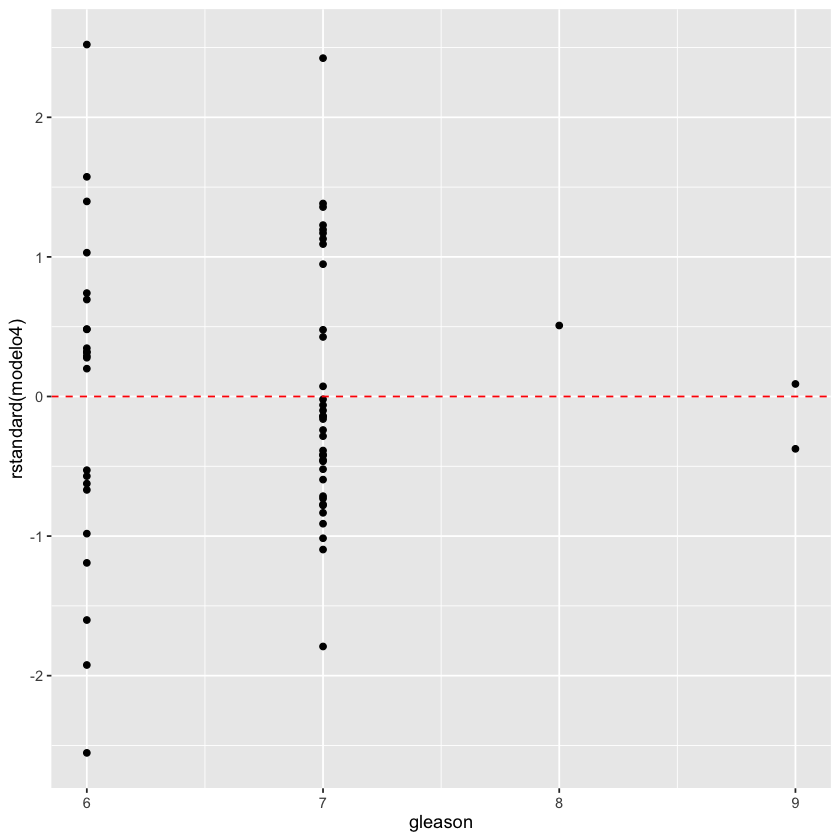

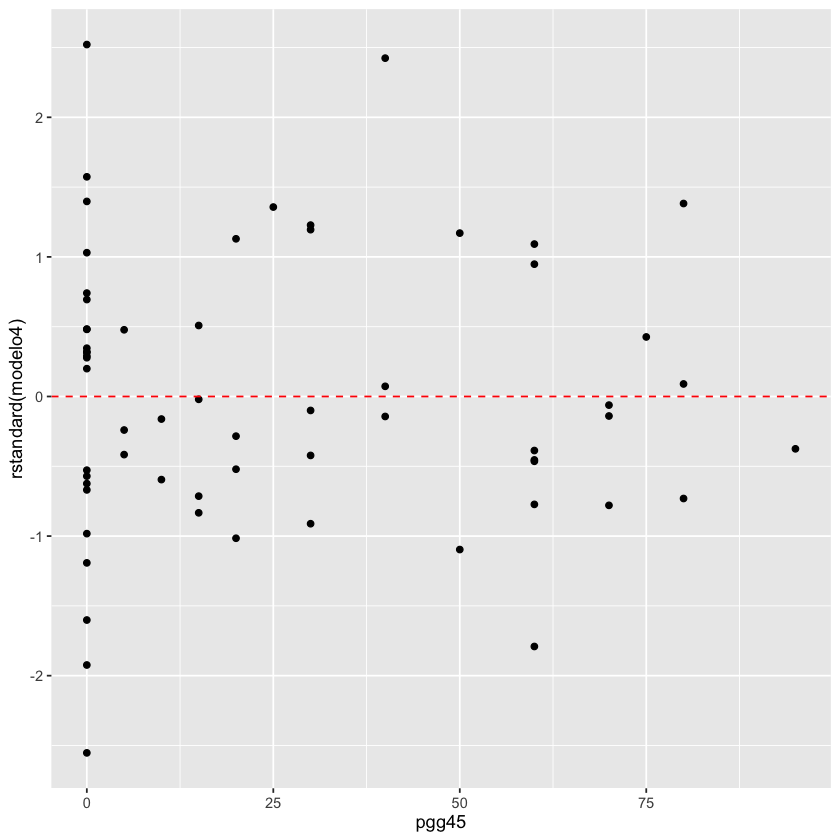

In [228]:
ggplot(data = datos4, aes(x = lcavol, y = rstandard(modelo4))) + 
    geom_point() +
    geom_hline(yintercept = 0, linetype = "dashed", color = "red")

ggplot(data = datos4, aes(x = lpeso, y = rstandard(modelo4))) + 
    geom_point() +
    geom_hline(yintercept = 0, linetype = "dashed", color = "red")

ggplot(data = datos4, aes(x = edad, y = rstandard(modelo4))) + 
    geom_point() +
    geom_hline(yintercept = 0, linetype = "dashed", color = "red")

ggplot(data = datos4, aes(x = lhiper, y = rstandard(modelo4))) + 
    geom_point() +
    geom_hline(yintercept = 0, linetype = "dashed", color = "red")

ggplot(data = datos4, aes(x = iv, y = rstandard(modelo4))) + 
    geom_point() +
    geom_hline(yintercept = 0, linetype = "dashed", color = "red")

ggplot(data = datos4, aes(x = lpc, y = rstandard(modelo4))) + 
    geom_point() +
    geom_hline(yintercept = 0, linetype = "dashed", color = "red")

ggplot(data = datos4, aes(x = gleason, y = rstandard(modelo4))) + 
    geom_point() +
    geom_hline(yintercept = 0, linetype = "dashed", color = "red")

ggplot(data = datos4, aes(x = pgg45, y = rstandard(modelo4))) + 
    geom_point() +
    geom_hline(yintercept = 0, linetype = "dashed", color = "red")

* Se visualiza que las variables iv y gleason son categóricas
* El resto de las variables no presentan estructura en su distribución, por lo tanto, se valida el supuesto de homocedasticidad

### Normalidad de los residuos estandarizados

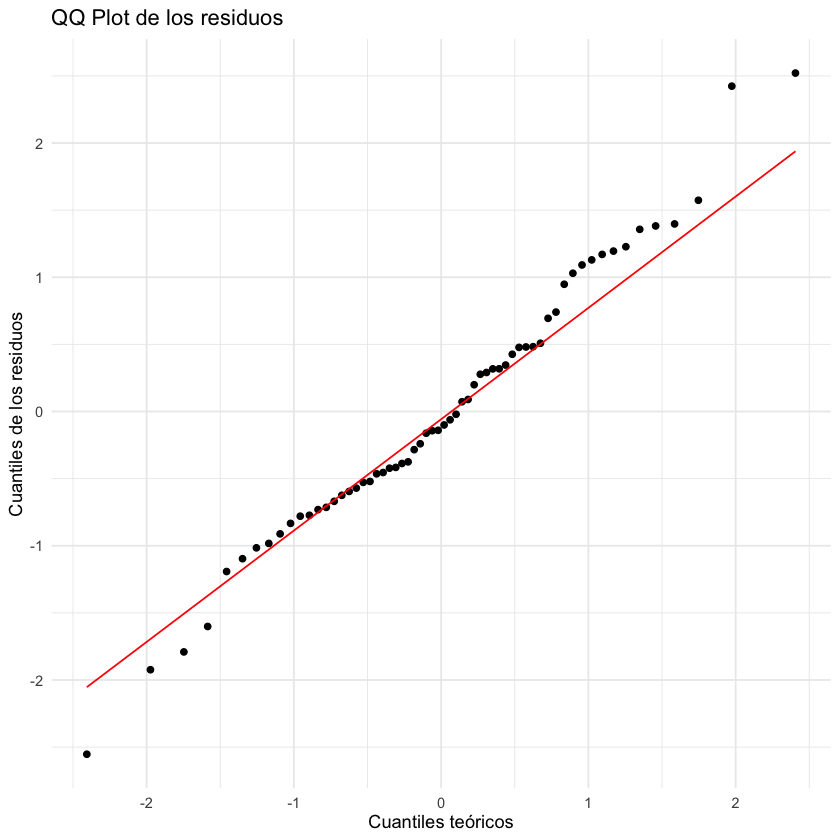

In [229]:
residuos_df4 = data.frame(rstandard(modelo4))
ggplot(data = residuos_df4, aes(sample = rstandard(modelo4))) +
    stat_qq() +
    stat_qq_line(color = "red") +
    labs(title = "QQ Plot de los residuos", x = "Cuantiles teóricos", y = "Cuantiles de los residuos") +
    theme_minimal()

* Se valida el supuesto de normalidad; es decir, los errores se distribuyen normalmente

In [230]:
# Test de shapiro wilks para normalidad
# H_0: Los datos provienen de una distribución normal 
# H_a: Los datos no provienen de una distribución normal.
shapiro.test(rstandard(modelo4))


	Shapiro-Wilk normality test

data:  rstandard(modelo4)
W = 0.98506, p-value = 0.6526


* Se verifica normalidad

## Análisis de puntos influyentes

### Detección de outliers

In [231]:
which(abs(rstandard(modelo4)) > 2)


7 25 50 
 7 25 50

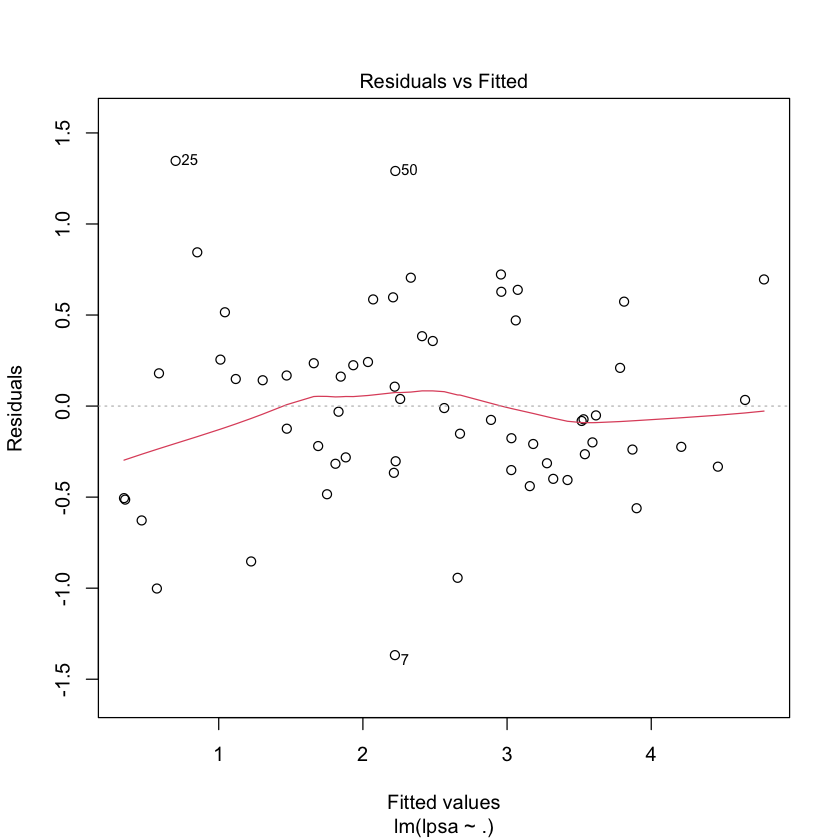

In [232]:
plot(modelo4, which = 1) # Residuos vs Predichos

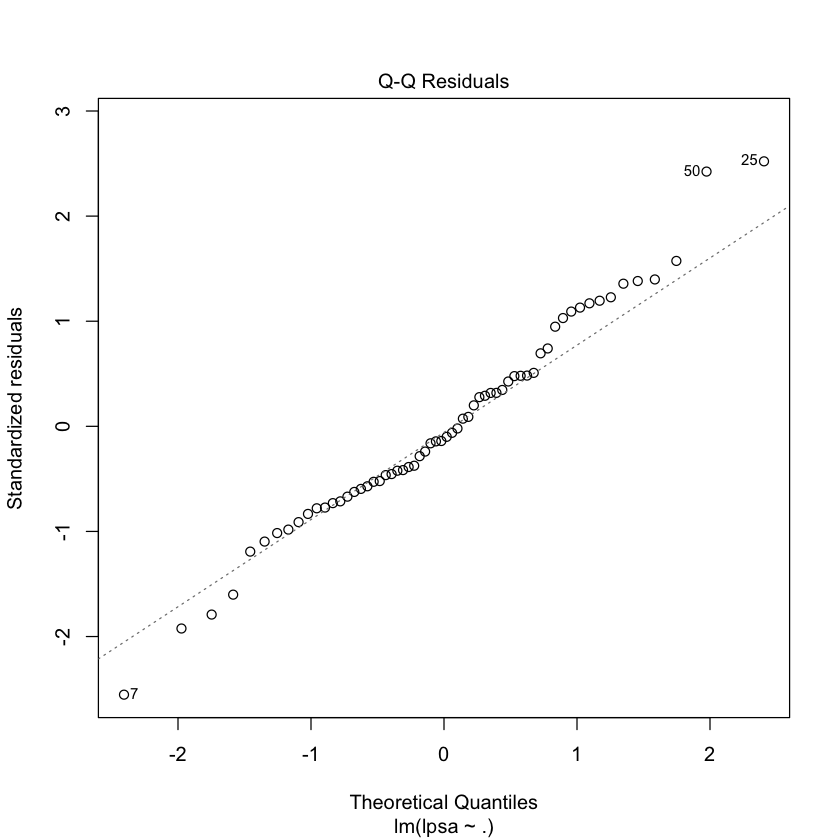

In [233]:
plot(modelo4, which = 2) # qqplot

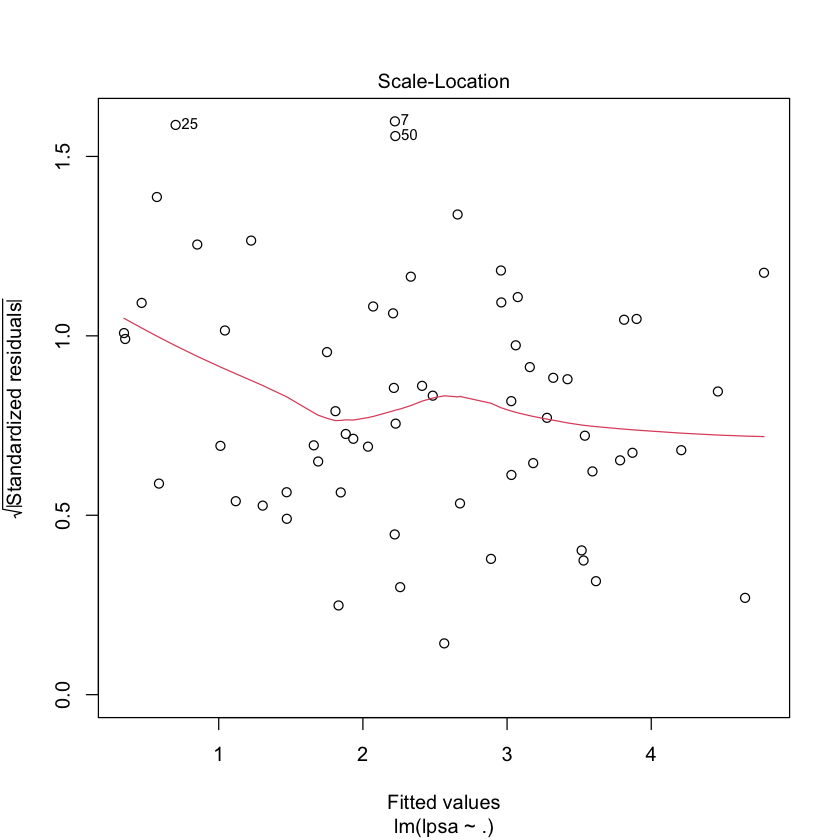

In [234]:
plot(modelo4, which = 3) # raiz cuadrada de los residuos estandarizados vs predichos

### Detección de puntos de alto leverage

In [235]:
leverage <- hatvalues(modelo4)
p <- length(coef(modelo4))
umbral_lev <- 2 * p / length(datos4$lpsa)
leverage[leverage > umbral_lev]

26        28        59        61 
0.3679958 0.3857136 0.2943105 0.3053113

### Distancia de Cook

In [236]:
cooks <- cooks.distance(modelo4)
p <- length(coef(modelo4))
n <- dim(datos4)[1]
cooks_umbral <- qf(0.5, p, n-p)
cooks[cooks > cooks_umbral]

named numeric(0)

* No se detecta ninguna observación que supere el umbral de Cook
* No se detecta ningún punto influyente

## Análisis de multicolinealidad

In [237]:
vif(modelo4)

lcavol    lpeso     edad   lhiper       iv      lpc  gleason    pgg45 
2.700754 1.518081 1.307484 1.621219 2.016201 3.027574 2.430673 2.998227

Como los valores del vif son mayores que 1 y menores que 5, supone una multicolinealidad moderada, lo que generalmente no es motivo de preocupación

## Selección de variables y validación cruzada

In [238]:
cant.var = length(modelo4$coefficients) - 1
cant.var

# División 80/20
set.seed(11)
train_index <- createDataPartition(datos4$lpsa, p = 0.8, list = FALSE)
train_data <- datos4[train_index, ]
test_data <- datos4[-train_index, ]

[1] 8

In [239]:
# metodo exhaustivo
ajuste.regsub <- regsubsets(lpsa ~ ., data = train_data, nvmax = cant.var) # por default es exhaustivo
resumen <- summary(ajuste.regsub)

In [240]:
# Crear tabla resumen
tabla <- data.frame(
  Variables = 1:cant.var,
  R2_ajustado = resumen$adjr2,
  BIC = resumen$bic
)

knitr::kable(tabla, digits = 3)



| Variables| R2_ajustado|     BIC|
|---------:|-----------:|-------:|
|         1|       0.575| -35.976|
|         2|       0.672| -46.098|
|         3|       0.771| -61.289|
|         4|       0.782| -60.878|
|         5|       0.794| -60.785|
|         6|       0.796| -58.604|
|         7|       0.792| -54.937|
|         8|       0.788| -51.236|

In [241]:
# Identificar el mejor modelo según cada criterio
mejor_R2 <- which.max(resumen$adjr2)
mejor_BIC <- which.min(resumen$bic)

cat("Mejor R2 ajustado →", mejor_R2, "variables\n")
cat("Mejor BIC         →", mejor_BIC, "variables\n")

Mejor R2 ajustado → 6 variables
Mejor BIC         → 3 variables


### Modelo BIC

In [242]:
# Control de validación cruzada 5-fold en el conjunto de entrenamiento
variables_bic <- names(coef(ajuste.regsub, mejor_BIC))[-1]  # quitamos intercept
variables_bic

formula_bic <- as.formula(paste("lpsa ~", paste(variables_bic, collapse = "+")))
formula_bic

control <- trainControl(method = "cv", number = 5)

# Entrenar modelo lineal con validación cruzada en train_data
cv.bic <- train(formula_bic, data = train_data, method = "lm", trControl = control)

# Resultados entrenamiento con CV
cv.bic

[1] "lcavol" "lhiper" "iv"

lpsa ~ lcavol + lhiper + iv

Linear Regression 

50 samples
 3 predictor

No pre-processing
Resampling: Cross-Validated (5 fold) 
Summary of sample sizes: 40, 40, 41, 40, 39 
Resampling results:

  RMSE       Rsquared   MAE      
  0.5986176  0.7637256  0.4920934

Tuning parameter 'intercept' was held constant at a value of TRUE

### Modelo R2

In [243]:
variables_R2 <- names(coef(ajuste.regsub, mejor_R2))[-1]  # quitamos intercept
variables_R2

formula_R2 <- as.formula(paste("lpsa ~", paste(variables_R2, collapse = "+")))
formula_R2
control <- trainControl(method = "cv", number = 5)

# Entrenar modelo lineal con validación cruzada en train_data
cv.R2 <- train(formula_R2, data = train_data, method = "lm", trControl = control)

# Resultados entrenamiento con CV
cv.R2

[1] "lcavol" "lpeso"  "edad"   "lhiper" "iv"     "pgg45"

lpsa ~ lcavol + lpeso + edad + lhiper + iv + pgg45

Linear Regression 

50 samples
 6 predictor

No pre-processing
Resampling: Cross-Validated (5 fold) 
Summary of sample sizes: 41, 39, 40, 38, 42 
Resampling results:

  RMSE      Rsquared   MAE      
  0.594617  0.8278261  0.4727927

Tuning parameter 'intercept' was held constant at a value of TRUE

### Modelo AIC

In [244]:
modelo4 <- lm(lpsa ~ ., data = datos4)
modelo_nulo <- lm(lpsa ~ 1, data = datos4)

step_model <- stepAIC(modelo_nulo, scope = list(lower = modelo_nulo, upper = modelo4), direction = "both", trace = FALSE)

summary(step_model)


Call:
lm(formula = lpsa ~ lcavol + lhiper + iv + pgg45 + lpeso + edad + 
    gleason, data = datos4)

Residuals:
     Min       1Q   Median       3Q      Max 
-1.34763 -0.32482 -0.00439  0.26765  1.31712 

Coefficients:
             Estimate Std. Error t value Pr(>|t|)    
(Intercept) -0.383974   1.274871  -0.301   0.7644    
lcavol       0.417780   0.082576   5.059 5.19e-06 ***
lhiper       0.308040   0.060849   5.062 5.14e-06 ***
iv           1.097111   0.239690   4.577 2.81e-05 ***
pgg45        0.005280   0.003938   1.341   0.1856    
lpeso        0.497216   0.194864   2.552   0.0136 *  
edad        -0.023364   0.010732  -2.177   0.0339 *  
gleason      0.236370   0.165215   1.431   0.1583    
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.5531 on 54 degrees of freedom
Multiple R-squared:  0.823,	Adjusted R-squared:  0.8001 
F-statistic: 35.87 on 7 and 54 DF,  p-value: < 2.2e-16


* Se observa que AIC descartó la variable lpc

In [245]:
variables_AIC <- names(coef(step_model))[-1]  # quitamos intercept
variables_AIC

formula_AIC <- as.formula(paste("lpsa ~", paste(variables_AIC, collapse = "+")))
formula_AIC

control <- trainControl(method = "cv", number = 5)

# Entrenar modelo lineal con validación cruzada en train_data
cv.AIC <- train(formula_AIC, data = train_data, method = "lm", trControl = control)

# Resultados entrenamiento con CV
cv.AIC

[1] "lcavol"  "lhiper"  "iv"      "pgg45"   "lpeso"   "edad"    "gleason"

lpsa ~ lcavol + lhiper + iv + pgg45 + lpeso + edad + gleason

Linear Regression 

50 samples
 7 predictor

No pre-processing
Resampling: Cross-Validated (5 fold) 
Summary of sample sizes: 41, 41, 39, 40, 39 
Resampling results:

  RMSE       Rsquared   MAE      
  0.6173141  0.7464874  0.5055457

Tuning parameter 'intercept' was held constant at a value of TRUE

### Tabla resumen

In [246]:
cv.bic$results

intercept RMSE      Rsquared  MAE       RMSESD   RsquaredSD MAESD    
1 TRUE      0.5986176 0.7637256 0.4920934 0.111305 0.1031274  0.0871307

In [247]:
# Crear tabla resumen
tabla.CV <- data.frame(
  BIC_RMSE = cv.bic$results$RMSE[1],
  R2_RMSE = cv.R2$results$RMSE[1],
  AIC_RMSE = cv.AIC$results$RMSE[1],

  BIC_R2 = cv.bic$results$Rsquared[1],
  R2_R2 = cv.R2$results$Rsquared[1],
  AIC_R2 = cv.AIC$results$Rsquared[1],

  BIC_MAE = cv.bic$results$MAE[1],
  R2_MAE = cv.R2$results$MAE[1],
  AIC_MAE = cv.AIC$results$MAE[1]
)

knitr::kable(tabla.CV, digits = 3)



| BIC_RMSE| R2_RMSE| AIC_RMSE| BIC_R2| R2_R2| AIC_R2| BIC_MAE| R2_MAE| AIC_MAE|
|--------:|-------:|--------:|------:|-----:|------:|-------:|------:|-------:|
|    0.599|   0.595|    0.617|  0.764| 0.828|  0.746|   0.492|  0.473|   0.506|

## Predicción en test_data con BIC


Call:
lm(formula = formula_bic, data = train_data)

Residuals:
     Min       1Q   Median       3Q      Max 
-1.42309 -0.40686 -0.01774  0.42310  1.18939 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept)  1.35064    0.12901  10.469 9.28e-14 ***
lcavol       0.55873    0.08875   6.296 1.04e-07 ***
lhiper       0.35109    0.06163   5.697 8.21e-07 ***
iv           1.23870    0.26775   4.626 3.04e-05 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.6092 on 46 degrees of freedom
Multiple R-squared:  0.7853,	Adjusted R-squared:  0.7713 
F-statistic:  56.1 on 3 and 46 DF,  p-value: 2.09e-15



Call:
lm(formula = lpsa ~ ., data = datos4)

Residuals:
     Min       1Q   Median       3Q      Max 
-1.36768 -0.31610 -0.06186  0.25187  1.34656 

Coefficients:
             Estimate Std. Error t value Pr(>|t|)    
(Intercept) -0.352212   1.279326  -0.275   0.7841    
lcavol       0.457406   0.095869   4.771 1.48e-05 ***
lpeso        0.499621   0.195477   2.556   0.0135 *  
edad        -0.023870   0.010782  -2.214   0.0312 *  
lhiper       0.299314   0.061952   4.831 1.20e-05 ***
iv           1.139018   0.245779   4.634 2.37e-05 ***
lpc         -0.074570   0.090851  -0.821   0.4154    
gleason      0.218317   0.167169   1.306   0.1972    
pgg45        0.006699   0.004312   1.554   0.1262    
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.5548 on 53 degrees of freedom
Multiple R-squared:  0.8252,	Adjusted R-squared:  0.7988 
F-statistic: 31.28 on 8 and 53 DF,  p-value: < 2.2e-16


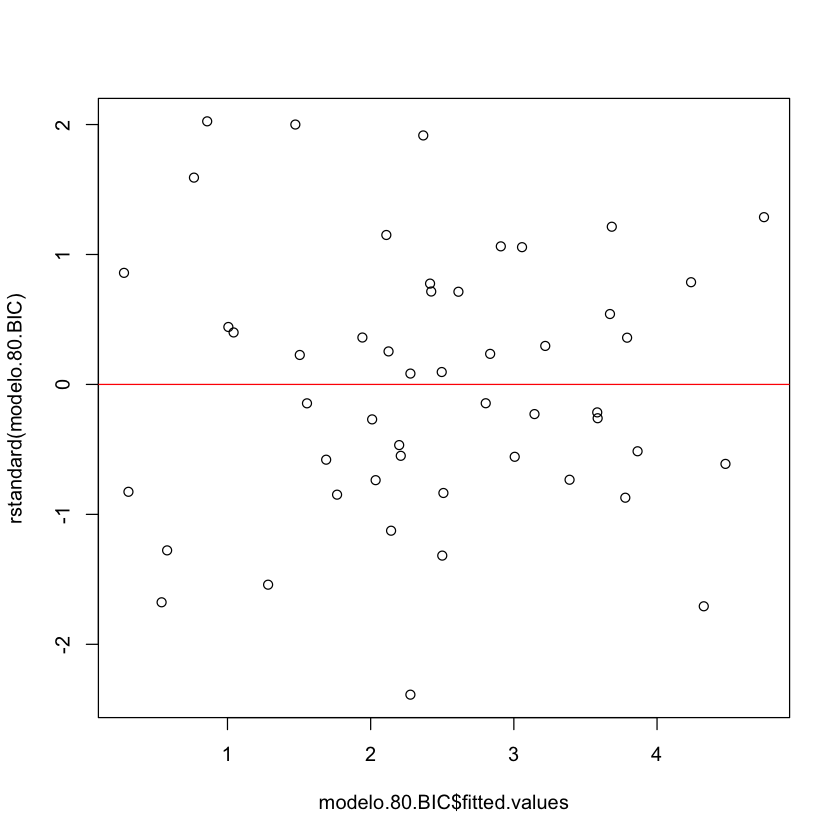

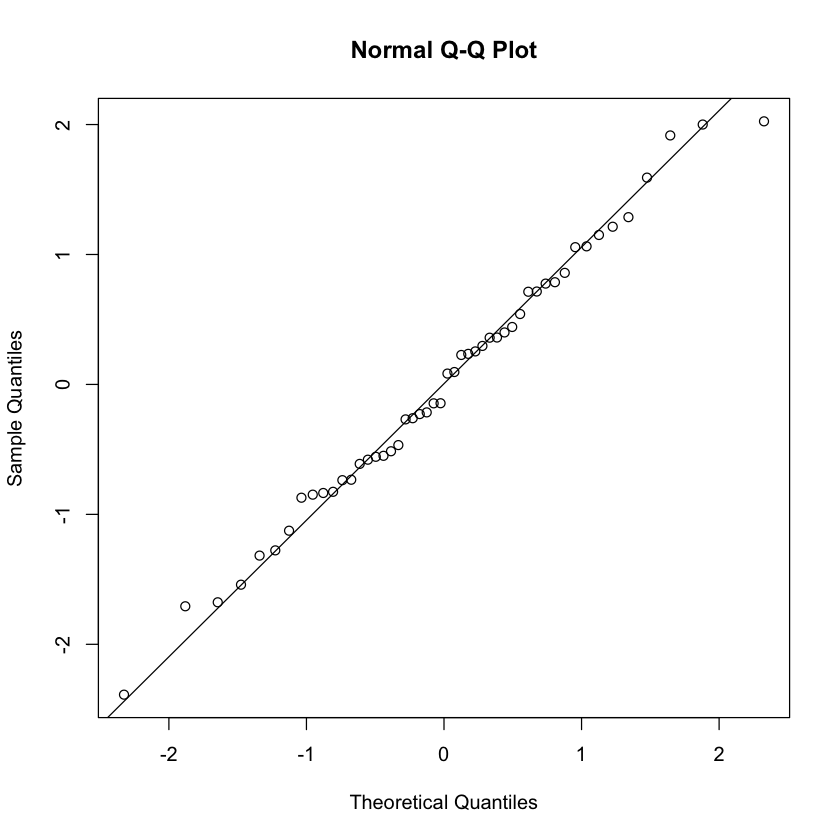

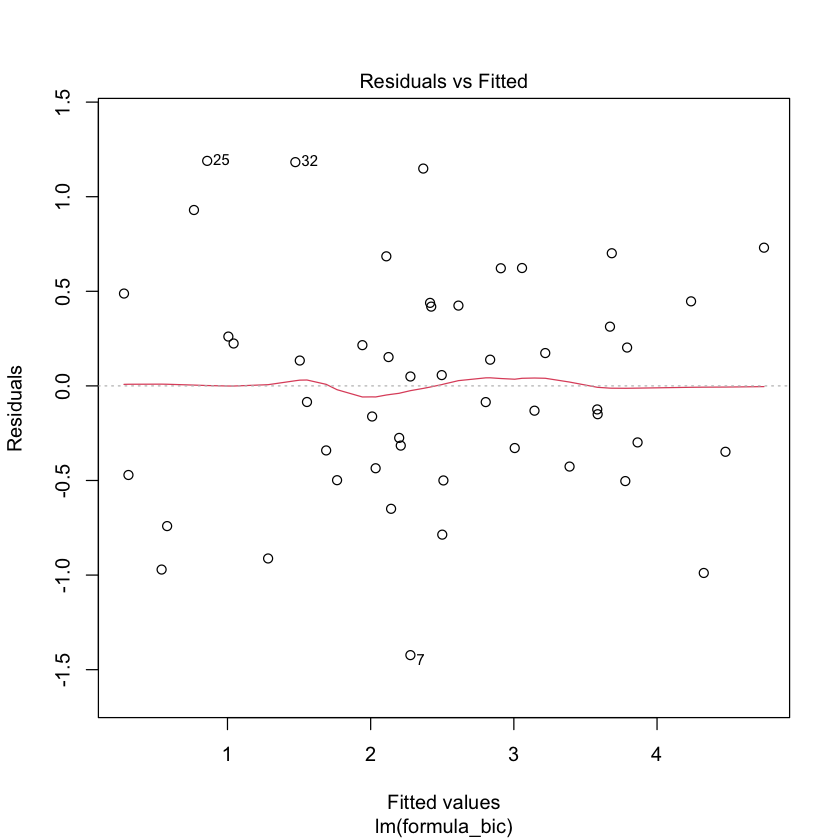

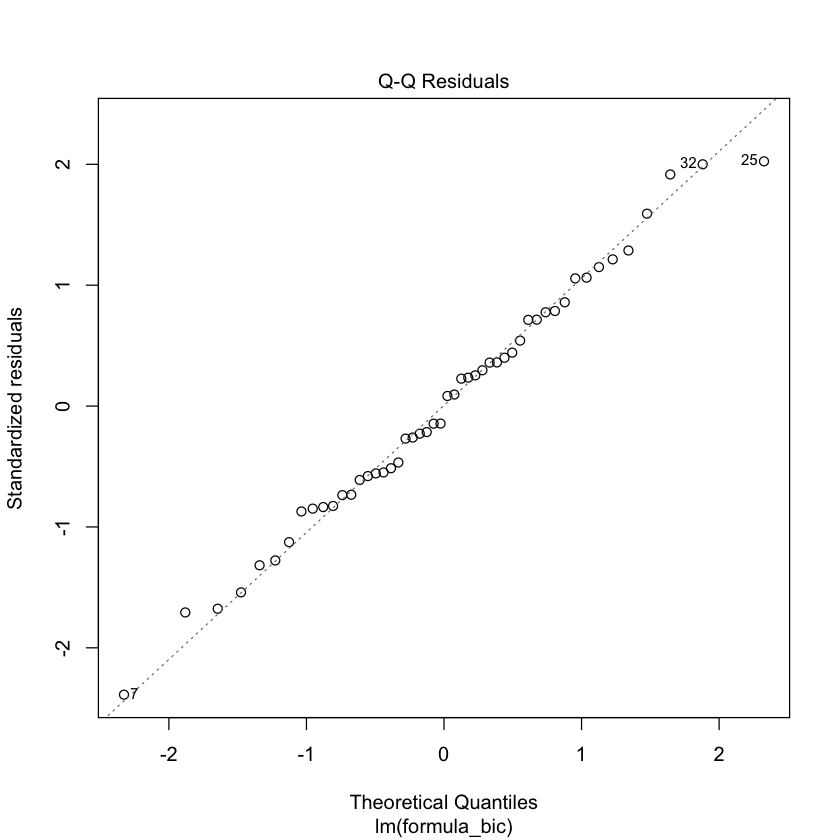

named numeric(0)

named numeric(0)

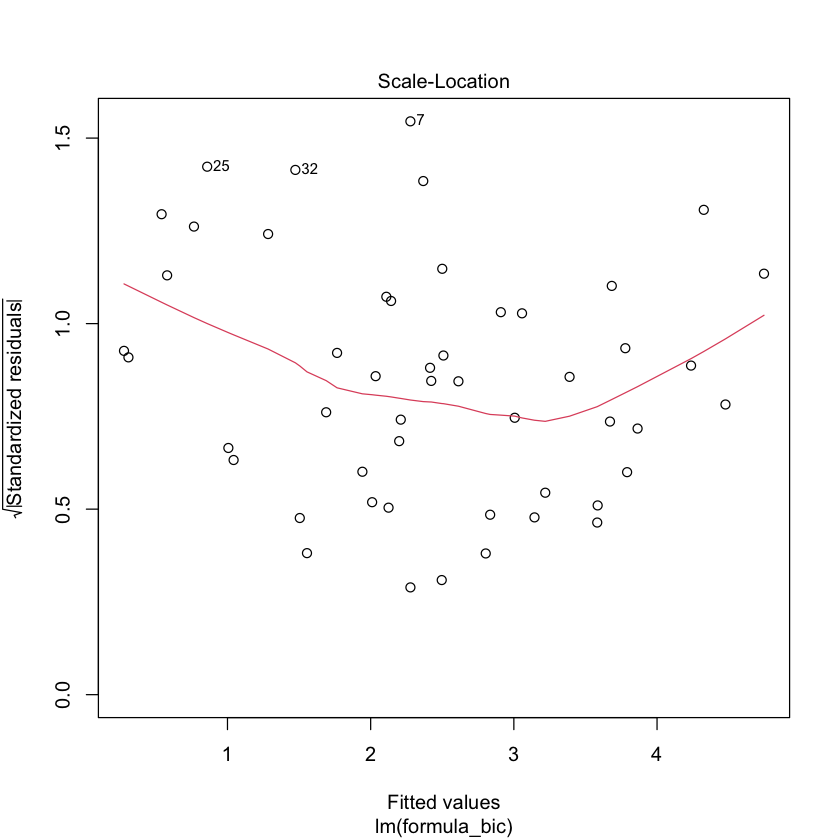

RMSE final en conjunto test (20%): 0.6586214 


Linear Regression 

50 samples
 3 predictor

No pre-processing
Resampling: Cross-Validated (5 fold) 
Summary of sample sizes: 40, 40, 41, 40, 39 
Resampling results:

  RMSE       Rsquared   MAE      
  0.5986176  0.7637256  0.4920934

Tuning parameter 'intercept' was held constant at a value of TRUE

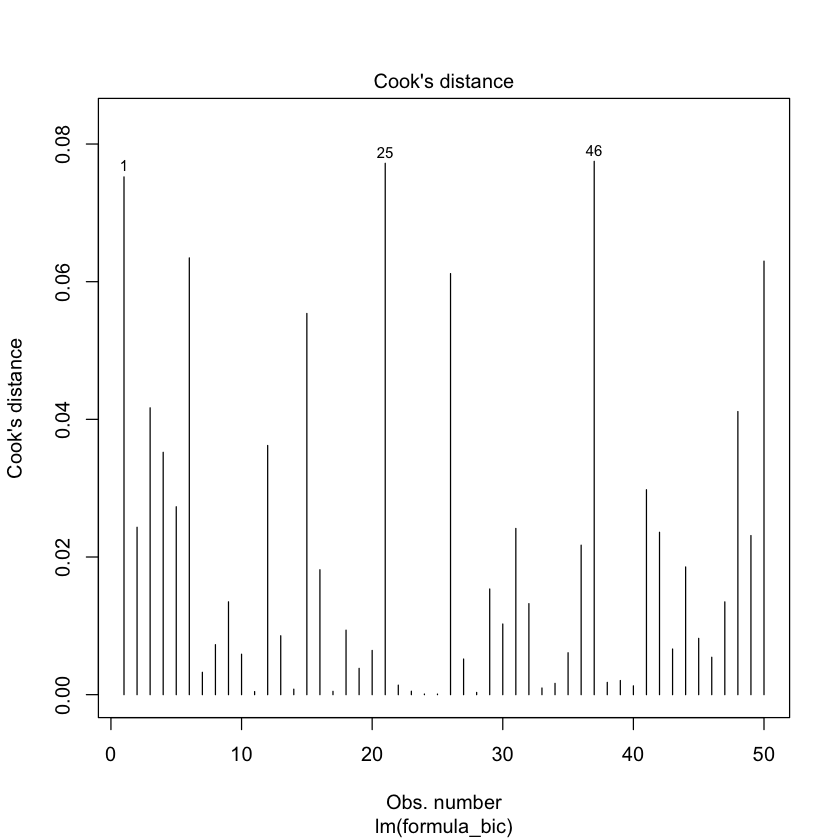

In [248]:
## Estimamos los parametros con el 80%
modelo.80.BIC <- lm(formula_bic, data = train_data)
summary(modelo.80.BIC)

#comparo con el modelo completo
summary(modelo4)

# validez del modelo
plot(modelo.80.BIC$fitted.values,rstandard(modelo.80.BIC))
abline(0, 0, col = "red")

qqnorm(rstandard(modelo.80.BIC))
qqline(rstandard(modelo.80.BIC))

#Outliers
plot(modelo.80.BIC, which=1)
plot(modelo.80.BIC, which=2)
plot(modelo.80.BIC, which=3)

#  No se detectan outliers considerables.

#Puntos de alto leverage
leverage = hatvalues(modelo.80.BIC)
p = length(coef(modelo.80.BIC))
umbral = 2 * p / length(train_data$lpsa)
leverage[leverage > umbral]

# No se detectan puntos de alto leverage.
# Distancia de Cook

cooks_d = cooks.distance(modelo.80.BIC)
p = length(coef(modelo.80.BIC))
n = dim(train_data)[1]
cooks_umbral = qf(0.5, p, n-p)

cooks_d[cooks_d > cooks_umbral]

# Gráficamente
plot(modelo.80.BIC, which=4)

# Obtener solo las variables necesarias para test_data
vars_mejor.BIC <- all.vars(formula_bic)
test_data_filtrado.BIC <- test_data[vars_mejor.BIC]

# Predecir con el modelo ganador sobre las variables correctas

test.df.BIC <- data.frame(test_data_filtrado.BIC[,-9]) #saco la variable respuesta
predicciones_test.BIC <- predict(modelo.80.BIC, newdata = test.df.BIC)

# Calcular RMSE en test_data
rmse_final.BIC <- sqrt(mean((test_data_filtrado.BIC$lpsa - predicciones_test.BIC)^2))
cat("RMSE final en conjunto test (20%):", rmse_final.BIC, "\n")
cv.bic

## Predicción en test_data con R2


Call:
lm(formula = formula_R2, data = train_data)

Residuals:
    Min      1Q  Median      3Q     Max 
-1.3406 -0.3372 -0.0055  0.3103  1.3105 

Coefficients:
             Estimate Std. Error t value Pr(>|t|)    
(Intercept)  0.690135   0.993856   0.694 0.491165    
lcavol       0.466241   0.092059   5.065 8.19e-06 ***
lpeso        0.442038   0.217170   2.035 0.047999 *  
edad        -0.014877   0.012087  -1.231 0.225066    
lhiper       0.312334   0.068789   4.540 4.49e-05 ***
iv           0.989339   0.267717   3.695 0.000616 ***
pgg45        0.008682   0.003749   2.316 0.025418 *  
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.5755 on 43 degrees of freedom
Multiple R-squared:  0.8209,	Adjusted R-squared:  0.7959 
F-statistic: 32.85 on 6 and 43 DF,  p-value: 1.589e-14



Call:
lm(formula = lpsa ~ ., data = datos4)

Residuals:
     Min       1Q   Median       3Q      Max 
-1.36768 -0.31610 -0.06186  0.25187  1.34656 

Coefficients:
             Estimate Std. Error t value Pr(>|t|)    
(Intercept) -0.352212   1.279326  -0.275   0.7841    
lcavol       0.457406   0.095869   4.771 1.48e-05 ***
lpeso        0.499621   0.195477   2.556   0.0135 *  
edad        -0.023870   0.010782  -2.214   0.0312 *  
lhiper       0.299314   0.061952   4.831 1.20e-05 ***
iv           1.139018   0.245779   4.634 2.37e-05 ***
lpc         -0.074570   0.090851  -0.821   0.4154    
gleason      0.218317   0.167169   1.306   0.1972    
pgg45        0.006699   0.004312   1.554   0.1262    
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.5548 on 53 degrees of freedom
Multiple R-squared:  0.8252,	Adjusted R-squared:  0.7988 
F-statistic: 31.28 on 8 and 53 DF,  p-value: < 2.2e-16


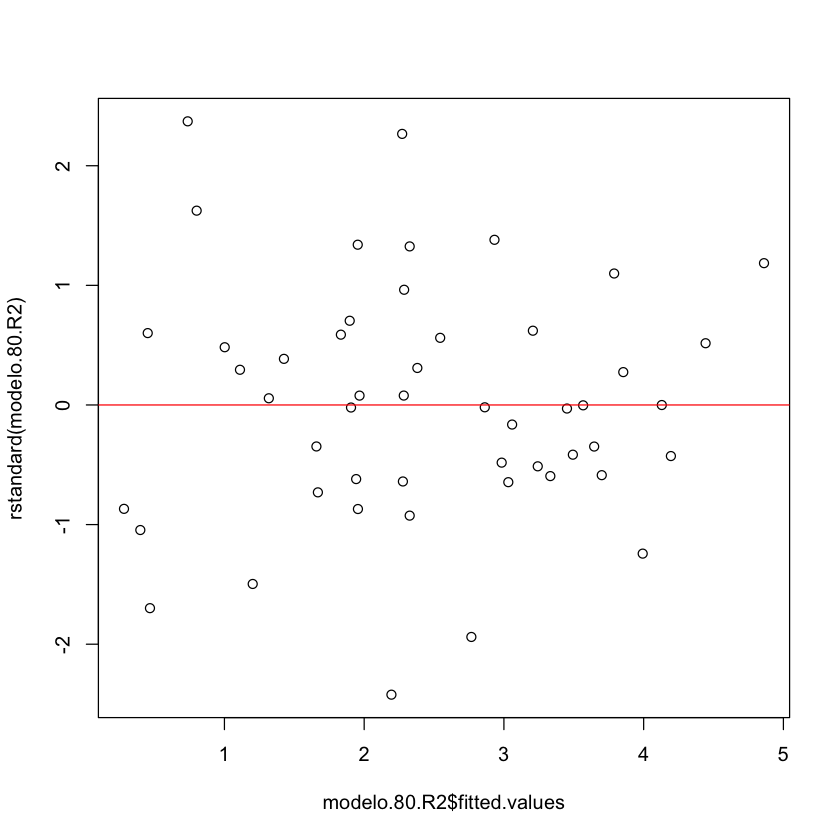

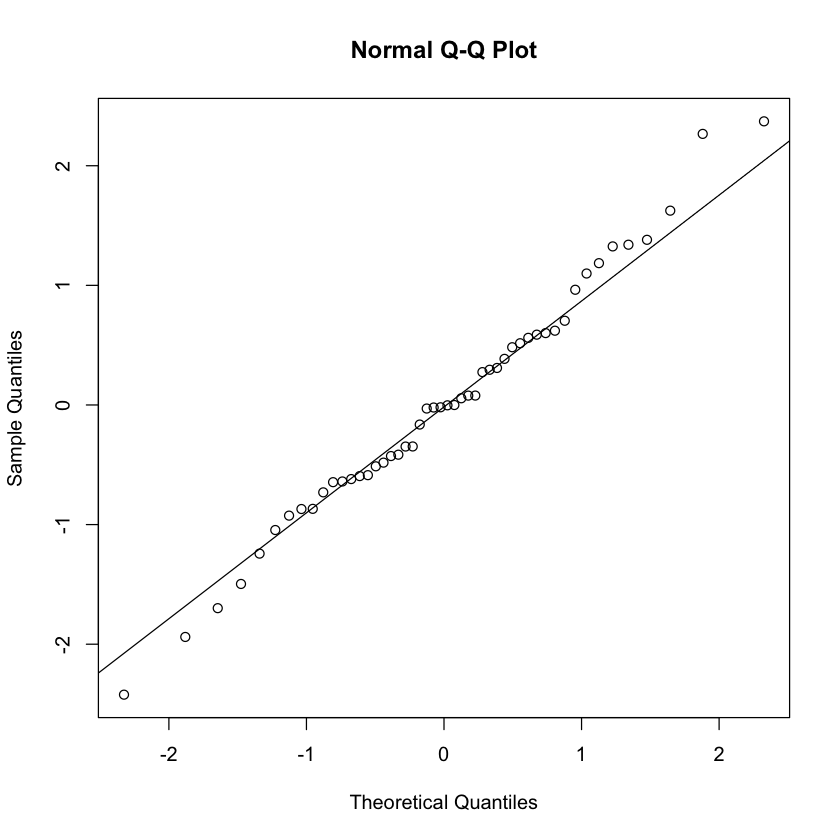

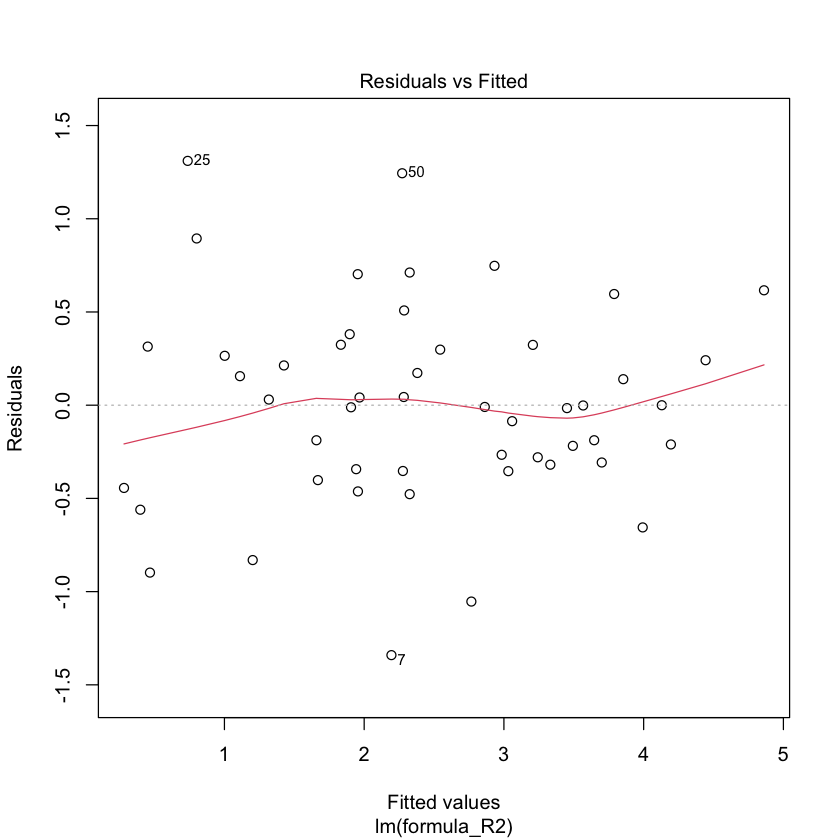

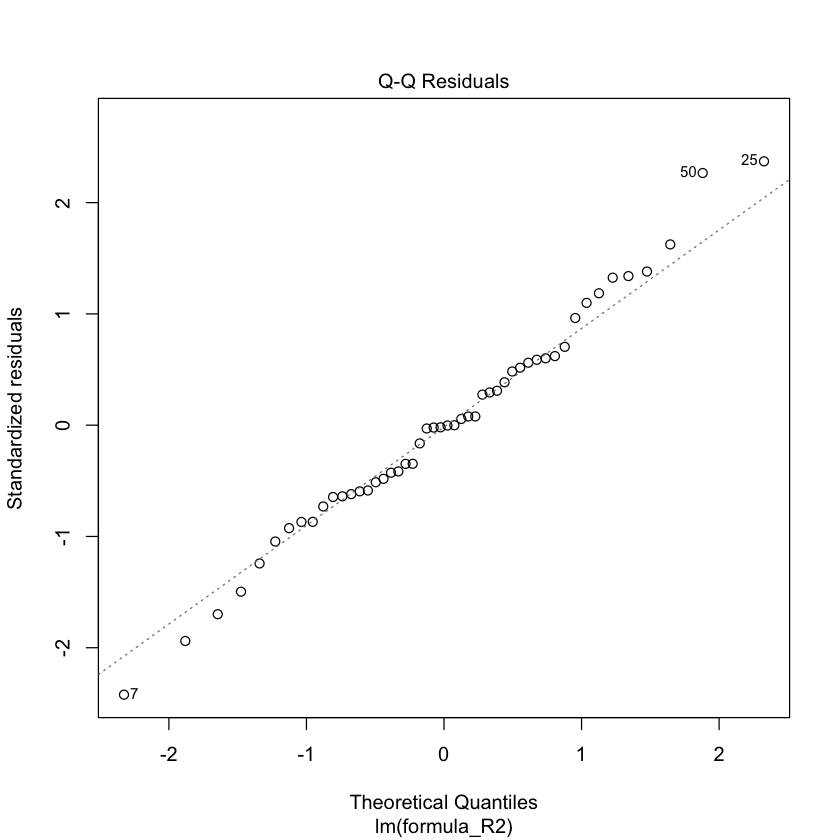

39        61 
0.2920761 0.3406871

named numeric(0)

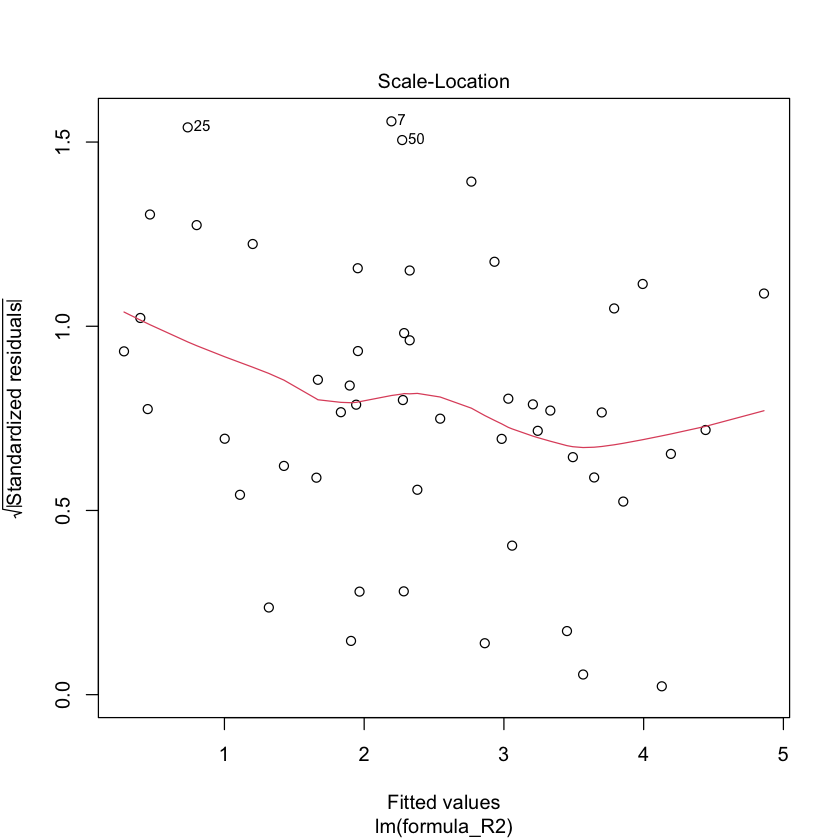

RMSE final en conjunto test (20%): 0.5112103 


Linear Regression 

50 samples
 6 predictor

No pre-processing
Resampling: Cross-Validated (5 fold) 
Summary of sample sizes: 41, 39, 40, 38, 42 
Resampling results:

  RMSE      Rsquared   MAE      
  0.594617  0.8278261  0.4727927

Tuning parameter 'intercept' was held constant at a value of TRUE

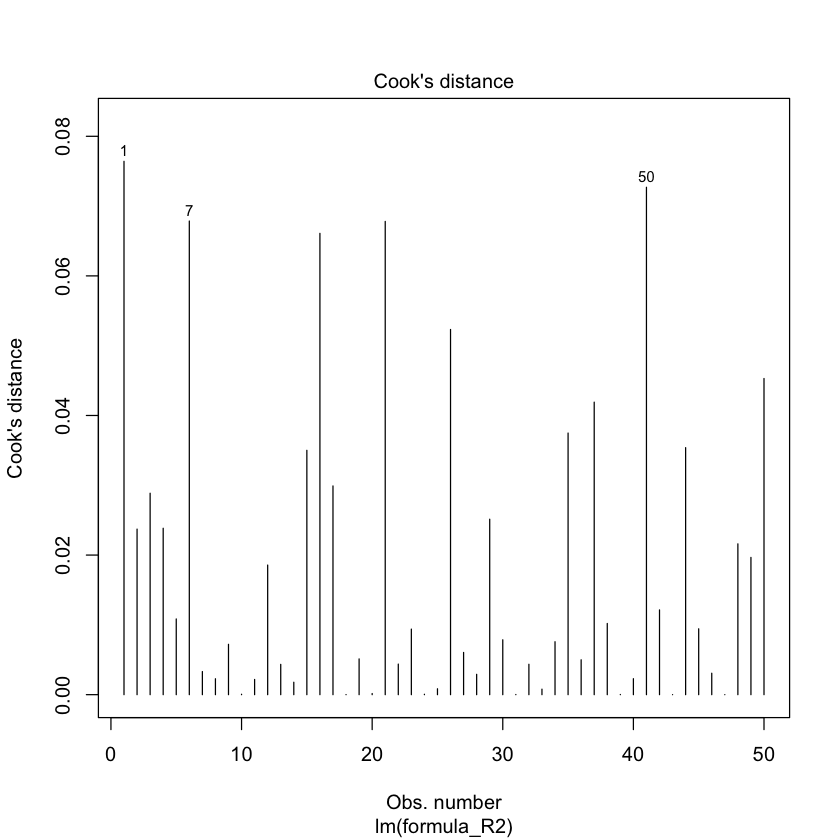

In [249]:
## Estimamos los parametros con el 80%
modelo.80.R2 <- lm(formula_R2, data = train_data)
summary(modelo.80.R2)

#comparo con el modelo completo
summary(modelo4)

# validez del modelo
plot(modelo.80.R2$fitted.values,rstandard(modelo.80.R2))
abline(0,0,col="red")

qqnorm(rstandard(modelo.80.R2))
qqline(rstandard(modelo.80.R2))

#Outliers
plot(modelo.80.R2, which=1)
plot(modelo.80.R2, which=2)
plot(modelo.80.R2, which=3)

#  No se detectan outliers considerables.

#Puntos de alto leverage
leverage = hatvalues(modelo.80.R2)
p = length(coef(modelo.80.R2))
umbral = 2 * p / length(train_data$lpsa)
leverage[leverage > umbral]

# No se detectan puntos de alto leverage.
# Distancia de Cook

cooks_d = cooks.distance(modelo.80.R2)
p = length(coef(modelo.80.R2))
n = dim(train_data)[1]
cooks_umbral = qf(0.5, p, n-p)

cooks_d[cooks_d > cooks_umbral]

# Gráficamente
plot(modelo.80.R2, which=4)

# Obtener solo las variables necesarias para test_data
vars_mejor.R2 <- all.vars(formula_R2)
test_data_filtrado.R2 <- test_data[vars_mejor.R2]

# Predecir con el modelo ganador sobre las variables correctas

test.df.R2 <- data.frame(test_data_filtrado.R2[,-9]) #saco la variable respuesta
predicciones_test.R2 <- predict(modelo.80.R2, newdata = test.df.R2)

# Calcular RMSE en test_data
rmse_final.R2 <- sqrt(mean((test_data_filtrado.R2$lpsa - predicciones_test.R2)^2))
cat("RMSE final en conjunto test (20%):", rmse_final.R2, "\n")
cv.R2

## Predicción en test_data con AIC


Call:
lm(formula = formula_AIC, data = train_data)

Residuals:
     Min       1Q   Median       3Q      Max 
-1.32718 -0.32210 -0.01708  0.29730  1.33267 

Coefficients:
             Estimate Std. Error t value Pr(>|t|)    
(Intercept)  0.228694   1.494281   0.153 0.879095    
lcavol       0.452401   0.098710   4.583 4.07e-05 ***
lhiper       0.314790   0.069709   4.516 5.04e-05 ***
iv           1.016899   0.278297   3.654 0.000711 ***
pgg45        0.007551   0.004657   1.621 0.112456    
lpeso        0.449857   0.220088   2.044 0.047259 *  
edad        -0.016626   0.012906  -1.288 0.204709    
gleason      0.087930   0.210973   0.417 0.678959    
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.5811 on 42 degrees of freedom
Multiple R-squared:  0.8216,	Adjusted R-squared:  0.7919 
F-statistic: 27.64 on 7 and 42 DF,  p-value: 8.822e-14



Call:
lm(formula = lpsa ~ ., data = datos4)

Residuals:
     Min       1Q   Median       3Q      Max 
-1.36768 -0.31610 -0.06186  0.25187  1.34656 

Coefficients:
             Estimate Std. Error t value Pr(>|t|)    
(Intercept) -0.352212   1.279326  -0.275   0.7841    
lcavol       0.457406   0.095869   4.771 1.48e-05 ***
lpeso        0.499621   0.195477   2.556   0.0135 *  
edad        -0.023870   0.010782  -2.214   0.0312 *  
lhiper       0.299314   0.061952   4.831 1.20e-05 ***
iv           1.139018   0.245779   4.634 2.37e-05 ***
lpc         -0.074570   0.090851  -0.821   0.4154    
gleason      0.218317   0.167169   1.306   0.1972    
pgg45        0.006699   0.004312   1.554   0.1262    
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.5548 on 53 degrees of freedom
Multiple R-squared:  0.8252,	Adjusted R-squared:  0.7988 
F-statistic: 31.28 on 8 and 53 DF,  p-value: < 2.2e-16


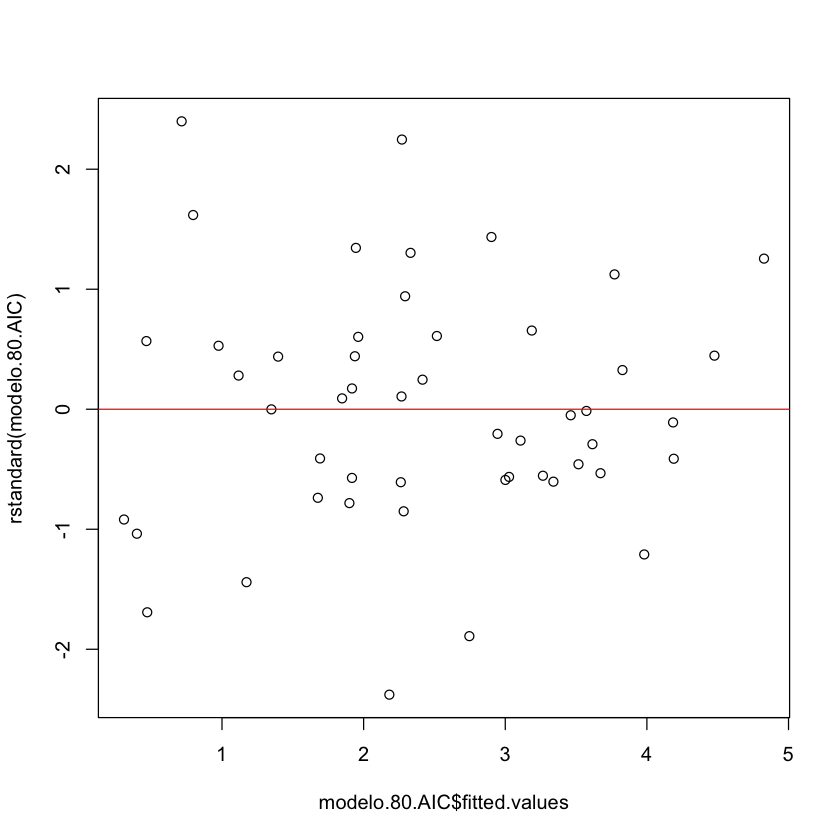

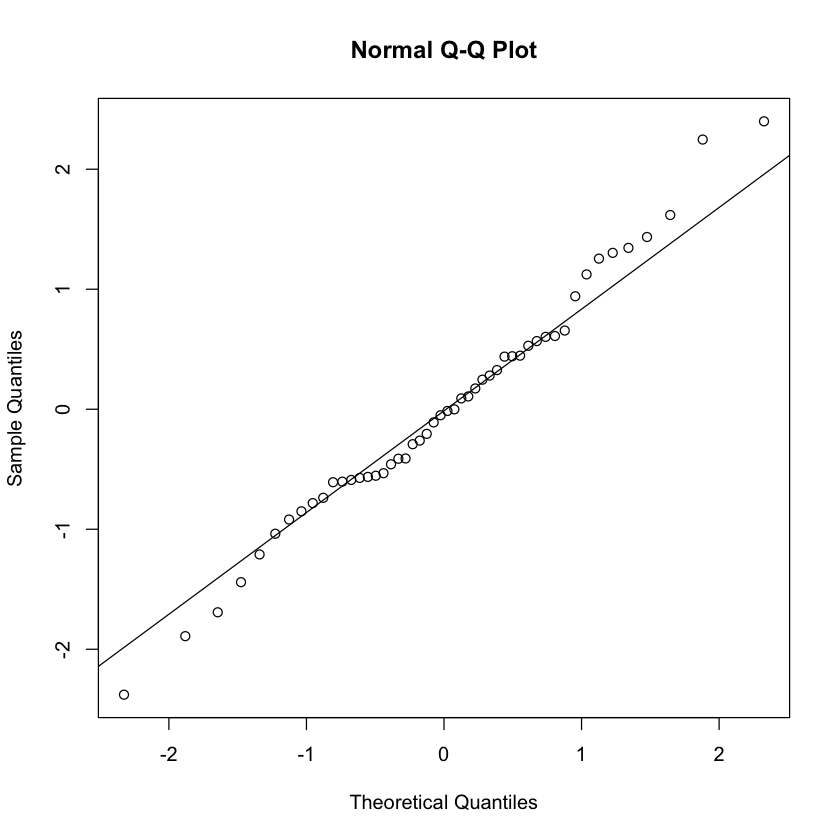

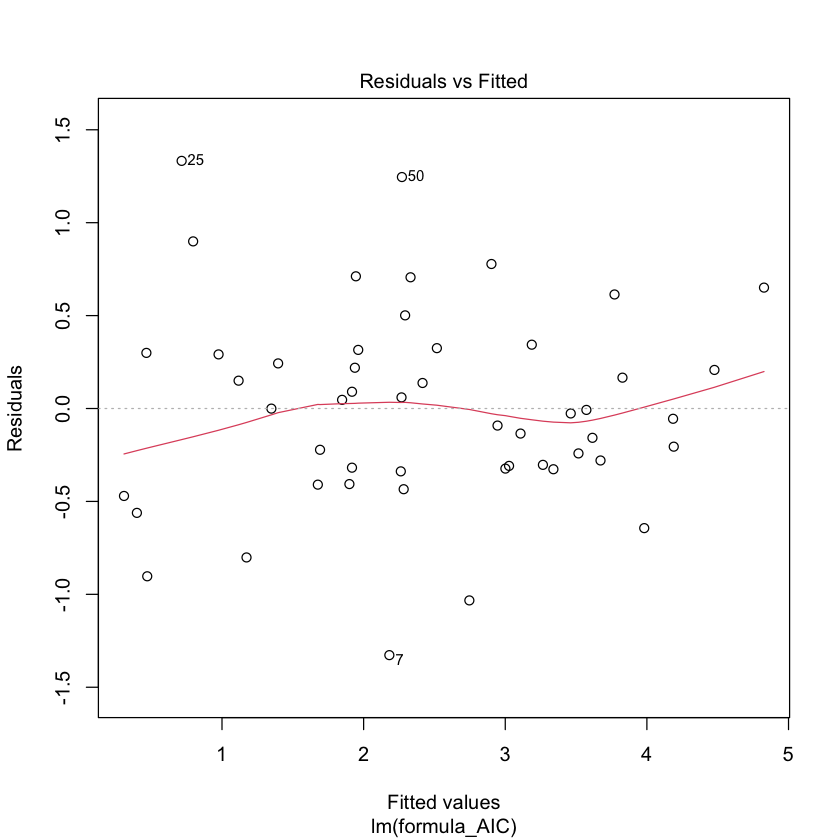

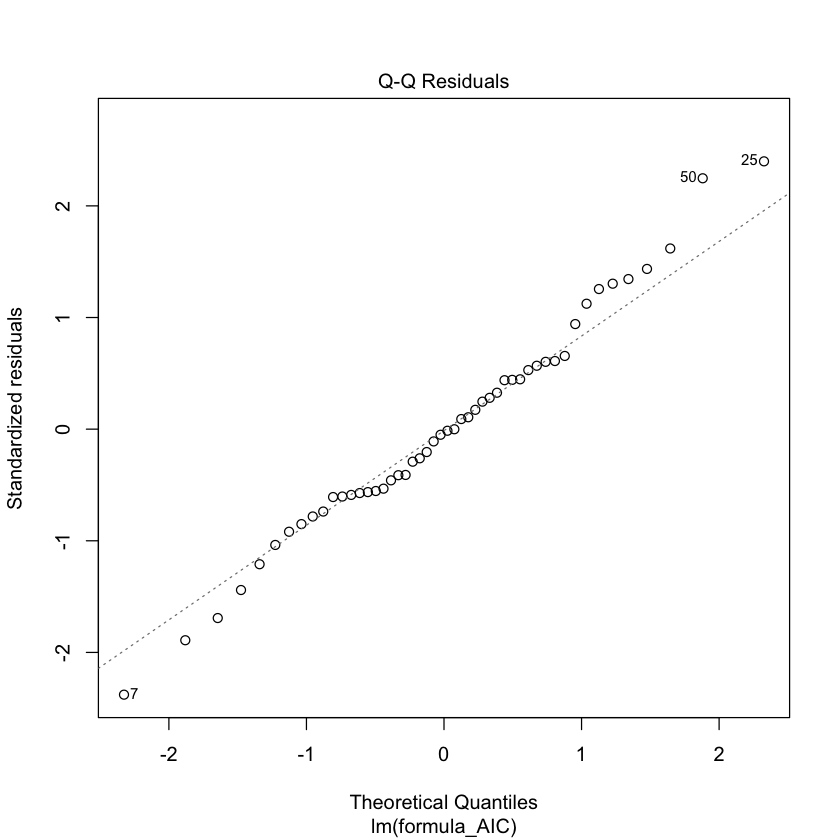

39        61 
0.4075564 0.3599526

named numeric(0)

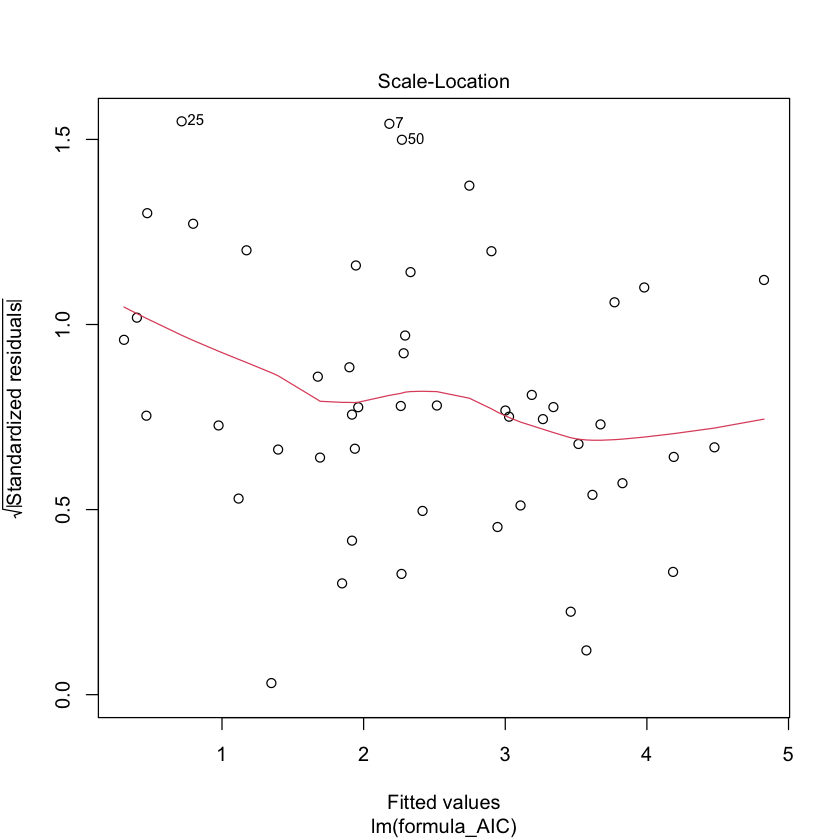

RMSE final en conjunto test (20%): 0.4812381 


Linear Regression 

50 samples
 7 predictor

No pre-processing
Resampling: Cross-Validated (5 fold) 
Summary of sample sizes: 41, 41, 39, 40, 39 
Resampling results:

  RMSE       Rsquared   MAE      
  0.6173141  0.7464874  0.5055457

Tuning parameter 'intercept' was held constant at a value of TRUE

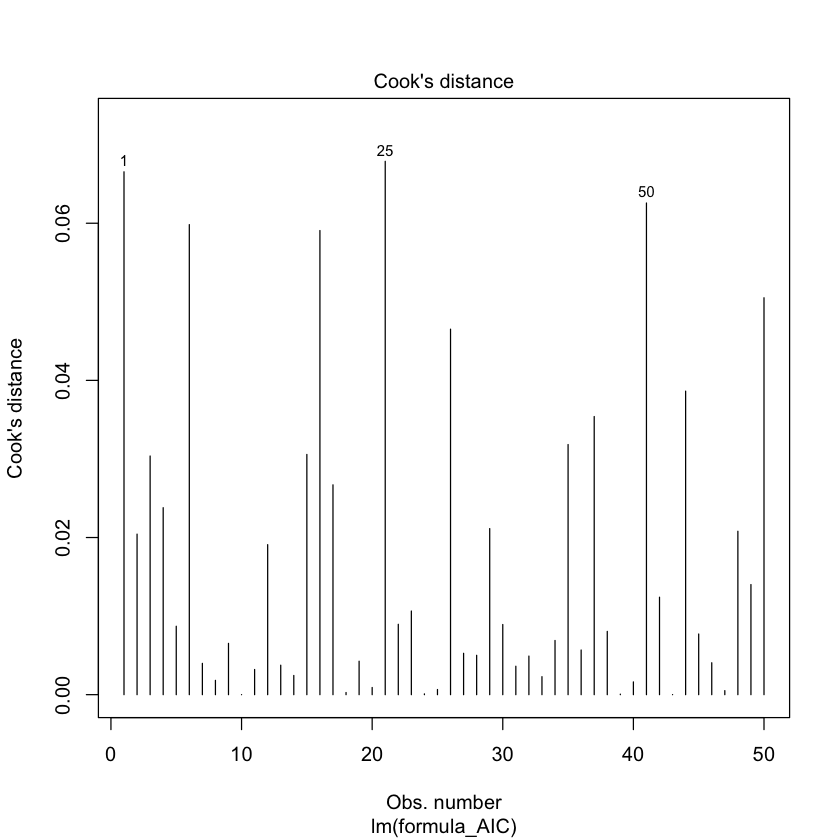

In [250]:
## Estimamos los parametros con el 80%
modelo.80.AIC <- lm(formula_AIC, data = train_data)
summary(modelo.80.AIC)

#comparo con el modelo completo
summary(modelo4)

# validez del modelo
plot(modelo.80.AIC$fitted.values,rstandard(modelo.80.AIC))
abline(0,0,col="red")

qqnorm(rstandard(modelo.80.AIC))
qqline(rstandard(modelo.80.AIC))

#Outliers
plot(modelo.80.AIC, which=1)
plot(modelo.80.AIC, which=2)
plot(modelo.80.AIC, which=3)

#  No se detectan outliers considerables.

#Puntos de alto leverage
leverage = hatvalues(modelo.80.AIC)
p = length(coef(modelo.80.AIC))
umbral = 2 * p / length(train_data$lpsa)
leverage[leverage > umbral]

# No se detectan puntos de alto leverage.
# Distancia de Cook

cooks_d = cooks.distance(modelo.80.AIC)
p = length(coef(modelo.80.AIC))
n = dim(train_data)[1]
cooks_umbral = qf(0.5, p, n-p)

cooks_d[cooks_d > cooks_umbral]

# Gráficamente
plot(modelo.80.AIC, which=4)

# Obtener solo las variables necesarias para test_data
vars_mejor.AIC <- all.vars(formula_AIC)
test_data_filtrado.AIC <- test_data[vars_mejor.AIC]

# Predecir con el modelo ganador sobre las variables correctas

test.df.AIC <- data.frame(test_data_filtrado.AIC[,-9]) #saco la variable respuesta
predicciones_test.AIC <- predict(modelo.80.AIC, newdata = test.df.AIC)

# Calcular RMSE en test_data
rmse_final.AIC <- sqrt(mean((test_data_filtrado.AIC$lpsa - predicciones_test.AIC)^2))
cat("RMSE final en conjunto test (20%):", rmse_final.AIC, "\n")
cv.AIC

### Tabla resumen

In [251]:
# Crear tabla resumen
tabla.CV <- data.frame(
  CV_BIC_80 = cv.bic$results$RMSE[1],
  CV_BIC_20 = rmse_final.BIC,

  CV_R2_80 = cv.R2$results$RMSE[1],
  CV_R2_20 = rmse_final.R2,

  CV_AIC_80 = cv.AIC$results$RMSE[1],
  CV_AIC_20 = rmse_final.AIC
)

knitr::kable(tabla.CV, digits = 3)



| CV_BIC_80| CV_BIC_20| CV_R2_80| CV_R2_20| CV_AIC_80| CV_AIC_20|
|---------:|---------:|--------:|--------:|---------:|---------:|
|     0.599|     0.659|    0.595|    0.511|     0.617|     0.481|

* Se observa que en ninguno de los modelos no difiere mucho del RMSE obtenido en el entrenamiento
* **No hay evidencia de overfitting**

In [252]:
modelo.full_bic <- lm(formula_bic, data = datos4)
summary(modelo.full_bic)

modelo.full_r2 <- lm(formula_R2, data = datos4)
summary(modelo.full_r2)

modelo.full_aic <- lm(formula_AIC, data = datos4)
summary(modelo.full_aic)


Call:
lm(formula = formula_bic, data = datos4)

Residuals:
    Min      1Q  Median      3Q     Max 
-1.4875 -0.3663 -0.0018  0.4379  1.0958 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept)  1.46701    0.11406  12.862  < 2e-16 ***
lcavol       0.52211    0.08208   6.361 3.44e-08 ***
lhiper       0.33382    0.05685   5.872 2.21e-07 ***
iv           1.23478    0.25127   4.914 7.66e-06 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.6135 on 58 degrees of freedom
Multiple R-squared:  0.7662,	Adjusted R-squared:  0.7541 
F-statistic: 63.34 on 3 and 58 DF,  p-value: < 2.2e-16



Call:
lm(formula = formula_R2, data = datos4)

Residuals:
     Min       1Q   Median       3Q      Max 
-1.39210 -0.34510  0.00788  0.32212  1.25040 

Coefficients:
             Estimate Std. Error t value Pr(>|t|)    
(Intercept)  0.941438   0.884109   1.065  0.29160    
lcavol       0.443972   0.081284   5.462 1.17e-06 ***
lpeso        0.477554   0.196220   2.434  0.01822 *  
edad        -0.019953   0.010563  -1.889  0.06416 .  
lhiper       0.302132   0.061284   4.930 7.94e-06 ***
iv           1.019437   0.235671   4.326 6.46e-05 ***
pgg45        0.008954   0.003013   2.972  0.00439 ** 
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.5584 on 55 degrees of freedom
Multiple R-squared:  0.8163,	Adjusted R-squared:  0.7963 
F-statistic: 40.73 on 6 and 55 DF,  p-value: < 2.2e-16



Call:
lm(formula = formula_AIC, data = datos4)

Residuals:
     Min       1Q   Median       3Q      Max 
-1.34763 -0.32482 -0.00439  0.26765  1.31712 

Coefficients:
             Estimate Std. Error t value Pr(>|t|)    
(Intercept) -0.383974   1.274871  -0.301   0.7644    
lcavol       0.417780   0.082576   5.059 5.19e-06 ***
lhiper       0.308040   0.060849   5.062 5.14e-06 ***
iv           1.097111   0.239690   4.577 2.81e-05 ***
pgg45        0.005280   0.003938   1.341   0.1856    
lpeso        0.497216   0.194864   2.552   0.0136 *  
edad        -0.023364   0.010732  -2.177   0.0339 *  
gleason      0.236370   0.165215   1.431   0.1583    
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.5531 on 54 degrees of freedom
Multiple R-squared:  0.823,	Adjusted R-squared:  0.8001 
F-statistic: 35.87 on 7 and 54 DF,  p-value: < 2.2e-16


### Elección de modelo

* Se elige el modelo BIC porque:
    * Tiene un RMSE ligeramente menor, lo que indica predicciones más precisas
    * Tiene un R-squared que no es el mayor pero muy poca diferencia con los otros modelos
    * Tiene un MAE menor, lo que indica, en promedio, errores de predicción más pequeños
    * Es mas parsimonioso (tiene menos variables que el resto de los modelos)
    * Tanto BIC como AIC coincide en las variables mas significativas: lcavol, lhiper, iv